# Train ADAGE models on RNAseq data

### Georgia Doing 2021

This notebook walks through the training of an RNAseq-based ADAGE model as a continuation of analyses from last year (2021_06_eADAGE_adapt/seqADAGE).

Since then we have downloaded a new compendium of RNAseq data and aligned it to the PAO1 and PA14 reference genomes using prokarytoic-optimized parameters.
(https://github.com/hoganlab-dartmouth/pa-seq-compendia)

The main objectives are to train models, take a first look and save the models for further analysis on forthcoming notebooks
1. Load compendia
2. Train and save models
3. Visualize first-look plots

In [ ]:
import tensorflow


In [1]:
import run_count_autoencoder
import run_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imp import reload
import Adage
from scipy.stats import hypergeom
import csv

In [2]:
# for dev purposes, while updating run_model.py need to reload
reload(run_count_autoencoder)
reload(run_model)
reload(Adage)

<module 'Adage' from '/home/georgia/Dropbox (Hogan Lab)/Digital_notebook/2021_04_23_seqADAGE/seqADAGE/Py/Adage.py'>

In [3]:
array_comp = np.loadtxt(open('../data_files/ADAGE_compendium.csv', "rb"),delimiter=',',skiprows = 1)
a_gene_num = np.size(array_comp, 0)
a_samp_num = np.size(array_comp, 1)
print(a_gene_num, a_samp_num)

5210 1051


In [8]:
seq_comp = np.loadtxt(open('../data_files/rnaseq_compendium_filtered_counts_floor_no_names.csv', "rb"),delimiter=',',skiprows = 1)
s_gene_num = np.size(seq_comp, 0)
s_samp_num = np.size(seq_comp, 1)
print(s_gene_num, s_samp_num)

5543 2288


In [12]:
seq_comp = np.loadtxt(open('../data_files/rnaseq_compendium_filtered_no_gene_names.csv', "rb"),delimiter=',',skiprows = 1)
s_gene_num = np.size(seq_comp, 0)
s_samp_num = np.size(seq_comp, 1)
print(s_gene_num, s_samp_num)

5543 2288


/home/georgia/anaconda3/envs/tfk/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/georgia/anaconda3/envs/tfk/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

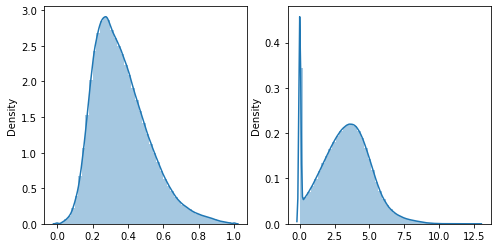

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8 ,4))
sns.distplot(array_comp.flatten(), ax=ax1)
sns.distplot(seq_comp.flatten(), ax=ax2)

In [10]:
reload(run_count_autoencoder)
m = run_count_autoencoder.run_count_autoencoder('../data_files/rnaseq_compendium_filtered.csv',lr=.0001,seed=460,kl1=1e-10,kl2=1e-1, act = 'sigmoid', tied = True, epochs=50, init='glorot_uniform', batch_size=10)
tf_adage = Adage.Adage(m.autoencoder, m.history, m.compendium)
tf_weights = np.array(pd.read_csv('../outputs/ADAGE_OG_weights.csv', header = None))
tf_cost = pd.read_csv('../outputs/ADAGE_OG_cost_log.csv')
tf_adage.weights = tf_weights
tf_adage.loss = tf_cost['cost']
tf_adage.set_hwg_cutoff(2.5).shape

tensorflow
(5543, 2288)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/50
206/206 [==============================] - 8s 34ms/step - loss: 39.7501 - val_loss: 9.2154
Epoch 2/50
206/206 [==============================] - 7s 32ms/step - loss: 6.5600 - val_loss: 6.3662
Epoch 3/50
206/206 [==============================] - 7s 35ms/step - loss: 5.3719 - val_loss: 6.3533
Epoch 4/50
206/206 [==============================] - 7s 34ms/step - los

/home/georgia/anaconda3/envs/tfk/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(5549, 600)

[Text(0.5, 1.0, 'k_adage')]

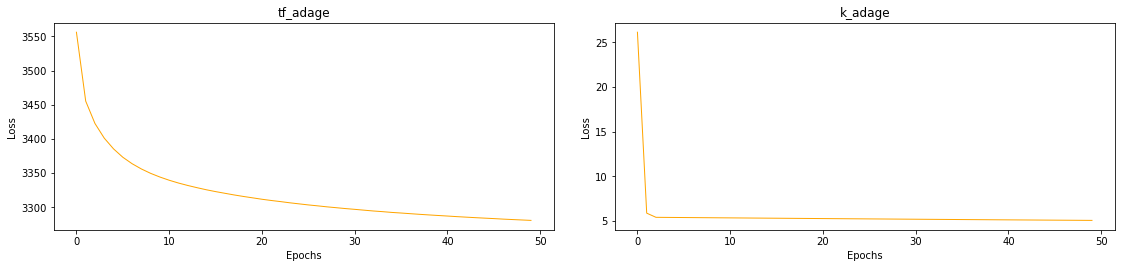

In [11]:
model_dict = {
    "tf_adage": tf_adage,
    "k_adage": m
}
fig, ax = plt.subplots(1, 2,figsize=(16 ,4))
fig.tight_layout(pad=3.0)

name = 'tf_adage'
model_temp = model_dict[name]
ax[0].plot(list(range(0,50)), model_temp.loss[0:50], linewidth=1, markersize=2, color = 'orange')
ax[0].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
ax[0].set(title = name)

name = 'k_adage'
model_temp = model_dict[name]
ax[1].plot(list(range(0,50)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
ax[1].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
ax[1].set(title = name)

In [14]:
inits = ['glorot_uniform', 'glorot_normal']
L1_norm = [0, 1e-5]
L2_norm = [0, 1e-5]
act_fun = ['sigmoid', 'tanh','relu']
tied = [True]
lr = [.01,.001]

model_dict_da = {
    "tf_adage": tf_adage
}
model_dict_dca = {
    "tf_adage": tf_adage
}

for seed in range(10):
    for i in inits:
    #print(i)
        for l in L1_norm:
        #print(l)
            for a in act_fun:
            #print(a)
                for t in lr:
                    name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t)
                    print(name)
                    mseq = run_count_autoencoder.run_count_autoencoder('../data_files/rnaseq_compendium_filtered.csv',seed=seed+560,lr=t,kl1=l, act = a, tied = True, epochs=50, init=i, batch_size = 10)
                    marr = run_count_autoencoder.run_count_autoencoder('../data_files/rnaseq_compendium_filtered_counts_floor.csv',seed=seed+560,lr=t,kl1=l, act = a, tied = True, epochs=50, init=i, batch_size = 10)

                    model_dict_da[name] = marr
                    model_dict_dca[name] = mseq

ad_glorot_uniform_0_sigmoid_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 25ms/step - loss: 3.9967 - val_loss: 4.7006
Epoch 2/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9052 - val_loss: 4.7006
Epoch 3/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9145 - val_loss: 4.7006
Epoch 4/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9184 - val_loss: 4.7006
Epoch 5/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9599 - val_loss: 4.7007
Epoch 6/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9199 - val_loss: 4.7007
Epoch 7/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9177 - val_loss: 4.7007
Epoch 8/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9296 - val_loss: 4.7008
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9355 - val_loss: 4.7007
Epoch 10/50
206/206 [=========

/home/georgia/anaconda3/envs/tfk/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 25ms/step - loss: 7586.1262 - val_loss: 15292.4346
Epoch 2/50
206/206 [==============================] - 5s 23ms/step - loss: 7660.8981 - val_loss: 15292.4346
Epoch 3/50
206/206 [==============================] - 5s 23ms/step - loss: 7421.5964 - val_loss: 15292.4346
Epoch 4/50
206/206 [==============================] - 5s 22ms/step - loss: 7439.0113 - val_loss: 15292.4346
Epoch 5/50
206/206 [==============================] - 4s 22ms/step - loss: 7466.3986 - val_loss: 15292.4346
Epoch 6/50
206/206 [==============================] - 5s 23ms/step - loss: 7993.9236 - val_loss: 15292.4346
Epoch 7/50
206/206 [==============================] - 5s 23ms/step - loss: 7681.6827 - val_loss: 15292.4346
Epoch 8/50
206/206 [==============================] - 5s 24ms/step - loss: 7831.3484 - val_loss: 15292.4346
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: 7869.8436 - val_loss: 15292.4346
Epoc

206/206 [==============================] - 5s 23ms/step - loss: 3.9228 - val_loss: 4.7010
Epoch 23/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9370 - val_loss: 4.7010
Epoch 24/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9370 - val_loss: 4.7010
Epoch 25/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9437 - val_loss: 4.7010
Epoch 26/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9254 - val_loss: 4.7010
Epoch 27/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9241 - val_loss: 4.7010
Epoch 28/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9239 - val_loss: 4.7010
Epoch 29/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9183 - val_loss: 4.7010
Epoch 30/50
206/206 [==============================] - 5s 24ms/step - loss: 3.8888 - val_loss: 4.7010
Epoch 31/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9376 - val_loss:

206/206 [==============================] - 4s 19ms/step - loss: 7415.0333 - val_loss: 15292.4346
Epoch 45/50
206/206 [==============================] - 4s 19ms/step - loss: 7267.1316 - val_loss: 15292.4346
Epoch 46/50
206/206 [==============================] - 4s 19ms/step - loss: 7482.9402 - val_loss: 15292.4346
Epoch 47/50
206/206 [==============================] - 4s 19ms/step - loss: 7878.1732 - val_loss: 15292.4346
Epoch 48/50
206/206 [==============================] - 4s 20ms/step - loss: 7725.2884 - val_loss: 15292.4346
Epoch 49/50
206/206 [==============================] - 4s 19ms/step - loss: 7605.2116 - val_loss: 15292.4346
Epoch 50/50
206/206 [==============================] - 4s 19ms/step - loss: 7710.3647 - val_loss: 15292.4346
(2,)
ad_glorot_uniform_0_tanh_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: 

Epoch 22/50
206/206 [==============================] - 4s 18ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 4s 22ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 31/50
206/206 [==============================] - 


Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============

206/206 [==============================] - 4s 20ms/step - loss: 4.7940 - val_loss: 6.1283
Epoch 28/50
206/206 [==============================] - 4s 21ms/step - loss: 4.7804 - val_loss: 6.1229
Epoch 29/50
206/206 [==============================] - 4s 20ms/step - loss: 4.8145 - val_loss: 6.1257
Epoch 30/50
206/206 [==============================] - 4s 19ms/step - loss: 4.7777 - val_loss: 6.1276
Epoch 31/50
206/206 [==============================] - 4s 22ms/step - loss: 4.8198 - val_loss: 6.1225
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: 4.8044 - val_loss: 6.1349

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 33/50
206/206 [==============================] - 4s 21ms/step - loss: 4.8109 - val_loss: 6.1268
Epoch 34/50
206/206 [==============================] - 4s 20ms/step - loss: 4.7953 - val_loss: 6.1245
Epoch 35/50
206/206 [==============================] - 4s 21ms/step - loss: 4.8006 - val_loss: 6.1242
Epoch 36/50
2

206/206 [==============================] - 4s 20ms/step - loss: 893.7508 - val_loss: 1848.5852
(2,)
ad_glorot_uniform_0_relu_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 21ms/step - loss: 4.0295 - val_loss: 2.6974
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: 2.2415 - val_loss: 2.5977
Epoch 3/50
206/206 [==============================] - 4s 21ms/step - loss: 2.1921 - val_loss: 2.5807
Epoch 4/50
206/206 [==============================] - 4s 21ms/step - loss: 2.1737 - val_loss: 2.5626
Epoch 5/50
206/206 [==============================] - 4s 21ms/step - loss: 2.1578 - val_loss: 2.5519
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1217 - val_loss: 2.5058
Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1115 - val_loss: 2.5298
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1046 - val_loss: 2.4885
Epoch 9/50
206/206 [=============

Epoch 27/50
206/206 [==============================] - 4s 20ms/step - loss: 868.0888 - val_loss: 1842.3087
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: 820.2502 - val_loss: 1831.8447
Epoch 29/50
206/206 [==============================] - 4s 20ms/step - loss: 858.0658 - val_loss: 1829.1952
Epoch 30/50
206/206 [==============================] - 4s 21ms/step - loss: 852.3370 - val_loss: 1837.1652
Epoch 31/50
206/206 [==============================] - 4s 21ms/step - loss: 807.6311 - val_loss: 1837.2999
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: 905.9026 - val_loss: 1853.9257
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: 816.4044 - val_loss: 1829.6937

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 34/50
206/206 [==============================] - 4s 21ms/step - loss: 901.5256 - val_loss: 1834.0173
Epoch 35/50
206/206 [==============================] - 4s 22ms

206/206 [==============================] - 5s 25ms/step - loss: 7822.0073 - val_loss: 15292.7402
Epoch 4/50
206/206 [==============================] - 5s 23ms/step - loss: 7501.7370 - val_loss: 15292.7197
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: 7820.4763 - val_loss: 15292.6914
Epoch 6/50
206/206 [==============================] - 5s 24ms/step - loss: 7449.3872 - val_loss: 15292.6650
Epoch 7/50
206/206 [==============================] - 5s 24ms/step - loss: 7699.0735 - val_loss: 15292.6416
Epoch 8/50
206/206 [==============================] - 5s 25ms/step - loss: 7484.5686 - val_loss: 15292.6328
Epoch 9/50
206/206 [==============================] - 5s 24ms/step - loss: 7825.4119 - val_loss: 15292.6211
Epoch 10/50
206/206 [==============================] - 5s 23ms/step - loss: 7557.5105 - val_loss: 15292.6113
Epoch 11/50
206/206 [==============================] - 5s 24ms/step - loss: 7727.7846 - val_loss: 15292.5967
Epoch 12/50
206/206 [================

206/206 [==============================] - 5s 24ms/step - loss: 3.9615 - val_loss: 4.7680
Epoch 30/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9712 - val_loss: 4.7594
Epoch 31/50
206/206 [==============================] - 5s 26ms/step - loss: 3.9697 - val_loss: 4.7551
Epoch 32/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9714 - val_loss: 4.7540
Epoch 33/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9756 - val_loss: 4.7538
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9875 - val_loss: 4.7523
Epoch 35/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0042 - val_loss: 4.7525
Epoch 36/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9938 - val_loss: 4.7508
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9677 - val_loss: 4.7507
Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9654 - val_loss:

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 5s 25ms/step - l

206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 41/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 42/50
206/206 [==============================] - 5s 24ms/step 

206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning ra

206/206 [==============================] - 5s 24ms/step - loss: 2.0922 - val_loss: 2.5099
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0910 - val_loss: 2.4865
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: 2.1029 - val_loss: 2.5016
Epoch 41/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0893 - val_loss: 2.4933
Epoch 42/50
206/206 [==============================] - 5s 24ms/step - loss: 2.1124 - val_loss: 2.5717
Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: 2.1012 - val_loss: 2.5601

Epoch 00043: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0713 - val_loss: 2.4600
Epoch 45/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0577 - val_loss: 2.4643
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0602 - val_loss: 2.4677
Epoch 47/50
2

206/206 [==============================] - 5s 25ms/step - loss: 2.0821 - val_loss: 2.4776
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0926 - val_loss: 2.5264
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0814 - val_loss: 2.5205
Epoch 14/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0877 - val_loss: 2.5763
Epoch 15/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0895 - val_loss: 2.4911
Epoch 16/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0935 - val_loss: 2.4959
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1006 - val_loss: 2.4827

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 18/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0639 - val_loss: 2.4754
Epoch 19/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0597 - val_loss: 2.4700
Epoch 20/50


206/206 [==============================] - 5s 24ms/step - loss: 887.3536 - val_loss: 1840.4883
Epoch 37/50
206/206 [==============================] - 5s 24ms/step - loss: 971.9969 - val_loss: 1841.5277
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: 913.5058 - val_loss: 1842.0499
Epoch 39/50
206/206 [==============================] - 5s 24ms/step - loss: 836.7803 - val_loss: 1841.2671
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: 849.1968 - val_loss: 1840.3239
Epoch 41/50
206/206 [==============================] - 5s 26ms/step - loss: 910.4394 - val_loss: 1841.3771
Epoch 42/50
206/206 [==============================] - 5s 24ms/step - loss: 842.0728 - val_loss: 1841.9673

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 870.1089 - val_loss: 1842.0194
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss

206/206 [==============================] - 4s 20ms/step - loss: 7539.7258 - val_loss: 15292.4346
Epoch 11/50
206/206 [==============================] - 4s 19ms/step - loss: 7554.2966 - val_loss: 15292.4346

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 12/50
206/206 [==============================] - 4s 19ms/step - loss: 7345.2409 - val_loss: 15292.4346
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: 7382.8194 - val_loss: 15292.4346
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: 7709.2871 - val_loss: 15292.4346
Epoch 15/50
206/206 [==============================] - 4s 19ms/step - loss: 7942.1743 - val_loss: 15292.4346
Epoch 16/50
206/206 [==============================] - 4s 19ms/step - loss: 7594.4974 - val_loss: 15292.4346
Epoch 17/50
206/206 [==============================] - 4s 19ms/step - loss: 7578.9826 - val_loss: 15292.4346
Epoch 18/50
206/206 [==============================] - 4s 2

206/206 [==============================] - 4s 20ms/step - loss: 3.9343 - val_loss: 4.7010

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9386 - val_loss: 4.7010
Epoch 34/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9160 - val_loss: 4.7010
Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9222 - val_loss: 4.7010
Epoch 36/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9365 - val_loss: 4.7010
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9470 - val_loss: 4.7010
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9152 - val_loss: 4.7010
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9360 - val_loss: 4.7010
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9556 - val_loss: 4.7010
Epoch 41/50


206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 4s 19ms/step - los

206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning ra

206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 4s 21ms/ste

206/206 [==============================] - 4s 20ms/step - loss: 2.2011 - val_loss: 2.5798
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1658 - val_loss: 2.5653
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: 2.3031 - val_loss: 2.5696
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: 2.3147 - val_loss: 2.5601
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: 2.2516 - val_loss: 2.5689
Epoch 41/50
206/206 [==============================] - 4s 21ms/step - loss: 2.4382 - val_loss: 2.5759
Epoch 42/50
206/206 [==============================] - 4s 21ms/step - loss: 2.4213 - val_loss: 2.5712
Epoch 43/50
206/206 [==============================] - 4s 21ms/step - loss: 2.5186 - val_loss: 2.5718
Epoch 44/50
206/206 [==============================] - 4s 20ms/step - loss: 2.2522 - val_loss: 2.5814
Epoch 45/50
206/206 [==============================] - 4s 20ms/step - loss: 2.2027 - val_loss:

206/206 [==============================] - 4s 20ms/step - loss: 2.1285 - val_loss: 2.5376
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1506 - val_loss: 2.5179
Epoch 12/50
206/206 [==============================] - 4s 21ms/step - loss: 2.1285 - val_loss: 2.5229
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1263 - val_loss: 2.5224
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1227 - val_loss: 2.5424
Epoch 15/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1341 - val_loss: 2.5193
Epoch 16/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1138 - val_loss: 2.4786
Epoch 17/50
206/206 [==============================] - 5s 22ms/step - loss: 2.0985 - val_loss: 2.5045
Epoch 18/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0929 - val_loss: 2.5604
Epoch 19/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1166 - val_loss:

206/206 [==============================] - 4s 20ms/step - loss: 881.4888 - val_loss: 1844.1884
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 862.1185 - val_loss: 1871.3254
Epoch 38/50
206/206 [==============================] - 4s 21ms/step - loss: 886.6497 - val_loss: 1855.2987
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: 868.5907 - val_loss: 1833.6030

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 40/50
206/206 [==============================] - 4s 21ms/step - loss: 851.7519 - val_loss: 1836.7129
Epoch 41/50
206/206 [==============================] - 4s 20ms/step - loss: 872.0318 - val_loss: 1840.0128
Epoch 42/50
206/206 [==============================] - 4s 20ms/step - loss: 832.1870 - val_loss: 1840.6857
Epoch 43/50
206/206 [==============================] - 4s 21ms/step - loss: 844.2089 - val_loss: 1841.4099
Epoch 44/50
206/206 [==============================] - 4s 21ms/step - loss

206/206 [==============================] - 5s 25ms/step - loss: 7756.5046 - val_loss: 15292.6133
Epoch 13/50
206/206 [==============================] - 5s 24ms/step - loss: 7494.1890 - val_loss: 15292.6045
Epoch 14/50
206/206 [==============================] - 5s 25ms/step - loss: 7650.4389 - val_loss: 15292.5918
Epoch 15/50
206/206 [==============================] - 5s 23ms/step - loss: 8288.4922 - val_loss: 15292.5781
Epoch 16/50
206/206 [==============================] - 5s 25ms/step - loss: 7501.9366 - val_loss: 15292.5781
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: 7587.6885 - val_loss: 15292.5801
Epoch 18/50
206/206 [==============================] - 5s 23ms/step - loss: 7654.6434 - val_loss: 15292.5781
Epoch 19/50
206/206 [==============================] - 5s 24ms/step - loss: 7326.2051 - val_loss: 15292.5752
Epoch 20/50
206/206 [==============================] - 5s 24ms/step - loss: 7655.1372 - val_loss: 15292.5645
Epoch 21/50
206/206 [==========

206/206 [==============================] - 5s 25ms/step - loss: 3.9864 - val_loss: 4.7504
Epoch 40/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9995 - val_loss: 4.7488
Epoch 41/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9687 - val_loss: 4.7487
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9788 - val_loss: 4.7459
Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9844 - val_loss: 4.7466
Epoch 44/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9529 - val_loss: 4.7470
Epoch 45/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9899 - val_loss: 4.7450
Epoch 46/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9939 - val_loss: 4.7448
Epoch 47/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9584 - val_loss: 4.7440
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9689 - val_loss:

206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 21/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 5s 25ms/step

206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 45/50
206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan
Epoch 46/50
206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan
Epoch 47/50
206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan
Epoch 48/50
206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan
Epoch 49/50
206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan
Epoch 50/50
206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
(2,)
ad_glorot_normal_1e-05_tanh_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 25ms/step - loss: inf - val_loss: inf
Ep

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning ra

206/206 [==============================] - 5s 24ms/step - loss: 2.0624 - val_loss: 2.4717
Epoch 49/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0651 - val_loss: 2.4638
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0591 - val_loss: 2.4604
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 26ms/step - loss: 1583.2633 - val_loss: 1935.0166
Epoch 2/50
206/206 [==============================] - 5s 25ms/step - loss: 949.6489 - val_loss: 1876.7954
Epoch 3/50
206/206 [==============================] - 5s 25ms/step - loss: 959.9306 - val_loss: 1921.9108
Epoch 4/50
206/206 [==============================] - 5s 24ms/step - loss: 942.6866 - val_loss: 1870.2678
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: 862.5250 - val_loss: 1989.1278
Epoch 6/50
206/206 [==============================] - 5s 24ms/step - loss: 923.0127 - val_loss: 2011.3624
Epoch 7/50
206/206 [====================

206/206 [==============================] - 6s 30ms/step - loss: 2.0645 - val_loss: 2.4712
Epoch 23/50
206/206 [==============================] - 6s 27ms/step - loss: 2.0668 - val_loss: 2.4733
Epoch 24/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0597 - val_loss: 2.4685
Epoch 25/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0622 - val_loss: 2.4681
Epoch 26/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0630 - val_loss: 2.4685
Epoch 27/50
206/206 [==============================] - 6s 30ms/step - loss: 2.0640 - val_loss: 2.4675
Epoch 28/50
206/206 [==============================] - 6s 27ms/step - loss: 2.0572 - val_loss: 2.4738
Epoch 29/50
206/206 [==============================] - 6s 30ms/step - loss: 2.0614 - val_loss: 2.4753
Epoch 30/50
206/206 [==============================] - 7s 33ms/step - loss: 2.0676 - val_loss: 2.4697
Epoch 31/50
206/206 [==============================] - 6s 27ms/step - loss: 2.0635 - val_loss:

206/206 [==============================] - 6s 30ms/step - loss: 792.6123 - val_loss: 1841.2426
Epoch 47/50
206/206 [==============================] - 6s 31ms/step - loss: 831.4174 - val_loss: 1841.2246
Epoch 48/50
206/206 [==============================] - 6s 29ms/step - loss: 847.7558 - val_loss: 1841.2039
Epoch 49/50
206/206 [==============================] - 6s 30ms/step - loss: 852.0012 - val_loss: 1841.2416
Epoch 50/50
206/206 [==============================] - 6s 30ms/step - loss: 799.9114 - val_loss: 1841.3184
(2,)
ad_glorot_uniform_0_sigmoid_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 25ms/step - loss: 3.9805 - val_loss: 4.7006
Epoch 2/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9324 - val_loss: 4.7015
Epoch 3/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9199 - val_loss: 4.7007
Epoch 4/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9221 - val_loss: 4.7007
Epoch 5

206/206 [==============================] - 5s 24ms/step - loss: 7646.8906 - val_loss: 15292.4346
Epoch 21/50
206/206 [==============================] - 5s 24ms/step - loss: 7655.6197 - val_loss: 15292.4346

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 22/50
206/206 [==============================] - 5s 23ms/step - loss: 7408.1368 - val_loss: 15292.4346
Epoch 23/50
206/206 [==============================] - 5s 25ms/step - loss: 8001.6008 - val_loss: 15292.4346
Epoch 24/50
206/206 [==============================] - 5s 24ms/step - loss: 7180.8145 - val_loss: 15292.4346
Epoch 25/50
206/206 [==============================] - 5s 24ms/step - loss: 8092.3327 - val_loss: 15292.4346
Epoch 26/50
206/206 [==============================] - 5s 23ms/step - loss: 7363.5663 - val_loss: 15292.4346
Epoch 27/50
206/206 [==============================] - 5s 25ms/step - loss: 7531.0439 - val_loss: 15292.4346
Epoch 28/50
206/206 [==============================] - 5s 2

Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9579 - val_loss: 4.7010
Epoch 44/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9313 - val_loss: 4.7010
Epoch 45/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9238 - val_loss: 4.7010

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 46/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9163 - val_loss: 4.7010
Epoch 47/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9266 - val_loss: 4.7010
Epoch 48/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9352 - val_loss: 4.7010
Epoch 49/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9110 - val_loss: 4.7010
Epoch 50/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9220 - val_loss: 4.7010
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 25ms/step - loss

206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 21/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 5s 23ms/step

206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 45/50
206/206 [==============================] - 5s 22ms/step - loss: inf - val_loss: inf
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 47/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 48/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
(2,)
ad_glorot_uniform_0_tanh_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 24ms/step - loss: inf - val_loss: inf
Epoch

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 5s 22ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning ra

206/206 [==============================] - 4s 20ms/step - loss: 2.7405 - val_loss: 3.3637
Epoch 48/50
206/206 [==============================] - 4s 19ms/step - loss: 2.7363 - val_loss: 3.3625
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: 2.7440 - val_loss: 3.3617
Epoch 50/50
206/206 [==============================] - 4s 20ms/step - loss: 2.7196 - val_loss: 3.3606
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 23ms/step - loss: 2355.9920 - val_loss: 2171.1497
Epoch 2/50
206/206 [==============================] - 4s 21ms/step - loss: 944.0162 - val_loss: 1889.0471
Epoch 3/50
206/206 [==============================] - 4s 21ms/step - loss: 878.9816 - val_loss: 1884.8661
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: 871.8502 - val_loss: 1990.4954
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: 873.8649 - val_loss: 1920.2173
Epoch 6/50
206/206 [========================

206/206 [==============================] - 5s 23ms/step - loss: 2.0785 - val_loss: 2.4983
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0647 - val_loss: 2.4740
Epoch 23/50
206/206 [==============================] - 5s 23ms/step - loss: 2.0676 - val_loss: 2.5096
Epoch 24/50
206/206 [==============================] - 5s 23ms/step - loss: 2.0768 - val_loss: 2.4827
Epoch 25/50
206/206 [==============================] - 5s 23ms/step - loss: 2.0695 - val_loss: 2.4492
Epoch 26/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0714 - val_loss: 2.6077
Epoch 27/50
206/206 [==============================] - 5s 23ms/step - loss: 2.0861 - val_loss: 2.4588
Epoch 28/50
206/206 [==============================] - 5s 23ms/step - loss: 2.0909 - val_loss: 2.4566
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: 2.1254 - val_loss: 2.4604
Epoch 30/50
206/206 [==============================] - 5s 24ms/step - loss: 2.1343 - val_loss:

Epoch 46/50
206/206 [==============================] - 5s 24ms/step - loss: 871.6351 - val_loss: 1846.2533
Epoch 47/50
206/206 [==============================] - 5s 23ms/step - loss: 858.2749 - val_loss: 1846.2201
Epoch 48/50
206/206 [==============================] - 5s 24ms/step - loss: 808.6928 - val_loss: 1846.2472

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 49/50
206/206 [==============================] - 5s 25ms/step - loss: 826.0879 - val_loss: 1846.2538
Epoch 50/50
206/206 [==============================] - 5s 24ms/step - loss: 842.5568 - val_loss: 1846.2595
(2,)
ad_glorot_uniform_1e-05_sigmoid_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 7s 30ms/step - loss: 4.2621 - val_loss: 4.9657
Epoch 2/50
206/206 [==============================] - 6s 28ms/step - loss: 4.1347 - val_loss: 4.9065
Epoch 3/50
206/206 [==============================] - 6s 29ms/step - loss: 4.1026 - val_loss: 4.8792
Epoch 4/50

206/206 [==============================] - 6s 28ms/step - loss: 8010.6485 - val_loss: 15292.5615
Epoch 23/50
206/206 [==============================] - 6s 28ms/step - loss: 7487.6696 - val_loss: 15292.5576
Epoch 24/50
206/206 [==============================] - 6s 29ms/step - loss: 7642.0053 - val_loss: 15292.5557
Epoch 25/50
206/206 [==============================] - 6s 28ms/step - loss: 7647.6233 - val_loss: 15292.5576
Epoch 26/50
206/206 [==============================] - 6s 29ms/step - loss: 7805.6767 - val_loss: 15292.5527
Epoch 27/50
206/206 [==============================] - 6s 28ms/step - loss: 7644.4731 - val_loss: 15292.5518
Epoch 28/50
206/206 [==============================] - 6s 28ms/step - loss: 7691.4719 - val_loss: 15292.5469
Epoch 29/50
206/206 [==============================] - 6s 29ms/step - loss: 7563.0637 - val_loss: 15292.5615
Epoch 30/50
206/206 [==============================] - 6s 28ms/step - loss: 7685.2663 - val_loss: 15292.5527
Epoch 31/50
206/206 [==========

Epoch 50/50
206/206 [==============================] - 6s 29ms/step - loss: 3.9819 - val_loss: 4.7426
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 7s 30ms/step - loss: 7297.7425 - val_loss: 15292.9688
Epoch 2/50
206/206 [==============================] - 6s 28ms/step - loss: 7353.7985 - val_loss: 15292.8955
Epoch 3/50
206/206 [==============================] - 6s 28ms/step - loss: 7766.8808 - val_loss: 15292.8574
Epoch 4/50
206/206 [==============================] - 6s 29ms/step - loss: 7588.0673 - val_loss: 15292.8027
Epoch 5/50
206/206 [==============================] - 6s 28ms/step - loss: 7442.8208 - val_loss: 15292.7676
Epoch 6/50
206/206 [==============================] - 6s 27ms/step - loss: 7701.5022 - val_loss: 15292.7520
Epoch 7/50
206/206 [==============================] - 6s 28ms/step - loss: 7520.7158 - val_loss: 15292.7227
Epoch 8/50
206/206 [==============================] - 6s 29ms/step - loss: 7355.0646 - val_loss: 15292.6973
Epoch

206/206 [==============================] - 6s 29ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 6s 30ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 6s 30ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 6s 29ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 6s 30ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 31/50
206/206 [==============================] - 6s 29ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 6s 29ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 6s 29ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 6s 29ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 6s 29ms/step

Epoch 4/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 5s 25

206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 41/50
206/206 [==============================] - 5s 25ms/ste

206/206 [==============================] - 5s 25ms/step - loss: 875.6546 - val_loss: 1803.4910
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: 906.7295 - val_loss: 1935.9089
Epoch 10/50
206/206 [==============================] - 5s 26ms/step - loss: 848.0223 - val_loss: 2250.1775
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: 904.7324 - val_loss: 1855.4856
Epoch 12/50
206/206 [==============================] - 5s 24ms/step - loss: 899.6936 - val_loss: 1873.1106
Epoch 13/50
206/206 [==============================] - 5s 24ms/step - loss: 923.5229 - val_loss: 1824.9729
Epoch 14/50
206/206 [==============================] - 5s 25ms/step - loss: 936.4035 - val_loss: 1762.4482
Epoch 15/50
206/206 [==============================] - 5s 26ms/step - loss: 907.1420 - val_loss: 1715.9886
Epoch 16/50
206/206 [==============================] - 5s 25ms/step - loss: 905.1390 - val_loss: 1861.8225
Epoch 17/50
206/206 [=============================

206/206 [==============================] - 5s 25ms/step - loss: 2.0549 - val_loss: 2.4613
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0510 - val_loss: 2.4671
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0584 - val_loss: 2.4551
Epoch 35/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0523 - val_loss: 2.4536
Epoch 36/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0542 - val_loss: 2.4581
Epoch 37/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0581 - val_loss: 2.4585
Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0634 - val_loss: 2.4623
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0653 - val_loss: 2.4671
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0559 - val_loss: 2.4645
Epoch 41/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0593 - val_loss:

Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9294 - val_loss: 4.7007
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9299 - val_loss: 4.7007
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9295 - val_loss: 4.7013
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9463 - val_loss: 4.7008
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9276 - val_loss: 4.7007

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 12/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9335 - val_loss: 4.7008
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9374 - val_loss: 4.7010
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9510 - val_loss: 4.7011
Epoch 15/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9346 - val_loss: 4.7010
Epoc

206/206 [==============================] - 4s 19ms/step - loss: 7697.4471 - val_loss: 15292.4346
Epoch 31/50
206/206 [==============================] - 4s 19ms/step - loss: 7605.7632 - val_loss: 15292.4346

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 32/50
206/206 [==============================] - 4s 19ms/step - loss: 7413.9897 - val_loss: 15292.4346
Epoch 33/50
206/206 [==============================] - 4s 19ms/step - loss: 7304.6926 - val_loss: 15292.4346
Epoch 34/50
206/206 [==============================] - 4s 19ms/step - loss: 7883.0041 - val_loss: 15292.4346
Epoch 35/50
206/206 [==============================] - 4s 19ms/step - loss: 7748.3248 - val_loss: 15292.4346
Epoch 36/50
206/206 [==============================] - 4s 20ms/step - loss: 7508.1475 - val_loss: 15292.4346
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 7499.4025 - val_loss: 15292.4346
Epoch 38/50
206/206 [==============================] - 4s 2

206/206 [==============================] - 4s 20ms/step - loss: 7867.5436 - val_loss: 15292.4346
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: 7634.0222 - val_loss: 15292.4346
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: 7511.7111 - val_loss: 15292.4346
Epoch 6/50
206/206 [==============================] - 4s 21ms/step - loss: 7026.9873 - val_loss: 15292.4346
Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: 7396.7398 - val_loss: 15292.4346
Epoch 8/50
206/206 [==============================] - 4s 19ms/step - loss: 7887.5936 - val_loss: 15292.4346
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: 7662.7215 - val_loss: 15292.4346
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: 8040.6577 - val_loss: 15292.4346
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: 7723.5508 - val_loss: 15292.4346
Epoch 12/50
206/206 [================

206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 31/50
206/206 [==============================] - 4s 18ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 4s 18ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 4s 21ms/step

Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 4s 19

206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 41/50
206/206 [==============================] - 4s 19ms/ste

206/206 [==============================] - 4s 20ms/step - loss: 881.9330 - val_loss: 1718.3336
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: 929.3676 - val_loss: 1904.6782
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: 903.3796 - val_loss: 1977.5151
Epoch 10/50
206/206 [==============================] - 4s 21ms/step - loss: 922.6586 - val_loss: 1973.6636
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: 888.7169 - val_loss: 1814.5848
Epoch 12/50
206/206 [==============================] - 4s 19ms/step - loss: 839.7375 - val_loss: 1785.3933
Epoch 13/50
206/206 [==============================] - 5s 22ms/step - loss: 909.3230 - val_loss: 1971.1201
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: 928.9614 - val_loss: 1882.9628
Epoch 15/50
206/206 [==============================] - 5s 22ms/step - loss: 920.6668 - val_loss: 1888.1433
Epoch 16/50
206/206 [==============================

Epoch 31/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0391 - val_loss: 2.4494
Epoch 32/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0521 - val_loss: 2.4529
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0485 - val_loss: 2.4526
Epoch 34/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0397 - val_loss: 2.4521
Epoch 35/50
206/206 [==============================] - 5s 23ms/step - loss: 2.0398 - val_loss: 2.4511
Epoch 36/50
206/206 [==============================] - 4s 19ms/step - loss: 2.0447 - val_loss: 2.4596
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0409 - val_loss: 2.4588
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0288 - val_loss: 2.4507
Epoch 39/50
206/206 [==============================] - 4s 19ms/step - loss: 2.0333 - val_loss: 2.4467
Epoch 40/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0390

206/206 [==============================] - 5s 24ms/step - loss: 4.0727 - val_loss: 4.8338
Epoch 6/50
206/206 [==============================] - 5s 23ms/step - loss: 4.0811 - val_loss: 4.8249
Epoch 7/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0296 - val_loss: 4.8138
Epoch 8/50
206/206 [==============================] - 5s 26ms/step - loss: 4.0453 - val_loss: 4.8306
Epoch 9/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0328 - val_loss: 4.8127
Epoch 10/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0041 - val_loss: 4.8061
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0371 - val_loss: 4.8047
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0588 - val_loss: 4.8006
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0360 - val_loss: 4.8094
Epoch 14/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0529 - val_loss: 4.7

206/206 [==============================] - 5s 24ms/step - loss: 7599.0132 - val_loss: 15292.5449
Epoch 33/50
206/206 [==============================] - 5s 24ms/step - loss: 7700.4121 - val_loss: 15292.5439
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: 7775.3993 - val_loss: 15292.5469
Epoch 35/50
206/206 [==============================] - 5s 25ms/step - loss: 7388.5127 - val_loss: 15292.5400
Epoch 36/50
206/206 [==============================] - 5s 24ms/step - loss: 7898.4823 - val_loss: 15292.5391
Epoch 37/50
206/206 [==============================] - 5s 24ms/step - loss: 7268.3115 - val_loss: 15292.5381
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: 7462.4507 - val_loss: 15292.5381
Epoch 39/50
206/206 [==============================] - 5s 24ms/step - loss: 7530.7815 - val_loss: 15292.5371
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: 7704.4228 - val_loss: 15292.5381
Epoch 41/50
206/206 [==========

Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: 8007.7699 - val_loss: 15292.6816
Epoch 11/50
206/206 [==============================] - 5s 24ms/step - loss: 8115.4629 - val_loss: 15292.6543
Epoch 12/50
206/206 [==============================] - 5s 24ms/step - loss: 7467.0500 - val_loss: 15292.6504
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: 7723.4922 - val_loss: 15292.6377
Epoch 14/50
206/206 [==============================] - 5s 24ms/step - loss: 7233.3318 - val_loss: 15292.6230
Epoch 15/50
206/206 [==============================] - 5s 23ms/step - loss: 7786.8650 - val_loss: 15292.6152
Epoch 16/50
206/206 [==============================] - 5s 24ms/step - loss: 7729.3469 - val_loss: 15292.6309
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: 7617.0880 - val_loss: 15292.6055
Epoch 18/50
206/206 [==============================] - 5s 24ms/step - loss: 7392.3924 - val_loss: 15292.5967
Epoch 19/50
206/206

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 41/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 45/50
206/206 [==============================] - 5s 24ms/step 

Epoch 14/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] -

206/206 [==============================] - 5s 24ms/step - loss: 14242.1524 - val_loss: 26011.8516
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 13543.6197 - val_loss: 24579.9316
Epoch 44/50
206/206 [==============================] - 5s 24ms/step - loss: 12395.1939 - val_loss: 23587.2969
Epoch 45/50
206/206 [==============================] - 5s 24ms/step - loss: 11496.0953 - val_loss: 22840.7285
Epoch 46/50
206/206 [==============================] - 5s 24ms/step - loss: 11741.2924 - val_loss: 22255.8730
Epoch 47/50
206/206 [==============================] - 5s 24ms/step - loss: 11541.3346 - val_loss: 21780.2988
Epoch 48/50
206/206 [==============================] - 5s 24ms/step - loss: 11612.6609 - val_loss: 21387.2012
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: 10629.6675 - val_loss: 21056.6641
Epoch 50/50
206/206 [==============================] - 5s 24ms/step - loss: 10902.1849 - val_loss: 20771.6699
(2,)
ad_glorot_normal_

206/206 [==============================] - 5s 24ms/step - loss: 873.9016 - val_loss: 2045.2030
Epoch 19/50
206/206 [==============================] - 5s 25ms/step - loss: 841.1128 - val_loss: 2000.6549
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: 912.9981 - val_loss: 2062.7241
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: 872.8109 - val_loss: 1867.4777
Epoch 22/50
206/206 [==============================] - 6s 27ms/step - loss: 846.1961 - val_loss: 1772.5753
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: 907.9495 - val_loss: 1855.2937
Epoch 24/50
206/206 [==============================] - 5s 26ms/step - loss: 849.9204 - val_loss: 1914.2277
Epoch 25/50
206/206 [==============================] - 5s 25ms/step - loss: 868.0861 - val_loss: 1853.8511
Epoch 26/50
206/206 [==============================] - 5s 26ms/step - loss: 874.6000 - val_loss: 1795.2533
Epoch 27/50
206/206 [============================

206/206 [==============================] - 5s 25ms/step - loss: 2.0537 - val_loss: 2.4605
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0601 - val_loss: 2.4613
Epoch 45/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0528 - val_loss: 2.4686
Epoch 46/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0601 - val_loss: 2.4588
Epoch 47/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0570 - val_loss: 2.4675
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0560 - val_loss: 2.4624
Epoch 49/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0545 - val_loss: 2.4634

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0548 - val_loss: 2.4609
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 25ms/step - loss: 3198.5686 

206/206 [==============================] - 4s 20ms/step - loss: 3.9185 - val_loss: 4.7010
Epoch 18/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9320 - val_loss: 4.7009
Epoch 19/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9232 - val_loss: 4.7009
Epoch 20/50
206/206 [==============================] - 5s 22ms/step - loss: 3.9380 - val_loss: 4.7009
Epoch 21/50
206/206 [==============================] - 4s 22ms/step - loss: 3.9322 - val_loss: 4.7010

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 22/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9139 - val_loss: 4.7010
Epoch 23/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9339 - val_loss: 4.7010
Epoch 24/50
206/206 [==============================] - 4s 22ms/step - loss: 3.9182 - val_loss: 4.7010
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9500 - val_loss: 4.7010
Epoch 26/50
2

Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: 8111.0097 - val_loss: 15292.4346
Epoch 41/50
206/206 [==============================] - 4s 20ms/step - loss: 7664.4580 - val_loss: 15292.4346

Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 42/50
206/206 [==============================] - 4s 20ms/step - loss: 7678.4121 - val_loss: 15292.4346
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: 7837.6585 - val_loss: 15292.4346
Epoch 44/50
206/206 [==============================] - 4s 19ms/step - loss: 7627.6403 - val_loss: 15292.4346
Epoch 45/50
206/206 [==============================] - 4s 20ms/step - loss: 7476.6832 - val_loss: 15292.4346
Epoch 46/50
206/206 [==============================] - 4s 19ms/step - loss: 7735.5359 - val_loss: 15292.4346
Epoch 47/50
206/206 [==============================] - 4s 20ms/step - loss: 7637.8149 - val_loss: 15292.4346
Epoch 48/50
206/206 [===========================

Epoch 14/50
206/206 [==============================] - 4s 19ms/step - loss: 7552.2230 - val_loss: 15292.4346
Epoch 15/50
206/206 [==============================] - 4s 21ms/step - loss: 7858.4789 - val_loss: 15292.4346
Epoch 16/50
206/206 [==============================] - 4s 19ms/step - loss: 7742.2296 - val_loss: 15292.4346
Epoch 17/50
206/206 [==============================] - 4s 20ms/step - loss: 7501.2415 - val_loss: 15292.4346
Epoch 18/50
206/206 [==============================] - 4s 21ms/step - loss: 7524.3359 - val_loss: 15292.4346
Epoch 19/50
206/206 [==============================] - 4s 19ms/step - loss: 7548.9999 - val_loss: 15292.4346
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: 7881.1221 - val_loss: 15292.4346
Epoch 21/50
206/206 [==============================] - 4s 19ms/step - loss: 8028.7169 - val_loss: 15292.4346
Epoch 22/50
206/206 [==============================] - 4s 20ms/step - loss: 7420.5071 - val_loss: 15292.4346

Epoch 00022: Reduc

206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 41/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 42/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 45/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 46/50
206/206 [==============================] - 4s 22ms/step - loss: inf - val_loss: inf
Epoch 47/50
206/206 [==============================] - 4s 21ms/step 

Epoch 16/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 21/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] -

206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 45/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 46/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 47/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 48/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 4s 18ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
(2,)
ad_glorot_uniform_0_relu_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 20ms/step - loss: 27.6681 - val_loss: 2.5262
Epoch 2/50
206/206 [==============================] - 4s 21ms/step - loss: 3.7333 - val_loss: 

206/206 [==============================] - 4s 20ms/step - loss: 903.3532 - val_loss: 2544.9167
Epoch 20/50
206/206 [==============================] - 4s 21ms/step - loss: 889.9908 - val_loss: 1933.9672
Epoch 21/50
206/206 [==============================] - 4s 20ms/step - loss: 910.1801 - val_loss: 1892.2743

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 22/50
206/206 [==============================] - 4s 20ms/step - loss: 855.3854 - val_loss: 1813.4495
Epoch 23/50
206/206 [==============================] - 4s 21ms/step - loss: 818.7691 - val_loss: 1832.7803
Epoch 24/50
206/206 [==============================] - 4s 20ms/step - loss: 857.8327 - val_loss: 1853.9800
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: 878.8259 - val_loss: 1828.9733
Epoch 26/50
206/206 [==============================] - 4s 20ms/step - loss: 826.0050 - val_loss: 1839.1611
Epoch 27/50
206/206 [==============================] - 4s 20ms/step - loss:

206/206 [==============================] - 4s 20ms/step - loss: 2.0766 - val_loss: 2.4940
Epoch 45/50
206/206 [==============================] - 4s 19ms/step - loss: 2.0811 - val_loss: 2.4900
Epoch 46/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0774 - val_loss: 2.4931
Epoch 47/50
206/206 [==============================] - 4s 19ms/step - loss: 2.0717 - val_loss: 2.4889
Epoch 48/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0761 - val_loss: 2.4873
Epoch 49/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0820 - val_loss: 2.4931
Epoch 50/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0683 - val_loss: 2.4921
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 23ms/step - loss: 3081.7419 - val_loss: 2325.2915
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: 983.2980 - val_loss: 2026.9869
Epoch 3/50
206/206 [==============================] - 4s

Epoch 19/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0424 - val_loss: 4.7947
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0021 - val_loss: 4.7942
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0227 - val_loss: 4.7928
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0451 - val_loss: 4.7941
Epoch 23/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0420 - val_loss: 4.7953
Epoch 24/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0270 - val_loss: 4.7965
Epoch 25/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9867 - val_loss: 4.7969
Epoch 26/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0280 - val_loss: 4.7951
Epoch 27/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0209 - val_loss: 4.7941
Epoch 28/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0003

206/206 [==============================] - 5s 25ms/step - loss: 7124.1975 - val_loss: 15292.5352
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 8073.3106 - val_loss: 15292.5361
Epoch 47/50
206/206 [==============================] - 5s 23ms/step - loss: 7673.6214 - val_loss: 15292.5361
Epoch 48/50
206/206 [==============================] - 5s 24ms/step - loss: 7853.7424 - val_loss: 15292.5332
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: 7727.2078 - val_loss: 15292.5312
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: 7566.0481 - val_loss: 15292.5312
(2,)
ad_glorot_uniform_1e-05_sigmoid_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 27ms/step - loss: 4.2680 - val_loss: 4.9288
Epoch 2/50
206/206 [==============================] - 5s 24ms/step - loss: 4.1295 - val_loss: 4.9042
Epoch 3/50
206/206 [==============================] - 5s 24ms/step - loss: 4.1099 - v

206/206 [==============================] - 5s 25ms/step - loss: 7554.6873 - val_loss: 15292.5752
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: 7235.7504 - val_loss: 15292.5732
Epoch 24/50
206/206 [==============================] - 5s 25ms/step - loss: 7637.9645 - val_loss: 15292.5723
Epoch 25/50
206/206 [==============================] - 5s 24ms/step - loss: 7553.6484 - val_loss: 15292.5771
Epoch 26/50
206/206 [==============================] - 5s 25ms/step - loss: 7660.5600 - val_loss: 15292.5664
Epoch 27/50
206/206 [==============================] - 5s 25ms/step - loss: 7384.1144 - val_loss: 15292.5586
Epoch 28/50
206/206 [==============================] - 5s 23ms/step - loss: 7212.3591 - val_loss: 15292.5566
Epoch 29/50
206/206 [==============================] - 5s 25ms/step - loss: 7439.0483 - val_loss: 15292.5498
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: 7648.7922 - val_loss: 15292.5498
Epoch 31/50
206/206 [==========

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 26ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==========================

Epoch 27/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 31/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 6s 27ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] -

Epoch 4/50
206/206 [==============================] - 5s 25ms/step - loss: 5.5437 - val_loss: 2.9090
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: 4.5173 - val_loss: 3.0028
Epoch 6/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0784 - val_loss: 20.4885
Epoch 7/50
206/206 [==============================] - 5s 25ms/step - loss: 7.1781 - val_loss: 2.9179
Epoch 8/50
206/206 [==============================] - 5s 24ms/step - loss: 4.2466 - val_loss: 2.9236
Epoch 9/50
206/206 [==============================] - 5s 24ms/step - loss: 6.4171 - val_loss: 2.9761
Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: 4.1962 - val_loss: 22.0780
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: 5.5552 - val_loss: 2.9450
Epoch 12/50
206/206 [==============================] - 5s 24ms/step - loss: 5.8150 - val_loss: 3.0001
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9388 - v

206/206 [==============================] - 5s 25ms/step - loss: 829.3900 - val_loss: 1843.9918
Epoch 31/50
206/206 [==============================] - 5s 25ms/step - loss: 902.1015 - val_loss: 1843.5812
Epoch 32/50
206/206 [==============================] - 5s 26ms/step - loss: 850.5334 - val_loss: 1843.5524
Epoch 33/50
206/206 [==============================] - 5s 24ms/step - loss: 867.0754 - val_loss: 1843.0880
Epoch 34/50
206/206 [==============================] - 5s 24ms/step - loss: 876.1012 - val_loss: 1846.1118
Epoch 35/50
206/206 [==============================] - 5s 24ms/step - loss: 864.6303 - val_loss: 1844.8203
Epoch 36/50
206/206 [==============================] - 5s 25ms/step - loss: 854.6070 - val_loss: 1844.1495
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: 874.4923 - val_loss: 1844.5367

Epoch 00037: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss:

206/206 [==============================] - 5s 25ms/step - loss: 903.6780 - val_loss: 1818.9524
Epoch 6/50
206/206 [==============================] - 5s 26ms/step - loss: 831.9689 - val_loss: 1973.8601
Epoch 7/50
206/206 [==============================] - 5s 25ms/step - loss: 880.1013 - val_loss: 1850.7075
Epoch 8/50
206/206 [==============================] - 5s 26ms/step - loss: 862.4678 - val_loss: 1788.0065
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: 843.9701 - val_loss: 1860.7069
Epoch 10/50
206/206 [==============================] - 5s 25ms/step - loss: 853.3510 - val_loss: 1872.2874
Epoch 11/50
206/206 [==============================] - 5s 24ms/step - loss: 856.4624 - val_loss: 1834.5806
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: 854.0862 - val_loss: 1840.6304
Epoch 13/50
206/206 [==============================] - 5s 27ms/step - loss: 847.3768 - val_loss: 1860.5690
Epoch 14/50
206/206 [==============================] 

206/206 [==============================] - 4s 20ms/step - loss: 3.9245 - val_loss: 4.7010
Epoch 29/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9516 - val_loss: 4.7010
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9191 - val_loss: 4.7010
Epoch 31/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9029 - val_loss: 4.7010
Epoch 32/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9325 - val_loss: 4.7010

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9073 - val_loss: 4.7010
Epoch 34/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9420 - val_loss: 4.7010
Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9791 - val_loss: 4.7010
Epoch 36/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9219 - val_loss: 4.7010
Epoch 37/50
2

206/206 [==============================] - 4s 19ms/step - loss: 7524.2899 - val_loss: 15292.4346
(2,)
ad_glorot_normal_0_sigmoid_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 21ms/step - loss: 4.0831 - val_loss: 4.7011
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9434 - val_loss: 4.7010
Epoch 3/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9280 - val_loss: 4.7009
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9545 - val_loss: 4.7009
Epoch 5/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9111 - val_loss: 4.7009
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9237 - val_loss: 4.7008
Epoch 7/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9478 - val_loss: 4.7010
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9457 - val_loss: 4.7011
Epoch 9/50
206/206 [=========

206/206 [==============================] - 4s 20ms/step - loss: 7370.8504 - val_loss: 15292.4346
Epoch 24/50
206/206 [==============================] - 4s 18ms/step - loss: 7672.4118 - val_loss: 15292.4346
Epoch 25/50
206/206 [==============================] - 4s 19ms/step - loss: 7358.5396 - val_loss: 15292.4346
Epoch 26/50
206/206 [==============================] - 4s 20ms/step - loss: 7864.0485 - val_loss: 15292.4346
Epoch 27/50
206/206 [==============================] - 4s 20ms/step - loss: 7571.1903 - val_loss: 15292.4346
Epoch 28/50
206/206 [==============================] - 4s 19ms/step - loss: 7517.6146 - val_loss: 15292.4346
Epoch 29/50
206/206 [==============================] - 4s 20ms/step - loss: 7793.3858 - val_loss: 15292.4346
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: 7758.8637 - val_loss: 15292.4346
Epoch 31/50
206/206 [==============================] - 4s 19ms/step - loss: 7755.5120 - val_loss: 15292.4346
Epoch 32/50
206/206 [==========

206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 20ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==========================

Epoch 27/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 31/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] -

206/206 [==============================] - 4s 20ms/step - loss: 12.6814 - val_loss: 8.1481
Epoch 5/50
206/206 [==============================] - 5s 22ms/step - loss: 19.3791 - val_loss: 7.0612
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 15.5137 - val_loss: 10.7287
Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: 18.1325 - val_loss: 9.2133
Epoch 8/50
206/206 [==============================] - 4s 21ms/step - loss: 18.4008 - val_loss: 7.2100
Epoch 9/50
206/206 [==============================] - 4s 19ms/step - loss: 18.3649 - val_loss: 22.3408
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: 20.7082 - val_loss: 6.8314
Epoch 11/50
206/206 [==============================] - 5s 22ms/step - loss: 19.8224 - val_loss: 22.2193

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 12/50
206/206 [==============================] - 5s 23ms/step - loss: 10.7611 - val_loss: 7.1295
Epoch 

206/206 [==============================] - 4s 21ms/step - loss: 856.1759 - val_loss: 1877.2792
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: 868.5343 - val_loss: 1846.7396
Epoch 31/50
206/206 [==============================] - 4s 20ms/step - loss: 905.1686 - val_loss: 1811.2279

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 32/50
206/206 [==============================] - 4s 21ms/step - loss: 868.4533 - val_loss: 1871.5729
Epoch 33/50
206/206 [==============================] - 4s 21ms/step - loss: 872.3526 - val_loss: 1836.2341
Epoch 34/50
206/206 [==============================] - 4s 21ms/step - loss: 827.8969 - val_loss: 1805.4041
Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: 844.9695 - val_loss: 1812.0188
Epoch 36/50
206/206 [==============================] - 4s 20ms/step - loss: 862.3871 - val_loss: 1843.9663
Epoch 37/50
206/206 [==============================] - 4s 21ms/step - loss:

Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: 851.0327 - val_loss: 1820.2855
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 872.2908 - val_loss: 1982.7704
Epoch 7/50
206/206 [==============================] - 4s 21ms/step - loss: 888.5772 - val_loss: 1857.2848
Epoch 8/50
206/206 [==============================] - 4s 22ms/step - loss: 865.2266 - val_loss: 2002.3759
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: 885.6519 - val_loss: 1988.7139
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: 864.2860 - val_loss: 1801.5206
Epoch 11/50
206/206 [==============================] - 4s 21ms/step - loss: 886.4909 - val_loss: 2186.3835
Epoch 12/50
206/206 [==============================] - 4s 20ms/step - loss: 851.7678 - val_loss: 1865.5811
Epoch 13/50
206/206 [==============================] - 5s 22ms/step - loss: 897.4632 - val_loss: 1848.1715
Epoch 14/50
206/206 [=====================

206/206 [==============================] - 5s 25ms/step - loss: 3.9965 - val_loss: 4.7896
Epoch 31/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9932 - val_loss: 4.7954
Epoch 32/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0173 - val_loss: 4.7942
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0115 - val_loss: 4.8163
Epoch 34/50
206/206 [==============================] - 5s 26ms/step - loss: 4.0237 - val_loss: 4.7896
Epoch 35/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0213 - val_loss: 4.7888
Epoch 36/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0237 - val_loss: 4.7911
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0303 - val_loss: 4.7942
Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0150 - val_loss: 4.7902
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0392 - val_loss:

206/206 [==============================] - 5s 25ms/step - loss: 4.0921 - val_loss: 4.8421
Epoch 7/50
206/206 [==============================] - 5s 26ms/step - loss: 4.0602 - val_loss: 4.8343
Epoch 8/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0769 - val_loss: 4.8217
Epoch 9/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0406 - val_loss: 4.8146
Epoch 10/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0366 - val_loss: 4.8104
Epoch 11/50
206/206 [==============================] - 5s 23ms/step - loss: 4.0402 - val_loss: 4.8039
Epoch 12/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0197 - val_loss: 4.7983
Epoch 13/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0245 - val_loss: 4.8021
Epoch 14/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0383 - val_loss: 4.7936
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0425 - val_loss: 4.

206/206 [==============================] - 5s 24ms/step - loss: 7478.4764 - val_loss: 15292.5400
Epoch 35/50
206/206 [==============================] - 5s 25ms/step - loss: 7379.7824 - val_loss: 15292.5371
Epoch 36/50
206/206 [==============================] - 5s 25ms/step - loss: 7899.5739 - val_loss: 15292.5400
Epoch 37/50
206/206 [==============================] - 5s 24ms/step - loss: 7363.6225 - val_loss: 15292.5449
Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss: 7574.5584 - val_loss: 15292.5342
Epoch 39/50
206/206 [==============================] - 5s 24ms/step - loss: 7388.0508 - val_loss: 15292.5293
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: 7629.9089 - val_loss: 15292.5312
Epoch 41/50
206/206 [==============================] - 5s 23ms/step - loss: 7683.3351 - val_loss: 15292.5332
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: 7702.8631 - val_loss: 15292.5283
Epoch 43/50
206/206 [==========

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning ra

Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 41/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: 30.6202
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: 25.6369 - val_loss: 25.3913
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 21.7516 - val_loss: 22.4301
Epoch 44/50
206/206 [==============================] - 6s 27ms/step - loss: 19.2078 - val_loss: 20.3973
Epoch 45/50
206/206 [==============================] - 5s 24ms/step - loss: 17.4666 - val_loss: 18.8718
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 16.3038 - val_loss: 17.6705
Epoch 47/50
206/206 [==============================] - 5s 24ms/step - loss: 15.1914 - val_loss: 16.6952
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: 14.3982 - val_loss: 15

206/206 [==============================] - 5s 26ms/step - loss: 3.9656 - val_loss: 2.9965
Epoch 18/50
206/206 [==============================] - 5s 25ms/step - loss: 4.5548 - val_loss: 2.8883
Epoch 19/50
206/206 [==============================] - 5s 26ms/step - loss: 5.5236 - val_loss: 2.8750
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: 6.2429 - val_loss: 16.8880
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: 8.7061 - val_loss: 3.5529
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: 5.4367 - val_loss: 3.1657
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: 5.9197 - val_loss: 3.3528
Epoch 24/50
206/206 [==============================] - 5s 24ms/step - loss: 4.8180 - val_loss: 3.0403
Epoch 25/50
206/206 [==============================] - 5s 24ms/step - loss: 6.3078 - val_loss: 2.9590
Epoch 26/50
206/206 [==============================] - 5s 25ms/step - loss: 6.5390 - val_loss

206/206 [==============================] - 5s 24ms/step - loss: 848.6019 - val_loss: 1836.7770
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 832.5829 - val_loss: 1837.0042
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: 858.3759 - val_loss: 1836.9773
Epoch 45/50
206/206 [==============================] - 5s 24ms/step - loss: 846.2433 - val_loss: 1837.0778
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 862.4895 - val_loss: 1836.9882
Epoch 47/50
206/206 [==============================] - 5s 23ms/step - loss: 836.3871 - val_loss: 1836.9954
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: 830.8883 - val_loss: 1837.0193
Epoch 49/50
206/206 [==============================] - 5s 25ms/step - loss: 892.6048 - val_loss: 1836.9764
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: 871.2705 - val_loss: 1836.9957
(2,)
ad_glorot_normal_1e-05_relu_tied0.001
tensor

206/206 [==============================] - 5s 24ms/step - loss: 862.0078 - val_loss: 1772.5189
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: 835.9404 - val_loss: 1736.6688
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: 854.4419 - val_loss: 1873.3296
Epoch 22/50
206/206 [==============================] - 5s 26ms/step - loss: 844.3740 - val_loss: 1821.5402
Epoch 23/50
206/206 [==============================] - 5s 25ms/step - loss: 878.8779 - val_loss: 1986.8302
Epoch 24/50
206/206 [==============================] - 5s 26ms/step - loss: 829.6978 - val_loss: 1857.8829
Epoch 25/50
206/206 [==============================] - 5s 25ms/step - loss: 845.4401 - val_loss: 1838.9280
Epoch 26/50
206/206 [==============================] - 5s 24ms/step - loss: 896.9802 - val_loss: 1781.9642
Epoch 27/50
206/206 [==============================] - 5s 24ms/step - loss: 903.9729 - val_loss: 1765.8356
Epoch 28/50
206/206 [============================

206/206 [==============================] - 4s 21ms/step - loss: 3.9352 - val_loss: 4.7010
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9470 - val_loss: 4.7010
Epoch 44/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9210 - val_loss: 4.7010
Epoch 45/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9282 - val_loss: 4.7010
Epoch 46/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9426 - val_loss: 4.7010
Epoch 47/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9087 - val_loss: 4.7010
Epoch 48/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9270 - val_loss: 4.7010
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9367 - val_loss: 4.7010
Epoch 50/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9204 - val_loss: 4.7010
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 21ms/ste

206/206 [==============================] - 4s 20ms/step - loss: 3.9415 - val_loss: 4.7010
Epoch 15/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9412 - val_loss: 4.7010
Epoch 16/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9541 - val_loss: 4.7010
Epoch 17/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9293 - val_loss: 4.7011
Epoch 18/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9089 - val_loss: 4.7010
Epoch 19/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9232 - val_loss: 4.7010
Epoch 20/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9310 - val_loss: 4.7011
Epoch 21/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9277 - val_loss: 4.7011
Epoch 22/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9283 - val_loss: 4.7011

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 23/50


Epoch 37/50
206/206 [==============================] - 4s 19ms/step - loss: 7835.7074 - val_loss: 15292.4346
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: 7532.4650 - val_loss: 15292.4346
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: 7637.0237 - val_loss: 15292.4346
Epoch 40/50
206/206 [==============================] - 4s 19ms/step - loss: 7620.2819 - val_loss: 15292.4346
Epoch 41/50
206/206 [==============================] - 4s 19ms/step - loss: 7735.0898 - val_loss: 15292.4346
Epoch 42/50
206/206 [==============================] - 4s 20ms/step - loss: 7907.8946 - val_loss: 15292.4346

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 43/50
206/206 [==============================] - 4s 19ms/step - loss: 7921.9531 - val_loss: 15292.4346
Epoch 44/50
206/206 [==============================] - 4s 20ms/step - loss: 8288.4943 - val_loss: 15292.4346
Epoch 45/50
206/206 [=========================

Epoch 14/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 21/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 

Epoch 42/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 43/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 45/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 46/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 47/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 48/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [======

206/206 [==============================] - 5s 22ms/step - loss: 2.6511 - val_loss: 2.7409
Epoch 20/50
206/206 [==============================] - 4s 21ms/step - loss: 2.4103 - val_loss: 2.7268
Epoch 21/50
206/206 [==============================] - 4s 19ms/step - loss: 2.4143 - val_loss: 2.7231
Epoch 22/50
206/206 [==============================] - 4s 20ms/step - loss: 2.4476 - val_loss: 2.7403
Epoch 23/50
206/206 [==============================] - 4s 21ms/step - loss: 2.4643 - val_loss: 2.7401
Epoch 24/50
206/206 [==============================] - 4s 19ms/step - loss: 2.4333 - val_loss: 2.7136
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: 2.4406 - val_loss: 2.7249
Epoch 26/50
206/206 [==============================] - 4s 20ms/step - loss: 2.6249 - val_loss: 2.8083
Epoch 27/50
206/206 [==============================] - 4s 21ms/step - loss: 2.3765 - val_loss: 2.7058
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: 2.5035 - val_loss:

206/206 [==============================] - 5s 22ms/step - loss: 895.0741 - val_loss: 1837.8077
Epoch 45/50
206/206 [==============================] - 4s 20ms/step - loss: 857.0439 - val_loss: 1837.9293

Epoch 00045: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 46/50
206/206 [==============================] - 5s 22ms/step - loss: 851.0351 - val_loss: 1837.9163
Epoch 47/50
206/206 [==============================] - 4s 20ms/step - loss: 847.1525 - val_loss: 1837.9255
Epoch 48/50
206/206 [==============================] - 4s 21ms/step - loss: 854.8546 - val_loss: 1837.9176
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: 798.6271 - val_loss: 1837.9380
Epoch 50/50
206/206 [==============================] - 4s 21ms/step - loss: 814.4546 - val_loss: 1837.9243
(2,)
ad_glorot_uniform_0_relu_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: 3.8576 - val_loss: 2.7044
Epoch 2/50
206/206

Epoch 21/50
206/206 [==============================] - 4s 21ms/step - loss: 917.2952 - val_loss: 1834.0664
Epoch 22/50
206/206 [==============================] - 4s 20ms/step - loss: 866.9160 - val_loss: 1832.7898
Epoch 23/50
206/206 [==============================] - 4s 21ms/step - loss: 849.4268 - val_loss: 1878.4435
Epoch 24/50
206/206 [==============================] - 4s 20ms/step - loss: 879.6743 - val_loss: 1802.5812
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: 838.9500 - val_loss: 1955.1990
Epoch 26/50
206/206 [==============================] - 4s 21ms/step - loss: 856.5712 - val_loss: 1966.2762

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 27/50
206/206 [==============================] - 4s 21ms/step - loss: 861.8608 - val_loss: 1850.2733
Epoch 28/50
206/206 [==============================] - 4s 21ms/step - loss: 824.0874 - val_loss: 1836.0708
Epoch 29/50
206/206 [==============================] - 4s 21ms

206/206 [==============================] - 5s 25ms/step - loss: 3.9407 - val_loss: 4.7150
Epoch 47/50
206/206 [==============================] - 5s 26ms/step - loss: 3.9462 - val_loss: 4.7149
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9334 - val_loss: 4.7149
Epoch 49/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9458 - val_loss: 4.7147
Epoch 50/50
206/206 [==============================] - 5s 26ms/step - loss: 3.9363 - val_loss: 4.7149
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 26ms/step - loss: 7406.3359 - val_loss: 15292.8037
Epoch 2/50
206/206 [==============================] - 5s 24ms/step - loss: 7829.7202 - val_loss: 15292.7520
Epoch 3/50
206/206 [==============================] - 5s 24ms/step - loss: 7536.3411 - val_loss: 15292.7324
Epoch 4/50
206/206 [==============================] - 5s 24ms/step - loss: 7381.7255 - val_loss: 15292.7275
Epoch 5/50
206/206 [=====================

206/206 [==============================] - 5s 24ms/step - loss: 3.9906 - val_loss: 4.7925
Epoch 23/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0222 - val_loss: 4.7674
Epoch 24/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0051 - val_loss: 4.7700
Epoch 25/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0028 - val_loss: 4.7653
Epoch 26/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0158 - val_loss: 4.7630
Epoch 27/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9969 - val_loss: 4.7631
Epoch 28/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9684 - val_loss: 4.7610
Epoch 29/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9820 - val_loss: 4.7588
Epoch 30/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9842 - val_loss: 4.7592
Epoch 31/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9767 - val_loss:

Epoch 49/50
206/206 [==============================] - 5s 23ms/step - loss: 7540.5081 - val_loss: 15292.5195
Epoch 50/50
206/206 [==============================] - 5s 24ms/step - loss: 7733.4635 - val_loss: 15292.5156
(2,)
ad_glorot_uniform_1e-05_tanh_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 25ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================

206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 31/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 5s 25ms/step

Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 5s 2

206/206 [==============================] - 5s 25ms/step - loss: 2.1053 - val_loss: 2.4890
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1112 - val_loss: 2.5082
Epoch 34/50
206/206 [==============================] - 5s 24ms/step - loss: 2.1061 - val_loss: 2.5175

Epoch 00034: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 35/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0785 - val_loss: 2.4683
Epoch 36/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0614 - val_loss: 2.4643
Epoch 37/50
206/206 [==============================] - 5s 27ms/step - loss: 2.0674 - val_loss: 2.4685
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0615 - val_loss: 2.4701
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0642 - val_loss: 2.4613
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0551 - val_loss: 2.4628
Epoch 41/50
2

206/206 [==============================] - 5s 24ms/step - loss: 2.1017 - val_loss: 2.4931
Epoch 6/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1059 - val_loss: 2.5002
Epoch 7/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1038 - val_loss: 2.4846
Epoch 8/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0978 - val_loss: 2.5315
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1005 - val_loss: 2.4798
Epoch 10/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1032 - val_loss: 2.4855
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0987 - val_loss: 2.5125
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0991 - val_loss: 2.4841
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1111 - val_loss: 2.5158
Epoch 14/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0944 - val_loss: 2.4

206/206 [==============================] - 5s 25ms/step - loss: 863.2358 - val_loss: 1853.9698
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: 825.2571 - val_loss: 1832.8153
Epoch 34/50
206/206 [==============================] - 5s 26ms/step - loss: 863.2923 - val_loss: 1822.9930
Epoch 35/50
206/206 [==============================] - 5s 26ms/step - loss: 901.6726 - val_loss: 1844.6995

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 36/50
206/206 [==============================] - 5s 24ms/step - loss: 842.2401 - val_loss: 1844.6942
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: 880.0390 - val_loss: 1845.3510
Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss: 858.7127 - val_loss: 1843.4583
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 839.2606 - val_loss: 1842.6884
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss

206/206 [==============================] - 4s 20ms/step - loss: 7551.8201 - val_loss: 15292.4346
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 7177.2115 - val_loss: 15292.4346
Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: 7657.8490 - val_loss: 15292.4346
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: 7944.6866 - val_loss: 15292.4346
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: 7691.3223 - val_loss: 15292.4346
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: 7806.1494 - val_loss: 15292.4346
Epoch 11/50
206/206 [==============================] - 4s 19ms/step - loss: 7613.4586 - val_loss: 15292.4346

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 12/50
206/206 [==============================] - 4s 19ms/step - loss: 7687.3824 - val_loss: 15292.4346
Epoch 13/50
206/206 [==============================] - 4s 20ms/

Epoch 27/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9276 - val_loss: 4.7011
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9403 - val_loss: 4.7011
Epoch 29/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9346 - val_loss: 4.7011
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9344 - val_loss: 4.7011
Epoch 31/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9145 - val_loss: 4.7011
Epoch 32/50
206/206 [==============================] - 4s 21ms/step - loss: 3.8975 - val_loss: 4.7010
Epoch 33/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9325 - val_loss: 4.7010
Epoch 34/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9438 - val_loss: 4.7010

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 35/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9136 - val_loss: 4.7010


206/206 [==============================] - 4s 19ms/step - loss: 7374.4328 - val_loss: 15292.4346
Epoch 50/50
206/206 [==============================] - 4s 20ms/step - loss: 7119.2021 - val_loss: 15292.4346
(2,)
ad_glorot_normal_0_tanh_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 4s 20ms/step 

206/206 [==============================] - 4s 18ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 31/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 4s 20ms/step

Epoch 5/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 4s 1

Epoch 32/50
206/206 [==============================] - 4s 21ms/step - loss: 5.3733 - val_loss: 6.9151
Epoch 33/50
206/206 [==============================] - 4s 19ms/step - loss: 5.4619 - val_loss: 6.9127

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 34/50
206/206 [==============================] - 4s 19ms/step - loss: 5.3883 - val_loss: 6.9134
Epoch 35/50
206/206 [==============================] - 4s 22ms/step - loss: 5.3551 - val_loss: 6.9138
Epoch 36/50
206/206 [==============================] - 4s 19ms/step - loss: 5.3438 - val_loss: 6.9140
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 5.3243 - val_loss: 6.9142
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: 5.3552 - val_loss: 6.9141
Epoch 39/50
206/206 [==============================] - 4s 21ms/step - loss: 5.3540 - val_loss: 6.9143
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: 5.3773 - val_loss: 6.9143
E

206/206 [==============================] - 4s 20ms/step - loss: 2.1363 - val_loss: 2.5603
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1302 - val_loss: 2.5265
Epoch 6/50
206/206 [==============================] - 4s 19ms/step - loss: 2.1924 - val_loss: 2.5076
Epoch 7/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0923 - val_loss: 2.4812
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1009 - val_loss: 2.4972
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1355 - val_loss: 2.5218
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1384 - val_loss: 2.5105
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1161 - val_loss: 2.4848
Epoch 12/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1458 - val_loss: 2.4767
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: 2.2485 - val_loss: 2.49

206/206 [==============================] - 4s 21ms/step - loss: 835.6604 - val_loss: 1843.5045
Epoch 32/50
206/206 [==============================] - 4s 21ms/step - loss: 834.6874 - val_loss: 1835.2445
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: 843.1429 - val_loss: 1851.3577
Epoch 34/50
206/206 [==============================] - 4s 21ms/step - loss: 908.4367 - val_loss: 1858.1161
Epoch 35/50
206/206 [==============================] - 5s 22ms/step - loss: 875.3005 - val_loss: 1833.8157
Epoch 36/50
206/206 [==============================] - 4s 20ms/step - loss: 837.5082 - val_loss: 1836.9543
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 849.1378 - val_loss: 1844.4583

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: 823.8915 - val_loss: 1843.1896
Epoch 39/50
206/206 [==============================] - 4s 21ms/step - loss

Epoch 7/50
206/206 [==============================] - 5s 25ms/step - loss: 8031.7568 - val_loss: 15292.6289
Epoch 8/50
206/206 [==============================] - 5s 25ms/step - loss: 7613.3094 - val_loss: 15292.6309
Epoch 9/50
206/206 [==============================] - 5s 24ms/step - loss: 7302.6616 - val_loss: 15292.6201
Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: 7626.8312 - val_loss: 15292.6025
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: 7760.2511 - val_loss: 15292.5967
Epoch 12/50
206/206 [==============================] - 5s 24ms/step - loss: 7596.0163 - val_loss: 15292.5898
Epoch 13/50
206/206 [==============================] - 5s 24ms/step - loss: 7301.4214 - val_loss: 15292.5830
Epoch 14/50
206/206 [==============================] - 5s 25ms/step - loss: 7482.1143 - val_loss: 15292.5811
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: 7395.4183 - val_loss: 15292.5898
Epoch 16/50
206/206 [=

206/206 [==============================] - 5s 25ms/step - loss: 3.9736 - val_loss: 4.7550
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9883 - val_loss: 4.7847
Epoch 35/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9903 - val_loss: 4.7528
Epoch 36/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9929 - val_loss: 4.7501
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9699 - val_loss: 4.7498
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9807 - val_loss: 4.7508
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0124 - val_loss: 4.7481
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9796 - val_loss: 4.7493
Epoch 41/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9717 - val_loss: 4.7617
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9584 - val_loss:

206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 5s 25ms/step

206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 41/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 45/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 46/50
206/206 [==============================] - 5s 25ms/step 

Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 21/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] -

206/206 [==============================] - 5s 23ms/step - loss: 2.0543 - val_loss: 2.4578
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0569 - val_loss: 2.4622
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0588 - val_loss: 2.4607
Epoch 44/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0576 - val_loss: 2.4637
Epoch 45/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0577 - val_loss: 2.4602
Epoch 46/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0595 - val_loss: 2.4602
Epoch 47/50
206/206 [==============================] - 6s 27ms/step - loss: 2.0581 - val_loss: 2.4639
Epoch 48/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0582 - val_loss: 2.4570
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0589 - val_loss: 2.4572
Epoch 50/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0600 - val_loss:

206/206 [==============================] - 5s 25ms/step - loss: 2.0972 - val_loss: 2.4809
Epoch 16/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0924 - val_loss: 2.5129
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0890 - val_loss: 2.4844
Epoch 18/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0927 - val_loss: 2.4990
Epoch 19/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0976 - val_loss: 2.4995

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 20/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0717 - val_loss: 2.4807
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0560 - val_loss: 2.4727
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0643 - val_loss: 2.4654
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0616 - val_loss: 2.4621
Epoch 24/50


206/206 [==============================] - 5s 25ms/step - loss: 871.6434 - val_loss: 1836.3774
Epoch 41/50
206/206 [==============================] - 5s 25ms/step - loss: 846.4833 - val_loss: 1836.2585
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: 877.0781 - val_loss: 1838.0293
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 875.9394 - val_loss: 1838.0524
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: 876.4098 - val_loss: 1838.0518

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 45/50
206/206 [==============================] - 5s 24ms/step - loss: 856.4459 - val_loss: 1838.0616
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 860.3116 - val_loss: 1838.0802
Epoch 47/50
206/206 [==============================] - 5s 25ms/step - loss: 857.0578 - val_loss: 1838.1161
Epoch 48/50
206/206 [==============================] - 5s 24ms/step - loss

206/206 [==============================] - 4s 20ms/step - loss: 8121.4412 - val_loss: 15292.4346
Epoch 14/50
206/206 [==============================] - 4s 21ms/step - loss: 7635.1403 - val_loss: 15292.4346
Epoch 15/50
206/206 [==============================] - 4s 19ms/step - loss: 7806.5900 - val_loss: 15292.4346
Epoch 16/50
206/206 [==============================] - 4s 19ms/step - loss: 7539.9005 - val_loss: 15292.4346
Epoch 17/50
206/206 [==============================] - 4s 19ms/step - loss: 7882.0448 - val_loss: 15292.4346
Epoch 18/50
206/206 [==============================] - 4s 19ms/step - loss: 7289.1961 - val_loss: 15292.4346
Epoch 19/50
206/206 [==============================] - 4s 20ms/step - loss: 7299.3821 - val_loss: 15292.4346
Epoch 20/50
206/206 [==============================] - 4s 19ms/step - loss: 7697.1871 - val_loss: 15292.4346
Epoch 21/50
206/206 [==============================] - 4s 19ms/step - loss: 7324.4265 - val_loss: 15292.4346

Epoch 00021: ReduceLROnPlateau

206/206 [==============================] - 4s 20ms/step - loss: 3.9494 - val_loss: 4.7010
Epoch 36/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9287 - val_loss: 4.7010
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9266 - val_loss: 4.7010
Epoch 38/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9559 - val_loss: 4.7010
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9166 - val_loss: 4.7010
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9406 - val_loss: 4.7010
Epoch 41/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9292 - val_loss: 4.7010
Epoch 42/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9423 - val_loss: 4.7010

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9197 - val_loss: 4.7010
Epoch 44/50


206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 4s 20ms/step -

206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 4s 18ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 41/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 42/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 4s 20ms/step 

Epoch 13/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 4s 18ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 21/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] -

206/206 [==============================] - 4s 21ms/step - loss: 2.8307 - val_loss: 3.3528
Epoch 40/50
206/206 [==============================] - 4s 19ms/step - loss: 2.8156 - val_loss: 3.3532
Epoch 41/50
206/206 [==============================] - 4s 20ms/step - loss: 2.8085 - val_loss: 3.3525
Epoch 42/50
206/206 [==============================] - 4s 20ms/step - loss: 2.8314 - val_loss: 3.3536
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: 2.8027 - val_loss: 3.3531
Epoch 44/50
206/206 [==============================] - 4s 20ms/step - loss: 2.8122 - val_loss: 3.3538
Epoch 45/50
206/206 [==============================] - 4s 21ms/step - loss: 2.8310 - val_loss: 3.3538
Epoch 46/50
206/206 [==============================] - 4s 20ms/step - loss: 2.8208 - val_loss: 3.3533

Epoch 00046: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 47/50
206/206 [==============================] - 4s 21ms/step - loss: 2.8127 - val_loss: 3.3532
Epoch 48/50
20

206/206 [==============================] - 4s 21ms/step - loss: 2.5292 - val_loss: 2.5550
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: 2.2339 - val_loss: 2.5608
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: 2.2274 - val_loss: 2.5518
Epoch 15/50
206/206 [==============================] - 4s 21ms/step - loss: 2.2054 - val_loss: 2.6725
Epoch 16/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1498 - val_loss: 2.5210
Epoch 17/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1415 - val_loss: 2.5117
Epoch 18/50
206/206 [==============================] - 4s 21ms/step - loss: 2.4597 - val_loss: 2.4842
Epoch 19/50
206/206 [==============================] - 4s 21ms/step - loss: 2.2007 - val_loss: 2.5036
Epoch 20/50
206/206 [==============================] - 4s 19ms/step - loss: 2.3660 - val_loss: 2.5130
Epoch 21/50
206/206 [==============================] - 4s 20ms/step - loss: 2.5215 - val_loss:

Epoch 39/50
206/206 [==============================] - 4s 21ms/step - loss: 873.5162 - val_loss: 1846.9030
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: 826.0665 - val_loss: 1841.0618

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 41/50
206/206 [==============================] - 4s 21ms/step - loss: 807.5874 - val_loss: 1841.8187
Epoch 42/50
206/206 [==============================] - 4s 20ms/step - loss: 907.3960 - val_loss: 1843.0718
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: 856.6579 - val_loss: 1843.3097
Epoch 44/50
206/206 [==============================] - 4s 21ms/step - loss: 819.4523 - val_loss: 1843.1178
Epoch 45/50
206/206 [==============================] - 4s 19ms/step - loss: 846.8016 - val_loss: 1842.8123
Epoch 46/50
206/206 [==============================] - 4s 21ms/step - loss: 825.7411 - val_loss: 1842.7545
Epoch 47/50
206/206 [==============================] - 4s 21ms

206/206 [==============================] - 5s 24ms/step - loss: 7395.3558 - val_loss: 15292.5889
Epoch 16/50
206/206 [==============================] - 5s 25ms/step - loss: 7989.1089 - val_loss: 15292.5801
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: 7301.5019 - val_loss: 15292.5781
Epoch 18/50
206/206 [==============================] - 5s 25ms/step - loss: 7530.8118 - val_loss: 15292.5703
Epoch 19/50
206/206 [==============================] - 5s 24ms/step - loss: 7577.6832 - val_loss: 15292.5654
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: 7899.2647 - val_loss: 15292.5645
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: 8023.9252 - val_loss: 15292.5674
Epoch 22/50
206/206 [==============================] - 5s 25ms/step - loss: 7683.7858 - val_loss: 15292.5635
Epoch 23/50
206/206 [==============================] - 5s 25ms/step - loss: 7706.1522 - val_loss: 15292.5625
Epoch 24/50
206/206 [==========

206/206 [==============================] - 5s 24ms/step - loss: 3.9864 - val_loss: 4.7471
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9588 - val_loss: 4.7460
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9881 - val_loss: 4.7459
Epoch 45/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9577 - val_loss: 4.7502
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9540 - val_loss: 4.7495
Epoch 47/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9650 - val_loss: 4.7473
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9670 - val_loss: 4.7447
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9789 - val_loss: 4.7458
Epoch 50/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9737 - val_loss: 4.7434
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 26ms/ste

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 21/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 5s 25ms/step

206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan
Epoch 47/50
206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: nan - val_loss: nan
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: nan - val_loss: nan
Epoch 50/50
206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
(2,)
ad_glorot_uniform_1e-05_tanh_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 26ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoc

Epoch 24/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 31/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 5s 24ms/step - loss: nan - val_loss: nan
Epoch 33/50
206/206 [==============================] -

206/206 [==============================] - 5s 25ms/step - loss: 2.0589 - val_loss: 2.4597
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 27ms/step - loss: 1604.1429 - val_loss: 1973.3540
Epoch 2/50
206/206 [==============================] - 5s 25ms/step - loss: 953.6765 - val_loss: 1823.9121
Epoch 3/50
206/206 [==============================] - 5s 25ms/step - loss: 891.1676 - val_loss: 2119.1897
Epoch 4/50
206/206 [==============================] - 5s 25ms/step - loss: 889.6407 - val_loss: 1915.5104
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: 908.6732 - val_loss: 2311.7158
Epoch 6/50
206/206 [==============================] - 5s 26ms/step - loss: 842.0568 - val_loss: 1883.6401
Epoch 7/50
206/206 [==============================] - 5s 24ms/step - loss: 870.7419 - val_loss: 1994.0784
Epoch 8/50
206/206 [==============================] - 5s 24ms/step - loss: 898.2950 - val_loss: 1825.0878
Epoch 9/50
206/206 [============

206/206 [==============================] - 5s 25ms/step - loss: 2.0570 - val_loss: 2.4631
Epoch 25/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0609 - val_loss: 2.4642
Epoch 26/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0589 - val_loss: 2.4677
Epoch 27/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0616 - val_loss: 2.4623
Epoch 28/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0605 - val_loss: 2.4598
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0626 - val_loss: 2.4676
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0581 - val_loss: 2.4668
Epoch 31/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0576 - val_loss: 2.4629
Epoch 32/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0576 - val_loss: 2.4668
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0553 - val_loss:

206/206 [==============================] - 5s 26ms/step - loss: 874.4374 - val_loss: 1838.6033
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: 855.2307 - val_loss: 1838.7119
(2,)
ad_glorot_normal_0_sigmoid_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 21ms/step - loss: 3.9858 - val_loss: 4.7006
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9073 - val_loss: 4.7006
Epoch 3/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9401 - val_loss: 4.7007
Epoch 4/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9305 - val_loss: 4.7006
Epoch 5/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9295 - val_loss: 4.7007
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9396 - val_loss: 4.7008
Epoch 7/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9401 - val_loss: 4.7006
Epoch 8/50
206/206 [======

206/206 [==============================] - 4s 19ms/step - loss: 7816.9382 - val_loss: 15292.4346
Epoch 23/50
206/206 [==============================] - 4s 20ms/step - loss: 7763.9647 - val_loss: 15292.4346
Epoch 24/50
206/206 [==============================] - 4s 19ms/step - loss: 7314.8643 - val_loss: 15292.4346
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: 7580.9963 - val_loss: 15292.4346
Epoch 26/50
206/206 [==============================] - 4s 20ms/step - loss: 7379.0128 - val_loss: 15292.4346
Epoch 27/50
206/206 [==============================] - 4s 19ms/step - loss: 8121.0221 - val_loss: 15292.4346
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: 7682.3035 - val_loss: 15292.4346
Epoch 29/50
206/206 [==============================] - 4s 20ms/step - loss: 7835.4006 - val_loss: 15292.4346
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: 8043.8658 - val_loss: 15292.4346
Epoch 31/50
206/206 [==========

Epoch 46/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9279 - val_loss: 4.7010
Epoch 47/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9172 - val_loss: 4.7010
Epoch 48/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9448 - val_loss: 4.7010
Epoch 49/50
206/206 [==============================] - 4s 22ms/step - loss: 3.9296 - val_loss: 4.7010
Epoch 50/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9158 - val_loss: 4.7010

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: 7279.2534 - val_loss: 15292.4375
Epoch 2/50
206/206 [==============================] - 4s 21ms/step - loss: 7482.6808 - val_loss: 15292.4346
Epoch 3/50
206/206 [==============================] - 4s 20ms/step - loss: 7686.0116 - val_loss: 15292.4346
Epoch 4/50
206/206 [==============================] - 4

206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 21/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 4s 22ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 4s 20ms/step

206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 47/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 48/50
206/206 [==============================] - 4s 18ms/step - loss: inf - val_loss: inf
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
(2,)
ad_glorot_normal_0_tanh_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 21ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 5/5

Epoch 24/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 31/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] -

Epoch 50/50
206/206 [==============================] - 4s 20ms/step - loss: 4.0263 - val_loss: 5.2248
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: 1676.7036 - val_loss: 1877.3754
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: 948.0398 - val_loss: 1967.1405
Epoch 3/50
206/206 [==============================] - 4s 21ms/step - loss: 884.9068 - val_loss: 1834.7550
Epoch 4/50
206/206 [==============================] - 4s 22ms/step - loss: 926.5743 - val_loss: 2012.8843
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: 906.4199 - val_loss: 1883.5262
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 967.0528 - val_loss: 2107.7175
Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: 890.9989 - val_loss: 1983.1830
Epoch 8/50
206/206 [==============================] - 4s 21ms/step - loss: 918.2095 - val_loss: 2032.6637
Epoch 9/50
206/206 [

206/206 [==============================] - 4s 20ms/step - loss: 2.2079 - val_loss: 2.5634
Epoch 25/50
206/206 [==============================] - 4s 21ms/step - loss: 2.3180 - val_loss: 2.6193
Epoch 26/50
206/206 [==============================] - 4s 19ms/step - loss: 2.2870 - val_loss: 2.5531
Epoch 27/50
206/206 [==============================] - 4s 20ms/step - loss: 2.2590 - val_loss: 2.5200
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: 2.4089 - val_loss: 2.4783
Epoch 29/50
206/206 [==============================] - 4s 20ms/step - loss: 2.2516 - val_loss: 2.5028
Epoch 30/50
206/206 [==============================] - 4s 22ms/step - loss: 2.2022 - val_loss: 2.4843
Epoch 31/50
206/206 [==============================] - 4s 21ms/step - loss: 2.2122 - val_loss: 2.5637
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: 2.4643 - val_loss: 2.4916
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1472 - val_loss:

206/206 [==============================] - 4s 22ms/step - loss: 831.4436 - val_loss: 1842.9401
Epoch 50/50
206/206 [==============================] - 5s 22ms/step - loss: 844.6988 - val_loss: 1842.8928
(2,)
ad_glorot_normal_1e-05_sigmoid_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 26ms/step - loss: 4.2219 - val_loss: 4.9396
Epoch 2/50
206/206 [==============================] - 5s 24ms/step - loss: 4.1360 - val_loss: 4.9305
Epoch 3/50
206/206 [==============================] - 5s 25ms/step - loss: 4.1455 - val_loss: 4.9029
Epoch 4/50
206/206 [==============================] - 5s 24ms/step - loss: 4.1136 - val_loss: 4.8555
Epoch 5/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0647 - val_loss: 4.8479
Epoch 6/50
206/206 [==============================] - 5s 26ms/step - loss: 4.0805 - val_loss: 4.8504
Epoch 7/50
206/206 [==============================] - 5s 26ms/step - loss: 4.0350 - val_loss: 4.8354
Epoch 8/50
206/206 [==

Epoch 27/50
206/206 [==============================] - 5s 24ms/step - loss: 7876.1202 - val_loss: 15292.5566
Epoch 28/50
206/206 [==============================] - 5s 24ms/step - loss: 7763.9187 - val_loss: 15292.5547
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: 7713.0854 - val_loss: 15292.5518
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: 7523.0149 - val_loss: 15292.5488
Epoch 31/50
206/206 [==============================] - 5s 24ms/step - loss: 7786.0677 - val_loss: 15292.5449
Epoch 32/50
206/206 [==============================] - 5s 25ms/step - loss: 7432.0675 - val_loss: 15292.5439
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: 7766.7733 - val_loss: 15292.5488
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: 7708.0710 - val_loss: 15292.5439
Epoch 35/50
206/206 [==============================] - 5s 23ms/step - loss: 8386.4439 - val_loss: 15292.5430
Epoch 36/50
206/206

206/206 [==============================] - 5s 24ms/step - loss: 7930.6580 - val_loss: 15292.8242
Epoch 5/50
206/206 [==============================] - 5s 27ms/step - loss: 7555.7835 - val_loss: 15292.7744
Epoch 6/50
206/206 [==============================] - 5s 24ms/step - loss: 7707.9744 - val_loss: 15292.7480
Epoch 7/50
206/206 [==============================] - 5s 24ms/step - loss: 7852.0142 - val_loss: 15292.7227
Epoch 8/50
206/206 [==============================] - 5s 24ms/step - loss: 7667.0381 - val_loss: 15292.6982
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: 7372.4608 - val_loss: 15292.6797
Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: 7933.6633 - val_loss: 15292.6660
Epoch 11/50
206/206 [==============================] - 5s 24ms/step - loss: 7657.6756 - val_loss: 15292.6572
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: 7660.1782 - val_loss: 15292.6533
Epoch 13/50
206/206 [===============


Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 31/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 6s 27ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 

Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 

206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 41/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: 28493.7852
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: 13948.1448 - val_loss: 26011.8887
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 13507.9317 - val_loss: 24579.7734
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: 11892.0893 - val_loss: 23587.6895
Epoch 45/50
206/206 [==============================] - 5s 25ms/step - loss: 11629.6659 - val_loss: 22842.1523
Epo

206/206 [==============================] - 5s 25ms/step - loss: 903.9224 - val_loss: 1863.7660
Epoch 14/50
206/206 [==============================] - 5s 26ms/step - loss: 876.6747 - val_loss: 1779.6570
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: 892.4968 - val_loss: 1777.6176
Epoch 16/50
206/206 [==============================] - 5s 24ms/step - loss: 881.2334 - val_loss: 2105.3572
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: 927.8661 - val_loss: 1992.9318
Epoch 18/50
206/206 [==============================] - 5s 25ms/step - loss: 870.4040 - val_loss: 1915.3021
Epoch 19/50
206/206 [==============================] - 5s 26ms/step - loss: 855.4984 - val_loss: 1798.1923

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: 909.6082 - val_loss: 1840.0675
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss:

206/206 [==============================] - 5s 25ms/step - loss: 2.0579 - val_loss: 2.4655
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0606 - val_loss: 2.4636
Epoch 39/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0621 - val_loss: 2.4728
Epoch 40/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0619 - val_loss: 2.4645

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 41/50
206/206 [==============================] - 5s 23ms/step - loss: 2.0562 - val_loss: 2.4622
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0633 - val_loss: 2.4634
Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0572 - val_loss: 2.4610
Epoch 44/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0648 - val_loss: 2.4618
Epoch 45/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0588 - val_loss: 2.4625
Epoch 46/50


206/206 [==============================] - 4s 20ms/step - loss: 3.9252 - val_loss: 4.7007
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9239 - val_loss: 4.7022

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 12/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9277 - val_loss: 4.7010
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9373 - val_loss: 4.7015
Epoch 14/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9037 - val_loss: 4.7011
Epoch 15/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9183 - val_loss: 4.7010
Epoch 16/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9313 - val_loss: 4.7019
Epoch 17/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9666 - val_loss: 4.7010
Epoch 18/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9450 - val_loss: 4.7011
Epoch 19/50
2

206/206 [==============================] - 4s 20ms/step - loss: 7542.0575 - val_loss: 15292.4346
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: 7878.5302 - val_loss: 15292.4346
Epoch 34/50
206/206 [==============================] - 4s 19ms/step - loss: 7625.8855 - val_loss: 15292.4346
Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: 7558.3199 - val_loss: 15292.4346
Epoch 36/50
206/206 [==============================] - 4s 19ms/step - loss: 7982.4060 - val_loss: 15292.4346
Epoch 37/50
206/206 [==============================] - 5s 22ms/step - loss: 7290.1453 - val_loss: 15292.4346
Epoch 38/50
206/206 [==============================] - 4s 21ms/step - loss: 7446.1848 - val_loss: 15292.4346
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: 7516.8052 - val_loss: 15292.4346
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: 8215.5354 - val_loss: 15292.4346
Epoch 41/50
206/206 [==========

Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 8015.1642 - val_loss: 15292.4346
Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: 7832.7982 - val_loss: 15292.4346
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: 7397.5004 - val_loss: 15292.4346
Epoch 9/50
206/206 [==============================] - 4s 21ms/step - loss: 7347.8076 - val_loss: 15292.4346
Epoch 10/50
206/206 [==============================] - 4s 21ms/step - loss: 7847.0505 - val_loss: 15292.4346
Epoch 11/50
206/206 [==============================] - 4s 19ms/step - loss: 7442.3616 - val_loss: 15292.4346
Epoch 12/50
206/206 [==============================] - 4s 20ms/step - loss: 7801.7644 - val_loss: 15292.4346

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 13/50
206/206 [==============================] - 4s 19ms/step - loss: 7494.9876 - val_loss: 15292.4346
Epoch 14/50
206/206 [=============================

206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 31/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 4s 19ms/step

Epoch 7/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 4s

206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 41/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 42/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 4s 20ms/ste

206/206 [==============================] - 4s 20ms/step - loss: 932.6509 - val_loss: 1804.5005
Epoch 13/50
206/206 [==============================] - 4s 21ms/step - loss: 906.6586 - val_loss: 2138.7014
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: 895.1652 - val_loss: 1853.1824
Epoch 15/50
206/206 [==============================] - 4s 21ms/step - loss: 927.4129 - val_loss: 1923.3116
Epoch 16/50
206/206 [==============================] - 4s 21ms/step - loss: 864.1882 - val_loss: 1771.8627
Epoch 17/50
206/206 [==============================] - 4s 22ms/step - loss: 927.0624 - val_loss: 1795.3496

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 18/50
206/206 [==============================] - 4s 21ms/step - loss: 899.3975 - val_loss: 1858.5653
Epoch 19/50
206/206 [==============================] - 4s 22ms/step - loss: 846.0178 - val_loss: 1820.8221
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss:

206/206 [==============================] - 4s 20ms/step - loss: 2.0841 - val_loss: 2.5044
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0774 - val_loss: 2.4950
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0850 - val_loss: 2.4990
Epoch 39/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0826 - val_loss: 2.4920
Epoch 40/50
206/206 [==============================] - 4s 19ms/step - loss: 2.0787 - val_loss: 2.4993
Epoch 41/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0795 - val_loss: 2.4997
Epoch 42/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0820 - val_loss: 2.5047
Epoch 43/50
206/206 [==============================] - 4s 19ms/step - loss: 2.0790 - val_loss: 2.4970
Epoch 44/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0828 - val_loss: 2.4929
Epoch 45/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0740 - val_loss:

Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0411 - val_loss: 4.8050
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0355 - val_loss: 4.8043
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0311 - val_loss: 4.8000
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0526 - val_loss: 4.7978
Epoch 14/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0317 - val_loss: 4.7983
Epoch 15/50
206/206 [==============================] - 5s 26ms/step - loss: 4.0558 - val_loss: 4.7986
Epoch 16/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0285 - val_loss: 4.7955
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0255 - val_loss: 4.7949
Epoch 18/50
206/206 [==============================] - 5s 26ms/step - loss: 4.0124 - val_loss: 4.7976
Epoch 19/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0567

206/206 [==============================] - 5s 24ms/step - loss: 7628.2350 - val_loss: 15292.5391
Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss: 7761.3113 - val_loss: 15292.5391
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 7538.1798 - val_loss: 15292.5381
Epoch 40/50
206/206 [==============================] - 5s 23ms/step - loss: 7556.7147 - val_loss: 15292.5361
Epoch 41/50
206/206 [==============================] - 5s 25ms/step - loss: 7668.0273 - val_loss: 15292.5381
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: 7271.3202 - val_loss: 15292.5410
Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: 7680.9686 - val_loss: 15292.5352
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: 7776.2609 - val_loss: 15292.5361
Epoch 45/50
206/206 [==============================] - 5s 25ms/step - loss: 7216.7853 - val_loss: 15292.5332
Epoch 46/50
206/206 [==========

206/206 [==============================] - 5s 24ms/step - loss: 7539.9350 - val_loss: 15292.6533
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: 7518.7772 - val_loss: 15292.6201
Epoch 16/50
206/206 [==============================] - 5s 24ms/step - loss: 8227.7935 - val_loss: 15292.6152
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: 7671.4198 - val_loss: 15292.6074
Epoch 18/50
206/206 [==============================] - 5s 24ms/step - loss: 7469.9542 - val_loss: 15292.6055
Epoch 19/50
206/206 [==============================] - 5s 25ms/step - loss: 7616.8826 - val_loss: 15292.5996
Epoch 20/50
206/206 [==============================] - 5s 24ms/step - loss: 7528.3622 - val_loss: 15292.5967
Epoch 21/50
206/206 [==============================] - 5s 24ms/step - loss: 7600.2132 - val_loss: 15292.5869
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: 7440.9024 - val_loss: 15292.5732
Epoch 23/50
206/206 [==========

206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 45/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 47/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning ra

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 21/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 5s 24ms/ste

206/206 [==============================] - 5s 26ms/step - loss: 11958.0062 - val_loss: 22256.2109
Epoch 47/50
206/206 [==============================] - 5s 24ms/step - loss: 11047.2827 - val_loss: 21782.2207
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: 10789.3800 - val_loss: 21388.1309
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: 11168.2602 - val_loss: 21056.7559
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: 10242.7971 - val_loss: 20772.0684
(2,)
ad_glorot_uniform_1e-05_relu_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 26ms/step - loss: 17.1949 - val_loss: 3.0478
Epoch 2/50
206/206 [==============================] - 5s 25ms/step - loss: 4.1980 - val_loss: 2.8480
Epoch 3/50
206/206 [==============================] - 5s 25ms/step - loss: 7.1844 - val_loss: 3.2078
Epoch 4/50
206/206 [==============================] - 5s 25ms/step - loss: 5.0099 - val_los

206/206 [==============================] - 5s 26ms/step - loss: 853.2106 - val_loss: 1853.3202
Epoch 23/50
206/206 [==============================] - 5s 25ms/step - loss: 824.4482 - val_loss: 1825.9285
Epoch 24/50
206/206 [==============================] - 5s 26ms/step - loss: 850.7678 - val_loss: 1824.4354
Epoch 25/50
206/206 [==============================] - 5s 24ms/step - loss: 825.5653 - val_loss: 1834.4729
Epoch 26/50
206/206 [==============================] - 5s 26ms/step - loss: 800.9127 - val_loss: 1810.2959
Epoch 27/50
206/206 [==============================] - 5s 25ms/step - loss: 875.5792 - val_loss: 1835.4395
Epoch 28/50
206/206 [==============================] - 5s 26ms/step - loss: 871.4763 - val_loss: 1859.1731
Epoch 29/50
206/206 [==============================] - 5s 23ms/step - loss: 871.7027 - val_loss: 1841.7887
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: 930.0286 - val_loss: 1857.9493
Epoch 31/50
206/206 [============================

206/206 [==============================] - 5s 25ms/step - loss: 2.0706 - val_loss: 2.4850
Epoch 49/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0768 - val_loss: 2.4680
Epoch 50/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0790 - val_loss: 2.4866
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 27ms/step - loss: 3073.0575 - val_loss: 2325.8628
Epoch 2/50
206/206 [==============================] - 5s 26ms/step - loss: 1117.8267 - val_loss: 2100.0388
Epoch 3/50
206/206 [==============================] - 5s 24ms/step - loss: 880.0752 - val_loss: 2046.3217
Epoch 4/50
206/206 [==============================] - 5s 25ms/step - loss: 884.5444 - val_loss: 1939.1119
Epoch 5/50
206/206 [==============================] - 5s 26ms/step - loss: 893.2630 - val_loss: 2045.2094
Epoch 6/50
206/206 [==============================] - 5s 25ms/step - loss: 848.7220 - val_loss: 2035.3553
Epoch 7/50
206/206 [===================

206/206 [==============================] - 4s 21ms/step - loss: 3.9159 - val_loss: 4.7010
Epoch 23/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9495 - val_loss: 4.7010
Epoch 24/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9031 - val_loss: 4.7010
Epoch 25/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9469 - val_loss: 4.7010
Epoch 26/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9019 - val_loss: 4.7010
Epoch 27/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9286 - val_loss: 4.7010
Epoch 28/50
206/206 [==============================] - 4s 22ms/step - loss: 3.9150 - val_loss: 4.7010
Epoch 29/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9159 - val_loss: 4.7010
Epoch 30/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9237 - val_loss: 4.7010
Epoch 31/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9550 - val_loss:

206/206 [==============================] - 4s 20ms/step - loss: 7397.7711 - val_loss: 15292.4346
Epoch 45/50
206/206 [==============================] - 4s 20ms/step - loss: 7200.0353 - val_loss: 15292.4346
Epoch 46/50
206/206 [==============================] - 4s 19ms/step - loss: 7310.7032 - val_loss: 15292.4346
Epoch 47/50
206/206 [==============================] - 4s 19ms/step - loss: 7599.8464 - val_loss: 15292.4346
Epoch 48/50
206/206 [==============================] - 4s 19ms/step - loss: 7982.0627 - val_loss: 15292.4346
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: 7697.0590 - val_loss: 15292.4346
Epoch 50/50
206/206 [==============================] - 4s 19ms/step - loss: 7738.3094 - val_loss: 15292.4346
(2,)
ad_glorot_normal_0_sigmoid_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: 4.0577 - val_loss: 4.7009
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9235 

206/206 [==============================] - 4s 19ms/step - loss: 7430.9305 - val_loss: 15292.4346
Epoch 19/50
206/206 [==============================] - 4s 19ms/step - loss: 7811.5623 - val_loss: 15292.4346
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: 7684.2638 - val_loss: 15292.4346
Epoch 21/50
206/206 [==============================] - 4s 21ms/step - loss: 7547.2665 - val_loss: 15292.4346
Epoch 22/50
206/206 [==============================] - 4s 19ms/step - loss: 7426.4301 - val_loss: 15292.4346

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 23/50
206/206 [==============================] - 4s 20ms/step - loss: 7600.9994 - val_loss: 15292.4346
Epoch 24/50
206/206 [==============================] - 4s 20ms/step - loss: 7441.2922 - val_loss: 15292.4346
Epoch 25/50
206/206 [==============================] - 4s 19ms/step - loss: 7321.9294 - val_loss: 15292.4346
Epoch 26/50
206/206 [==============================] - 4s 

206/206 [==============================] - 4s 22ms/step - loss: inf - val_loss: inf
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 45/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 46/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 47/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 48/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [===================


Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 21/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 4s 22ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] -

206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
(2,)
ad_glorot_normal_0_relu_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: 22.1847 - val_loss: 3.0514
Epoch 2/50
206/206 [==============================] - 4s 21ms/step - loss: 6.5967 - val_loss: 3.5466
Epoch 3/50
206/206 [==============================] - 4s 21ms/step - loss: 6.4709 - val_loss: 4.6734
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: 3.5542 - val_loss: 16.3124
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: 5.8196 - val_loss: 3.2091
Epoch 6/50
206/206 [==============================] - 4s 22ms/step - loss: 11.6996 - val_loss: 8.3813
Epoch 7/50
206/206 [==============================] - 4s 21ms/step -

Epoch 23/50
206/206 [==============================] - 4s 21ms/step - loss: 864.6887 - val_loss: 1845.5325

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 24/50
206/206 [==============================] - 4s 20ms/step - loss: 825.9990 - val_loss: 1843.0876
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: 809.6574 - val_loss: 1843.0547
Epoch 26/50
206/206 [==============================] - 4s 22ms/step - loss: 854.6171 - val_loss: 1843.0951
Epoch 27/50
206/206 [==============================] - 4s 21ms/step - loss: 830.5063 - val_loss: 1841.4836
Epoch 28/50
206/206 [==============================] - 4s 21ms/step - loss: 838.3197 - val_loss: 1839.3861
Epoch 29/50
206/206 [==============================] - 4s 22ms/step - loss: 841.5635 - val_loss: 1837.5176
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: 855.9733 - val_loss: 1838.6404
Epoch 31/50
206/206 [==============================] - 4s 20ms/

206/206 [==============================] - 4s 21ms/step - loss: 2.0250 - val_loss: 2.4445
Epoch 49/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0277 - val_loss: 2.4367
Epoch 50/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0310 - val_loss: 2.4411
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: 3196.9002 - val_loss: 2394.2336
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: 1033.6429 - val_loss: 2040.5774
Epoch 3/50
206/206 [==============================] - 4s 20ms/step - loss: 909.9643 - val_loss: 2075.6731
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: 879.6316 - val_loss: 1875.8120
Epoch 5/50
206/206 [==============================] - 4s 21ms/step - loss: 908.3491 - val_loss: 2004.6084
Epoch 6/50
206/206 [==============================] - 4s 21ms/step - loss: 927.4809 - val_loss: 1888.7507
Epoch 7/50
206/206 [===================

206/206 [==============================] - 5s 25ms/step - loss: 4.0335 - val_loss: 4.7944
Epoch 24/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0278 - val_loss: 4.7943
Epoch 25/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0367 - val_loss: 4.8034
Epoch 26/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0024 - val_loss: 4.7933
Epoch 27/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0163 - val_loss: 4.7983
Epoch 28/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0279 - val_loss: 4.8074
Epoch 29/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0249 - val_loss: 4.8033
Epoch 30/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0353 - val_loss: 4.7930
Epoch 31/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0147 - val_loss: 4.7918
Epoch 32/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9995 - val_loss:

206/206 [==============================] - 5s 24ms/step - loss: 7385.9831 - val_loss: 15292.5352
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: 7711.9566 - val_loss: 15292.5332
Epoch 50/50
206/206 [==============================] - 5s 24ms/step - loss: 7768.4595 - val_loss: 15292.5312
(2,)
ad_glorot_normal_1e-05_sigmoid_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 24ms/step - loss: 4.2785 - val_loss: 4.9327
Epoch 2/50
206/206 [==============================] - 5s 26ms/step - loss: 4.1362 - val_loss: 4.9016
Epoch 3/50
206/206 [==============================] - 5s 24ms/step - loss: 4.1181 - val_loss: 4.8812
Epoch 4/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0979 - val_loss: 4.8637
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: 4.1016 - val_loss: 4.8497
Epoch 6/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0753 - val_loss: 4.8400
Epoch 7/5

Epoch 26/50
206/206 [==============================] - 5s 24ms/step - loss: 7799.9794 - val_loss: 15292.5703
Epoch 27/50
206/206 [==============================] - 5s 23ms/step - loss: 7577.1882 - val_loss: 15292.5586
Epoch 28/50
206/206 [==============================] - 5s 24ms/step - loss: 7824.7481 - val_loss: 15292.5537
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: 7707.3402 - val_loss: 15292.5566
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: 7518.3516 - val_loss: 15292.5479
Epoch 31/50
206/206 [==============================] - 5s 24ms/step - loss: 7413.5918 - val_loss: 15292.5469
Epoch 32/50
206/206 [==============================] - 5s 25ms/step - loss: 7844.4094 - val_loss: 15292.5469
Epoch 33/50
206/206 [==============================] - 5s 24ms/step - loss: 7543.6286 - val_loss: 15292.5449
Epoch 34/50
206/206 [==============================] - 5s 24ms/step - loss: 7952.4281 - val_loss: 15292.5439
Epoch 35/50
206/206

Epoch 3/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 6s 27ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 25ms

206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning ra

206/206 [==============================] - 5s 25ms/step - loss: 5.9577 - val_loss: 3.1998
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: 6.1466 - val_loss: 4.2749
Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: 5.4356 - val_loss: 2.8257
Epoch 11/50
206/206 [==============================] - 5s 24ms/step - loss: 6.1408 - val_loss: 3.4708
Epoch 12/50
206/206 [==============================] - 6s 27ms/step - loss: 7.0443 - val_loss: 3.4565
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: 5.1293 - val_loss: 3.4029
Epoch 14/50
206/206 [==============================] - 5s 26ms/step - loss: 6.7405 - val_loss: 3.2919
Epoch 15/50
206/206 [==============================] - 5s 26ms/step - loss: 5.5784 - val_loss: 3.1119
Epoch 16/50
206/206 [==============================] - 5s 26ms/step - loss: 4.5506 - val_loss: 28.7555
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: 6.2301 - val_loss:

206/206 [==============================] - 5s 26ms/step - loss: 816.7634 - val_loss: 1836.7285
Epoch 35/50
206/206 [==============================] - 5s 25ms/step - loss: 896.7716 - val_loss: 1840.6329

Epoch 00035: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 36/50
206/206 [==============================] - 5s 24ms/step - loss: 869.7013 - val_loss: 1840.3773
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: 879.5281 - val_loss: 1840.1384
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: 868.1160 - val_loss: 1840.0061
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 824.5324 - val_loss: 1839.7974
Epoch 40/50
206/206 [==============================] - 5s 25ms/step - loss: 852.0344 - val_loss: 1839.7281
Epoch 41/50
206/206 [==============================] - 5s 25ms/step - loss: 867.2866 - val_loss: 1839.5668
Epoch 42/50
206/206 [==============================] - 5s 24ms/step - loss:

206/206 [==============================] - 5s 25ms/step - loss: 877.1077 - val_loss: 1892.0101
Epoch 8/50
206/206 [==============================] - 5s 26ms/step - loss: 890.2794 - val_loss: 1926.0438
Epoch 9/50
206/206 [==============================] - 5s 26ms/step - loss: 828.6189 - val_loss: 1770.9730
Epoch 10/50
206/206 [==============================] - 5s 25ms/step - loss: 911.9051 - val_loss: 1779.7356
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: 846.4546 - val_loss: 1838.9990
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: 814.1530 - val_loss: 1759.7183
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: 861.9126 - val_loss: 1709.9784
Epoch 14/50
206/206 [==============================] - 5s 25ms/step - loss: 899.5808 - val_loss: 1819.7765
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: 882.2015 - val_loss: 1847.4539
Epoch 16/50
206/206 [==============================

206/206 [==============================] - 4s 21ms/step - loss: 3.9301 - val_loss: 4.7010
Epoch 31/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9599 - val_loss: 4.7011

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 32/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9219 - val_loss: 4.7010
Epoch 33/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9288 - val_loss: 4.7010
Epoch 34/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9007 - val_loss: 4.7010
Epoch 35/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9402 - val_loss: 4.7010
Epoch 36/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9415 - val_loss: 4.7010
Epoch 37/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9228 - val_loss: 4.7010
Epoch 38/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9241 - val_loss: 4.7010
Epoch 39/50
2

206/206 [==============================] - 5s 22ms/step - loss: 4.0635 - val_loss: 4.7012
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9458 - val_loss: 4.7008
Epoch 3/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9448 - val_loss: 4.7009
Epoch 4/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9374 - val_loss: 4.7011
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9455 - val_loss: 4.7010
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9438 - val_loss: 4.7014
Epoch 7/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9052 - val_loss: 4.7008
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9449 - val_loss: 4.7012
Epoch 9/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9270 - val_loss: 4.7017
Epoch 10/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9511 - val_loss: 4.7009


Epoch 25/50
206/206 [==============================] - 4s 21ms/step - loss: 7392.1785 - val_loss: 15292.4346
Epoch 26/50
206/206 [==============================] - 4s 21ms/step - loss: 7420.7854 - val_loss: 15292.4346
Epoch 27/50
206/206 [==============================] - 4s 19ms/step - loss: 7402.0758 - val_loss: 15292.4346
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: 7829.5373 - val_loss: 15292.4346
Epoch 29/50
206/206 [==============================] - 4s 20ms/step - loss: 7640.6991 - val_loss: 15292.4346
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: 7266.0182 - val_loss: 15292.4346
Epoch 31/50
206/206 [==============================] - 4s 21ms/step - loss: 7516.7141 - val_loss: 15292.4346
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: 7711.1729 - val_loss: 15292.4346

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 33/50
206/206 [=========================

tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 21ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnP

206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 31/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 5s 22ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 4s 20ms/ste

206/206 [==============================] - 4s 21ms/step - loss: 22.3321 - val_loss: 10.7245
Epoch 7/50
206/206 [==============================] - 4s 21ms/step - loss: 22.0454 - val_loss: 42.0575
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: 22.4726 - val_loss: 30.5858
Epoch 9/50
206/206 [==============================] - 4s 21ms/step - loss: 22.4864 - val_loss: 34.6853
Epoch 10/50
206/206 [==============================] - 5s 22ms/step - loss: 21.2280 - val_loss: 11.4640
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: 21.5359 - val_loss: 20.9166

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 12/50
206/206 [==============================] - 4s 19ms/step - loss: 8.9327 - val_loss: 5.5996
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: 4.8666 - val_loss: 5.6568
Epoch 14/50
206/206 [==============================] - 4s 21ms/step - loss: 4.6891 - val_loss: 8.5066
Epoc

Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: 799.3156 - val_loss: 1841.2804
Epoch 31/50
206/206 [==============================] - 4s 21ms/step - loss: 857.0976 - val_loss: 1845.1919
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: 849.1774 - val_loss: 1844.9382
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: 812.9354 - val_loss: 1841.2062
Epoch 34/50
206/206 [==============================] - 4s 21ms/step - loss: 857.6821 - val_loss: 1842.3403

Epoch 00034: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: 840.6522 - val_loss: 1842.1328
Epoch 36/50
206/206 [==============================] - 4s 20ms/step - loss: 851.7257 - val_loss: 1841.9094
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 824.1012 - val_loss: 1841.7006
Epoch 38/50
206/206 [==============================] - 4s 20ms/

206/206 [==============================] - 4s 22ms/step - loss: 909.7432 - val_loss: 1903.5005
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: 888.8900 - val_loss: 1819.0363
Epoch 6/50
206/206 [==============================] - 4s 22ms/step - loss: 888.1172 - val_loss: 1806.2953
Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: 871.2547 - val_loss: 1846.0850
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: 887.5911 - val_loss: 1789.7539
Epoch 9/50
206/206 [==============================] - 4s 22ms/step - loss: 896.2300 - val_loss: 1846.1375
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: 890.1363 - val_loss: 1867.7222
Epoch 11/50
206/206 [==============================] - 5s 22ms/step - loss: 861.0625 - val_loss: 2032.3153
Epoch 12/50
206/206 [==============================] - 4s 21ms/step - loss: 849.9722 - val_loss: 1782.5918
Epoch 13/50
206/206 [==============================] -

206/206 [==============================] - 5s 25ms/step - loss: 4.0034 - val_loss: 4.8006
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0412 - val_loss: 4.7955
Epoch 31/50
206/206 [==============================] - 5s 23ms/step - loss: 4.0361 - val_loss: 4.7903
Epoch 32/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0172 - val_loss: 4.8027
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0340 - val_loss: 4.7955
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0236 - val_loss: 4.7943
Epoch 35/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0363 - val_loss: 4.7905
Epoch 36/50
206/206 [==============================] - 5s 26ms/step - loss: 3.9983 - val_loss: 4.7944
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0150 - val_loss: 4.7922
Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0361 - val_loss:

206/206 [==============================] - 5s 24ms/step - loss: 4.1204 - val_loss: 4.8644
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0920 - val_loss: 4.8497
Epoch 6/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0615 - val_loss: 4.8421
Epoch 7/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0781 - val_loss: 4.8308
Epoch 8/50
206/206 [==============================] - 5s 23ms/step - loss: 4.0421 - val_loss: 4.8238
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0293 - val_loss: 4.8184
Epoch 10/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0260 - val_loss: 4.8134
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0232 - val_loss: 4.8034
Epoch 12/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0344 - val_loss: 4.8027
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0354 - val_loss: 4.79

206/206 [==============================] - 5s 24ms/step - loss: 7385.9847 - val_loss: 15292.5479
Epoch 33/50
206/206 [==============================] - 5s 23ms/step - loss: 7804.1593 - val_loss: 15292.5566
Epoch 34/50
206/206 [==============================] - 5s 24ms/step - loss: 7558.5858 - val_loss: 15292.5488
Epoch 35/50
206/206 [==============================] - 5s 25ms/step - loss: 7499.7298 - val_loss: 15292.5400
Epoch 36/50
206/206 [==============================] - 5s 25ms/step - loss: 7844.1801 - val_loss: 15292.5469
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: 7462.6520 - val_loss: 15292.5352
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: 7699.3280 - val_loss: 15292.5332
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 7896.4379 - val_loss: 15292.5312
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: 7543.0172 - val_loss: 15292.5332
Epoch 41/50
206/206 [==========

Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 

Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 41/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: 30.6151
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: 25.3211 - val_loss: 25.3854
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 21.5832 - val_loss: 22.4271
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: 19.3405 - val_loss: 20.3937
Epoch 45/50
206/206 [==============================] - 5s 25ms/step - loss: 17.5927 - val_loss: 18.8700
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 16.3216 - val_loss: 17.6693
Epoch 47/5

206/206 [==============================] - 5s 24ms/step - loss: 6.5314 - val_loss: 3.9801
Epoch 16/50
206/206 [==============================] - 5s 24ms/step - loss: 6.0499 - val_loss: 3.5080
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: 4.9624 - val_loss: 2.9753
Epoch 18/50
206/206 [==============================] - 5s 25ms/step - loss: 5.4720 - val_loss: 3.2176
Epoch 19/50
206/206 [==============================] - 5s 23ms/step - loss: 5.0222 - val_loss: 2.9588
Epoch 20/50
206/206 [==============================] - 5s 24ms/step - loss: 4.5054 - val_loss: 2.9513
Epoch 21/50
206/206 [==============================] - 5s 26ms/step - loss: 5.0737 - val_loss: 2.8625
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: 4.7300 - val_loss: 25.2348
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: 5.3891 - val_loss: 3.1975

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 24/50


206/206 [==============================] - 5s 24ms/step - loss: 834.4705 - val_loss: 1837.5137
Epoch 41/50
206/206 [==============================] - 5s 24ms/step - loss: 844.9779 - val_loss: 1837.1981

Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 42/50
206/206 [==============================] - 5s 24ms/step - loss: 825.7370 - val_loss: 1837.5748
Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: 837.3768 - val_loss: 1837.6278
Epoch 44/50
206/206 [==============================] - 5s 26ms/step - loss: 849.4194 - val_loss: 1837.8231
Epoch 45/50
206/206 [==============================] - 5s 25ms/step - loss: 850.1918 - val_loss: 1837.7638
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 848.7577 - val_loss: 1837.8600
Epoch 47/50
206/206 [==============================] - 5s 25ms/step - loss: 878.5701 - val_loss: 1837.9414
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss:

Epoch 16/50
206/206 [==============================] - 5s 25ms/step - loss: 884.7422 - val_loss: 1905.5704
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: 821.1200 - val_loss: 1793.8601
Epoch 18/50
206/206 [==============================] - 5s 25ms/step - loss: 882.0999 - val_loss: 1860.5808

Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 19/50
206/206 [==============================] - 5s 24ms/step - loss: 852.7506 - val_loss: 1856.9744
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: 837.1519 - val_loss: 1838.9926
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: 871.4116 - val_loss: 1849.5516
Epoch 22/50
206/206 [==============================] - 5s 25ms/step - loss: 852.5438 - val_loss: 1832.5248
Epoch 23/50
206/206 [==============================] - 5s 26ms/step - loss: 843.0857 - val_loss: 1852.4501
Epoch 24/50
206/206 [==============================] - 5s 26ms

206/206 [==============================] - 4s 21ms/step - loss: 3.9465 - val_loss: 4.7010
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9178 - val_loss: 4.7010
Epoch 40/50
206/206 [==============================] - 4s 22ms/step - loss: 3.9520 - val_loss: 4.7010
Epoch 41/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9318 - val_loss: 4.7010

Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 42/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9200 - val_loss: 4.7010
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9028 - val_loss: 4.7010
Epoch 44/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9269 - val_loss: 4.7010
Epoch 45/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9324 - val_loss: 4.7010
Epoch 46/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9263 - val_loss: 4.7010
Epoch 47/50
20

206/206 [==============================] - 4s 20ms/step - loss: 3.9317 - val_loss: 4.7008
Epoch 11/50
206/206 [==============================] - 4s 22ms/step - loss: 3.9231 - val_loss: 4.7010

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 12/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9401 - val_loss: 4.7011
Epoch 13/50
206/206 [==============================] - 5s 22ms/step - loss: 3.9202 - val_loss: 4.7011
Epoch 14/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9396 - val_loss: 4.7010
Epoch 15/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9443 - val_loss: 4.7010
Epoch 16/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9508 - val_loss: 4.7010
Epoch 17/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9380 - val_loss: 4.7011
Epoch 18/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9165 - val_loss: 4.7010
Epoch 19/50


206/206 [==============================] - 4s 20ms/step - loss: 8159.8395 - val_loss: 15292.4346
Epoch 34/50
206/206 [==============================] - 4s 20ms/step - loss: 8178.0803 - val_loss: 15292.4346
Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: 7424.1920 - val_loss: 15292.4346
Epoch 36/50
206/206 [==============================] - 4s 20ms/step - loss: 7794.8983 - val_loss: 15292.4346
Epoch 37/50
206/206 [==============================] - 4s 18ms/step - loss: 7822.4126 - val_loss: 15292.4346
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: 7638.3833 - val_loss: 15292.4346
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: 7811.7114 - val_loss: 15292.4346
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: 7125.5740 - val_loss: 15292.4346
Epoch 41/50
206/206 [==============================] - 4s 20ms/step - loss: 7653.6632 - val_loss: 15292.4346
Epoch 42/50
206/206 [==========

206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 4s 18ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 4s 19ms/step

206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 41/50
206/206 [==============================] - 4s 22ms/step - loss: inf - val_loss: inf
Epoch 42/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 43/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 45/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 46/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 47/50
206/206 [==============================] - 4s 20ms/ste

Epoch 15/50
206/206 [==============================] - 4s 21ms/step - loss: 4.3089 - val_loss: 5.7506
Epoch 16/50
206/206 [==============================] - 4s 22ms/step - loss: 4.0886 - val_loss: 5.7049
Epoch 17/50
206/206 [==============================] - 5s 22ms/step - loss: 4.1858 - val_loss: 4.8282
Epoch 18/50
206/206 [==============================] - 4s 20ms/step - loss: 4.2056 - val_loss: 12.9950
Epoch 19/50
206/206 [==============================] - 4s 20ms/step - loss: 4.9317 - val_loss: 6.2670
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: 4.2109 - val_loss: 5.6437
Epoch 21/50
206/206 [==============================] - 4s 21ms/step - loss: 4.2459 - val_loss: 7.4011

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 22/50
206/206 [==============================] - 4s 19ms/step - loss: 3.8844 - val_loss: 5.2926
Epoch 23/50
206/206 [==============================] - 4s 20ms/step - loss: 3.7944 - val_loss: 5.0122


206/206 [==============================] - 4s 20ms/step - loss: 853.8061 - val_loss: 1838.5620
Epoch 39/50
206/206 [==============================] - 4s 21ms/step - loss: 881.6132 - val_loss: 1838.4425
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: 793.0981 - val_loss: 1838.3337
Epoch 41/50
206/206 [==============================] - 5s 22ms/step - loss: 846.2518 - val_loss: 1838.4897
Epoch 42/50
206/206 [==============================] - 4s 20ms/step - loss: 817.8865 - val_loss: 1838.4944
Epoch 43/50
206/206 [==============================] - 4s 21ms/step - loss: 873.5531 - val_loss: 1838.5989
Epoch 44/50
206/206 [==============================] - 4s 21ms/step - loss: 833.8961 - val_loss: 1838.7584
Epoch 45/50
206/206 [==============================] - 4s 21ms/step - loss: 869.7709 - val_loss: 1838.5475

Epoch 00045: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 46/50
206/206 [==============================] - 4s 21ms/step - loss: 

Epoch 15/50
206/206 [==============================] - 4s 20ms/step - loss: 818.6147 - val_loss: 1751.9594
Epoch 16/50
206/206 [==============================] - 4s 22ms/step - loss: 858.6669 - val_loss: 1986.1924
Epoch 17/50
206/206 [==============================] - 4s 20ms/step - loss: 873.5573 - val_loss: 1867.7140
Epoch 18/50
206/206 [==============================] - 5s 22ms/step - loss: 856.9552 - val_loss: 1829.6018
Epoch 19/50
206/206 [==============================] - 4s 20ms/step - loss: 869.4523 - val_loss: 1865.0651
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: 843.8010 - val_loss: 1755.5635
Epoch 21/50
206/206 [==============================] - 4s 21ms/step - loss: 840.9022 - val_loss: 1803.5054
Epoch 22/50
206/206 [==============================] - 4s 21ms/step - loss: 876.2342 - val_loss: 1892.5886
Epoch 23/50
206/206 [==============================] - 4s 21ms/step - loss: 877.9739 - val_loss: 1930.3782
Epoch 24/50
206/206 [================

206/206 [==============================] - 5s 23ms/step - loss: 4.0259 - val_loss: 4.7898
Epoch 41/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0049 - val_loss: 4.7917
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0305 - val_loss: 4.7957
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0229 - val_loss: 4.7905
Epoch 44/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0351 - val_loss: 4.7921
Epoch 45/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0048 - val_loss: 4.7908
Epoch 46/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0211 - val_loss: 4.7900
Epoch 47/50
206/206 [==============================] - 5s 26ms/step - loss: 4.0325 - val_loss: 4.7960

Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9662 - val_loss: 4.7161
Epoch 49/50
2

206/206 [==============================] - 5s 25ms/step - loss: 4.0425 - val_loss: 4.7886
Epoch 16/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0197 - val_loss: 4.7841
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0180 - val_loss: 4.7852
Epoch 18/50
206/206 [==============================] - 5s 26ms/step - loss: 3.9940 - val_loss: 4.7781
Epoch 19/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0024 - val_loss: 4.7760
Epoch 20/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9863 - val_loss: 4.7742
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0115 - val_loss: 4.7715
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0270 - val_loss: 4.7715
Epoch 23/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0044 - val_loss: 4.8021
Epoch 24/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0164 - val_loss:

206/206 [==============================] - 5s 25ms/step - loss: 7336.6937 - val_loss: 15292.5244
Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: 7486.8179 - val_loss: 15292.5273
Epoch 44/50
206/206 [==============================] - 5s 24ms/step - loss: 7332.3291 - val_loss: 15292.5312
Epoch 45/50
206/206 [==============================] - 5s 24ms/step - loss: 7378.7610 - val_loss: 15292.5215
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 7629.5430 - val_loss: 15292.5264
Epoch 47/50
206/206 [==============================] - 5s 25ms/step - loss: 8008.4099 - val_loss: 15292.5156
Epoch 48/50
206/206 [==============================] - 5s 26ms/step - loss: 7561.6339 - val_loss: 15292.5176
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: 7473.2633 - val_loss: 15292.5254
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: 7712.1830 - val_loss: 15292.5166
(2,)
ad_glorot_normal_1e-05_tan

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 5s 25ms/step

206/206 [==============================] - 5s 24ms/step - loss: nan - val_loss: nan
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: nan - val_loss: nan
Epoch 50/50
206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 25ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [========================

206/206 [==============================] - 5s 26ms/step - loss: 2.1058 - val_loss: 2.4951
Epoch 25/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1172 - val_loss: 2.7087
Epoch 26/50
206/206 [==============================] - 5s 26ms/step - loss: 2.1212 - val_loss: 2.4784
Epoch 27/50
206/206 [==============================] - 5s 24ms/step - loss: 2.1081 - val_loss: 2.4922
Epoch 28/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1060 - val_loss: 2.5155
Epoch 29/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1082 - val_loss: 2.5799
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1172 - val_loss: 2.4698
Epoch 31/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1186 - val_loss: 2.5133
Epoch 32/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1096 - val_loss: 2.8026
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1246 - val_loss:

206/206 [==============================] - 5s 25ms/step - loss: 907.0322 - val_loss: 1833.2532
Epoch 49/50
206/206 [==============================] - 5s 25ms/step - loss: 840.1165 - val_loss: 1833.1667
Epoch 50/50
206/206 [==============================] - 5s 26ms/step - loss: 897.5946 - val_loss: 1833.2581

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
(2,)
ad_glorot_normal_1e-05_relu_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 28ms/step - loss: 4.0252 - val_loss: 2.7880
Epoch 2/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1564 - val_loss: 2.5205
Epoch 3/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1027 - val_loss: 2.4830
Epoch 4/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0964 - val_loss: 2.4808
Epoch 5/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0981 - val_loss: 2.4961
Epoch 6/50
206/206 [===================

Epoch 25/50
206/206 [==============================] - 5s 25ms/step - loss: 858.8014 - val_loss: 1798.3586
Epoch 26/50
206/206 [==============================] - 5s 24ms/step - loss: 874.4023 - val_loss: 1698.0912
Epoch 27/50
206/206 [==============================] - 5s 25ms/step - loss: 882.1814 - val_loss: 1839.7393
Epoch 28/50
206/206 [==============================] - 5s 26ms/step - loss: 852.7688 - val_loss: 1856.2761
Epoch 29/50
206/206 [==============================] - 5s 25ms/step - loss: 881.1767 - val_loss: 1889.8341
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: 863.3006 - val_loss: 1841.0566
Epoch 31/50
206/206 [==============================] - 5s 24ms/step - loss: 800.5480 - val_loss: 1866.3389
Epoch 32/50
206/206 [==============================] - 5s 25ms/step - loss: 838.0110 - val_loss: 1729.9700
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: 886.0915 - val_loss: 1767.8679
Epoch 34/50
206/206 [================

206/206 [==============================] - 4s 21ms/step - loss: 3.9190 - val_loss: 4.7010
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9202 - val_loss: 4.7010
Epoch 50/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9330 - val_loss: 4.7010
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: 7459.4538 - val_loss: 15292.4346
Epoch 2/50
206/206 [==============================] - 4s 21ms/step - loss: 7593.1877 - val_loss: 15292.4346
Epoch 3/50
206/206 [==============================] - 4s 20ms/step - loss: 7959.8073 - val_loss: 15292.4346
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: 7605.2030 - val_loss: 15292.4346
Epoch 5/50
206/206 [==============================] - 4s 19ms/step - loss: 7701.2139 - val_loss: 15292.4346
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 7709.9360 - val_loss: 15292.4346
Epoch 7/50
206/206 [=========

206/206 [==============================] - 4s 21ms/step - loss: 3.9355 - val_loss: 4.7010
Epoch 21/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9384 - val_loss: 4.7010

Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 22/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9188 - val_loss: 4.7010
Epoch 23/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9218 - val_loss: 4.7010
Epoch 24/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9128 - val_loss: 4.7010
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9133 - val_loss: 4.7010
Epoch 26/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9300 - val_loss: 4.7010
Epoch 27/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9027 - val_loss: 4.7010
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9023 - val_loss: 4.7010
Epoch 29/50


206/206 [==============================] - 4s 20ms/step - loss: 7515.0893 - val_loss: 15292.4346

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 43/50
206/206 [==============================] - 4s 19ms/step - loss: 8018.8499 - val_loss: 15292.4346
Epoch 44/50
206/206 [==============================] - 4s 20ms/step - loss: 7634.3436 - val_loss: 15292.4346
Epoch 45/50
206/206 [==============================] - 4s 19ms/step - loss: 7950.4075 - val_loss: 15292.4346
Epoch 46/50
206/206 [==============================] - 4s 20ms/step - loss: 7683.7893 - val_loss: 15292.4346
Epoch 47/50
206/206 [==============================] - 4s 19ms/step - loss: 8167.1667 - val_loss: 15292.4346
Epoch 48/50
206/206 [==============================] - 4s 19ms/step - loss: 7361.8637 - val_loss: 15292.4346
Epoch 49/50
206/206 [==============================] - 4s 19ms/step - loss: 7605.0295 - val_loss: 15292.4346
Epoch 50/50
206/206 [==============================] - 4s 

206/206 [==============================] - 4s 18ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 21/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 4s 20ms/step

206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 48/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 20ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [=======================

206/206 [==============================] - 4s 20ms/step - loss: 3.6881 - val_loss: 4.6931
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: 3.6108 - val_loss: 4.7670
Epoch 26/50
206/206 [==============================] - 4s 20ms/step - loss: 3.6346 - val_loss: 4.6519
Epoch 27/50
206/206 [==============================] - 5s 22ms/step - loss: 3.5298 - val_loss: 4.6074
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: 3.5766 - val_loss: 5.0984
Epoch 29/50
206/206 [==============================] - 4s 20ms/step - loss: 3.8850 - val_loss: 4.6124
Epoch 30/50
206/206 [==============================] - 4s 21ms/step - loss: 3.5152 - val_loss: 4.6425
Epoch 31/50
206/206 [==============================] - 4s 22ms/step - loss: 3.5525 - val_loss: 4.7558
Epoch 32/50
206/206 [==============================] - 4s 21ms/step - loss: 3.5770 - val_loss: 4.5960
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: 3.5875 - val_loss:

206/206 [==============================] - 4s 21ms/step - loss: 871.1980 - val_loss: 1840.2875
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: 840.3871 - val_loss: 1840.3646
Epoch 50/50
206/206 [==============================] - 4s 20ms/step - loss: 790.2267 - val_loss: 1840.5337
(2,)
ad_glorot_uniform_0_relu_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 21ms/step - loss: 4.1502 - val_loss: 2.5897
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: 2.2253 - val_loss: 2.5667
Epoch 3/50
206/206 [==============================] - 4s 19ms/step - loss: 2.1974 - val_loss: 2.5888
Epoch 4/50
206/206 [==============================] - 4s 19ms/step - loss: 2.1636 - val_loss: 2.5993
Epoch 5/50
206/206 [==============================] - 4s 22ms/step - loss: 2.1646 - val_loss: 2.5453
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1510 - val_loss: 2.5389
Epoch 7/50
206/206 [=

206/206 [==============================] - 4s 21ms/step - loss: 864.0666 - val_loss: 1996.5869
Epoch 26/50
206/206 [==============================] - 4s 20ms/step - loss: 862.9516 - val_loss: 1813.4734
Epoch 27/50
206/206 [==============================] - 4s 20ms/step - loss: 876.4428 - val_loss: 1875.8291
Epoch 28/50
206/206 [==============================] - 4s 21ms/step - loss: 877.3864 - val_loss: 1770.2236
Epoch 29/50
206/206 [==============================] - 4s 20ms/step - loss: 851.3220 - val_loss: 1864.6790
Epoch 30/50
206/206 [==============================] - 4s 21ms/step - loss: 888.3908 - val_loss: 1841.7507
Epoch 31/50
206/206 [==============================] - 4s 21ms/step - loss: 856.1254 - val_loss: 1824.2515
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: 798.7809 - val_loss: 1863.1819
Epoch 33/50
206/206 [==============================] - 4s 21ms/step - loss: 814.3563 - val_loss: 1901.9641
Epoch 34/50
206/206 [============================

Epoch 1/50
206/206 [==============================] - 6s 25ms/step - loss: 7754.4837 - val_loss: 15292.7979
Epoch 2/50
206/206 [==============================] - 5s 24ms/step - loss: 7314.7699 - val_loss: 15292.7314
Epoch 3/50
206/206 [==============================] - 5s 26ms/step - loss: 7696.4622 - val_loss: 15292.7314
Epoch 4/50
206/206 [==============================] - 5s 24ms/step - loss: 7432.1126 - val_loss: 15292.7031
Epoch 5/50
206/206 [==============================] - 5s 25ms/step - loss: 7797.0648 - val_loss: 15292.6758
Epoch 6/50
206/206 [==============================] - 5s 25ms/step - loss: 7621.4028 - val_loss: 15292.6533
Epoch 7/50
206/206 [==============================] - 5s 24ms/step - loss: 7756.4611 - val_loss: 15292.6445
Epoch 8/50
206/206 [==============================] - 5s 25ms/step - loss: 7224.2422 - val_loss: 15292.6309
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: 7297.8161 - val_loss: 15292.6152
Epoch 10/50
206/206 [=======

206/206 [==============================] - 5s 24ms/step - loss: 4.0047 - val_loss: 4.7630
Epoch 28/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9600 - val_loss: 4.7606
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9848 - val_loss: 4.7599
Epoch 30/50
206/206 [==============================] - 5s 26ms/step - loss: 3.9743 - val_loss: 4.7564
Epoch 31/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9735 - val_loss: 4.7557
Epoch 32/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9679 - val_loss: 4.7559
Epoch 33/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9844 - val_loss: 4.7535
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9976 - val_loss: 4.7537
Epoch 35/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9888 - val_loss: 4.7548
Epoch 36/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9834 - val_loss:

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 24ms/step - los

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning ra

206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 5s 24ms/ste

Epoch 36/50
206/206 [==============================] - 5s 24ms/step - loss: 2.1124 - val_loss: 2.5372
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1223 - val_loss: 2.4956
Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0992 - val_loss: 2.4969
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1089 - val_loss: 2.5184
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: 2.1238 - val_loss: 2.4937
Epoch 41/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0968 - val_loss: 2.4897
Epoch 42/50
206/206 [==============================] - 5s 25ms/step - loss: 2.1057 - val_loss: 2.5303
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0993 - val_loss: 2.4990

Epoch 00043: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 44/50
206/206 [==============================] - 5s 23ms/step - loss: 2.0711 - val_loss: 2.4632
E

206/206 [==============================] - 5s 25ms/step - loss: 2.0925 - val_loss: 2.5444
Epoch 10/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0982 - val_loss: 2.4942
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0864 - val_loss: 2.4846
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0912 - val_loss: 2.4861
Epoch 13/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0816 - val_loss: 2.4899
Epoch 14/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0932 - val_loss: 2.5078
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: 2.1058 - val_loss: 2.4760
Epoch 16/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0956 - val_loss: 2.5032
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0944 - val_loss: 2.4919
Epoch 18/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0937 - val_loss:

206/206 [==============================] - 5s 24ms/step - loss: 883.5426 - val_loss: 1845.2952
Epoch 36/50
206/206 [==============================] - 5s 24ms/step - loss: 903.0292 - val_loss: 1845.1956
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: 870.7621 - val_loss: 1845.1387
Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss: 847.9175 - val_loss: 1845.0992
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 910.5191 - val_loss: 1845.0354
Epoch 40/50
206/206 [==============================] - 5s 25ms/step - loss: 851.2209 - val_loss: 1845.1407
Epoch 41/50
206/206 [==============================] - 5s 25ms/step - loss: 851.7709 - val_loss: 1845.1414
Epoch 42/50
206/206 [==============================] - 5s 26ms/step - loss: 827.4855 - val_loss: 1845.1028
Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: 840.8093 - val_loss: 1845.0977
Epoch 44/50
206/206 [============================

206/206 [==============================] - 4s 19ms/step - loss: 7939.9521 - val_loss: 15292.4346
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: 7529.5955 - val_loss: 15292.4346
Epoch 11/50
206/206 [==============================] - 4s 19ms/step - loss: 7530.4270 - val_loss: 15292.4346

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 12/50
206/206 [==============================] - 4s 19ms/step - loss: 7679.9544 - val_loss: 15292.4346
Epoch 13/50
206/206 [==============================] - 4s 21ms/step - loss: 7967.6412 - val_loss: 15292.4346
Epoch 14/50
206/206 [==============================] - 4s 19ms/step - loss: 7368.4066 - val_loss: 15292.4346
Epoch 15/50
206/206 [==============================] - 4s 19ms/step - loss: 7785.4132 - val_loss: 15292.4346
Epoch 16/50
206/206 [==============================] - 4s 19ms/step - loss: 7566.9447 - val_loss: 15292.4346
Epoch 17/50
206/206 [==============================] - 4s 1

206/206 [==============================] - 4s 20ms/step - loss: 3.9231 - val_loss: 4.7010
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9317 - val_loss: 4.7010
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9262 - val_loss: 4.7010

Epoch 00033: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 34/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9486 - val_loss: 4.7010
Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9335 - val_loss: 4.7010
Epoch 36/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9174 - val_loss: 4.7010
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9368 - val_loss: 4.7010
Epoch 38/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9375 - val_loss: 4.7010
Epoch 39/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9148 - val_loss: 4.7010
Epoch 40/50


206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 7/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 8/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss

206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning ra

206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 4s 20ms/ste

Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9871 - val_loss: 5.1541
Epoch 36/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9708 - val_loss: 5.1296
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9645 - val_loss: 5.1467
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: 4.0370 - val_loss: 5.1788
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: 4.0292 - val_loss: 5.1975
Epoch 40/50
206/206 [==============================] - 4s 19ms/step - loss: 4.0052 - val_loss: 5.1684
Epoch 41/50
206/206 [==============================] - 4s 21ms/step - loss: 4.0363 - val_loss: 5.2209
Epoch 42/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9726 - val_loss: 5.1629

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 43/50
206/206 [==============================] - 4s 19ms/step - loss: 4.0029 - val_loss: 5.1656
Ep

206/206 [==============================] - 4s 20ms/step - loss: 2.1059 - val_loss: 2.4650
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1786 - val_loss: 2.4808
Epoch 10/50
206/206 [==============================] - 4s 21ms/step - loss: 2.1865 - val_loss: 2.5873
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1375 - val_loss: 2.4669
Epoch 12/50
206/206 [==============================] - 4s 20ms/step - loss: 2.1246 - val_loss: 2.5192
Epoch 13/50
206/206 [==============================] - 4s 21ms/step - loss: 2.2382 - val_loss: 2.4714
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0841 - val_loss: 2.4851
Epoch 15/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0816 - val_loss: 2.4803
Epoch 16/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0902 - val_loss: 2.5000
Epoch 17/50
206/206 [==============================] - 4s 19ms/step - loss: 2.0897 - val_loss: 

206/206 [==============================] - 5s 23ms/step - loss: 885.9015 - val_loss: 1843.6901
Epoch 34/50
206/206 [==============================] - 4s 21ms/step - loss: 852.4224 - val_loss: 1843.8528
Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: 826.2060 - val_loss: 1843.8263
Epoch 36/50
206/206 [==============================] - 5s 23ms/step - loss: 852.3576 - val_loss: 1843.3931
Epoch 37/50
206/206 [==============================] - 4s 21ms/step - loss: 873.2006 - val_loss: 1844.2847
Epoch 38/50
206/206 [==============================] - 4s 21ms/step - loss: 891.2116 - val_loss: 1844.6805
Epoch 39/50
206/206 [==============================] - 4s 21ms/step - loss: 864.4976 - val_loss: 1844.8558
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: 868.6331 - val_loss: 1845.1646
Epoch 41/50
206/206 [==============================] - 4s 20ms/step - loss: 817.3159 - val_loss: 1843.7734

Epoch 00041: ReduceLROnPlateau reducing learning

206/206 [==============================] - 5s 24ms/step - loss: 7581.6385 - val_loss: 15292.6143
Epoch 11/50
206/206 [==============================] - 5s 24ms/step - loss: 7525.8045 - val_loss: 15292.6006
Epoch 12/50
206/206 [==============================] - 5s 24ms/step - loss: 7919.4876 - val_loss: 15292.5986
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: 7489.1613 - val_loss: 15292.5928
Epoch 14/50
206/206 [==============================] - 5s 24ms/step - loss: 7195.3533 - val_loss: 15292.5850
Epoch 15/50
206/206 [==============================] - 5s 25ms/step - loss: 7560.0654 - val_loss: 15292.5850
Epoch 16/50
206/206 [==============================] - 5s 23ms/step - loss: 7650.5444 - val_loss: 15292.5830
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: 7595.9632 - val_loss: 15292.5771
Epoch 18/50
206/206 [==============================] - 5s 25ms/step - loss: 7742.2082 - val_loss: 15292.5771
Epoch 19/50
206/206 [==========

206/206 [==============================] - 5s 24ms/step - loss: 3.9585 - val_loss: 4.7496
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9748 - val_loss: 4.7510
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9616 - val_loss: 4.7654
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9691 - val_loss: 4.7487
Epoch 41/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9671 - val_loss: 4.7472
Epoch 42/50
206/206 [==============================] - 5s 23ms/step - loss: 3.9453 - val_loss: 4.7478
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9909 - val_loss: 4.7459
Epoch 44/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0175 - val_loss: 4.7452
Epoch 45/50
206/206 [==============================] - 5s 24ms/step - loss: 3.9485 - val_loss: 4.7634
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9756 - val_loss:

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 5s 25ms/step

206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 42/50
206/206 [==============================] - 5s 26ms/step - loss: nan - val_loss: nan
Epoch 43/50
206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan
Epoch 44/50
206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan
Epoch 45/50
206/206 [==============================] - 5s 24ms/step - loss: nan - val_loss: nan
Epoch 46/50
206/206 [==============================] - 5s 23ms/step - loss: nan - val_loss: nan
Epoch 47/50
206/206 [==============================] - 5s 24ms/step - loss: nan - val_loss: nan
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: nan - val_loss: nan
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: nan - val_loss: nan
Epoch 50/50
206/206 [==============================] - 5s 24ms/step - loss: nan - val_loss: nan

Epoch 00050: ReduceLROnPlateau reducing learning ra

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 5s 24ms/ste

Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0598 - val_loss: 2.4616
Epoch 47/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0535 - val_loss: 2.4697

Epoch 00047: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0632 - val_loss: 2.4620
Epoch 49/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0578 - val_loss: 2.4621
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0570 - val_loss: 2.4615
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 7s 26ms/step - loss: 1402.8287 - val_loss: 2061.1179
Epoch 2/50
206/206 [==============================] - 5s 25ms/step - loss: 940.6248 - val_loss: 1780.3378
Epoch 3/50
206/206 [==============================] - 5s 26ms/step - loss: 915.3058 - val_loss: 2119.7700
Epoch 4/50
206/206 [==============================] - 5s 26ms

206/206 [==============================] - 5s 25ms/step - loss: 2.0647 - val_loss: 2.4674
Epoch 19/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0599 - val_loss: 2.4676
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0682 - val_loss: 2.4737
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0565 - val_loss: 2.4720
Epoch 22/50
206/206 [==============================] - 5s 26ms/step - loss: 2.0643 - val_loss: 2.4755
Epoch 23/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0550 - val_loss: 2.4651
Epoch 24/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0656 - val_loss: 2.4744
Epoch 25/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0647 - val_loss: 2.4657
Epoch 26/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0627 - val_loss: 2.4692
Epoch 27/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0642 - val_loss:

Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 901.4708 - val_loss: 1842.2803
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: 849.1801 - val_loss: 1842.3257
Epoch 45/50
206/206 [==============================] - 5s 26ms/step - loss: 908.3413 - val_loss: 1842.3036
Epoch 46/50
206/206 [==============================] - 5s 24ms/step - loss: 886.8130 - val_loss: 1842.3894
Epoch 47/50
206/206 [==============================] - 5s 24ms/step - loss: 841.9954 - val_loss: 1842.3463
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: 845.9257 - val_loss: 1842.3838

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 49/50
206/206 [==============================] - 5s 25ms/step - loss: 823.9244 - val_loss: 1842.3827
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: 901.9008 - val_loss: 1842.3879
(2,)
ad_glorot_uniform_0_sigmoid_tied0.01
tensorflow
(5543, 22

206/206 [==============================] - 4s 20ms/step - loss: 7617.2114 - val_loss: 15292.4346
Epoch 17/50
206/206 [==============================] - 4s 20ms/step - loss: 7965.0537 - val_loss: 15292.4346
Epoch 18/50
206/206 [==============================] - 4s 20ms/step - loss: 7446.8339 - val_loss: 15292.4346
Epoch 19/50
206/206 [==============================] - 4s 20ms/step - loss: 7755.6281 - val_loss: 15292.4346
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: 7491.5558 - val_loss: 15292.4346
Epoch 21/50
206/206 [==============================] - 4s 20ms/step - loss: 7667.9582 - val_loss: 15292.4346

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 22/50
206/206 [==============================] - 4s 21ms/step - loss: 7776.2667 - val_loss: 15292.4346
Epoch 23/50
206/206 [==============================] - 4s 19ms/step - loss: 7570.0679 - val_loss: 15292.4346
Epoch 24/50
206/206 [==============================] - 4s 1

206/206 [==============================] - 4s 20ms/step - loss: 3.9162 - val_loss: 4.7010
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9226 - val_loss: 4.7010
Epoch 40/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9348 - val_loss: 4.7010
Epoch 41/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9269 - val_loss: 4.7010
Epoch 42/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9021 - val_loss: 4.7010

Epoch 00042: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9412 - val_loss: 4.7010
Epoch 44/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9367 - val_loss: 4.7010
Epoch 45/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9407 - val_loss: 4.7010
Epoch 46/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9251 - val_loss: 4.7010
Epoch 47/50



Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 4s 22ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 

206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 41/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 42/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 45/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 46/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 47/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 48/50
206/206 [==============================] - 4s 20ms/step 

Epoch 17/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 21/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] -

206/206 [==============================] - 4s 20ms/step - loss: 4.9233 - val_loss: 6.2152
Epoch 43/50
206/206 [==============================] - 4s 22ms/step - loss: 4.9177 - val_loss: 6.2144
Epoch 44/50
206/206 [==============================] - 4s 21ms/step - loss: 4.9374 - val_loss: 6.2137
Epoch 45/50
206/206 [==============================] - 4s 20ms/step - loss: 4.9393 - val_loss: 6.2136
Epoch 46/50
206/206 [==============================] - 4s 21ms/step - loss: 4.9622 - val_loss: 6.2138
Epoch 47/50
206/206 [==============================] - 4s 21ms/step - loss: 4.9289 - val_loss: 6.2139
Epoch 48/50
206/206 [==============================] - 4s 20ms/step - loss: 4.9640 - val_loss: 6.2150
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: 4.9179 - val_loss: 6.2144
Epoch 50/50
206/206 [==============================] - 4s 20ms/step - loss: 4.9351 - val_loss: 6.2146
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/ste

206/206 [==============================] - 4s 20ms/step - loss: 2.0534 - val_loss: 2.4615
Epoch 16/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0543 - val_loss: 2.4615
Epoch 17/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0513 - val_loss: 2.4631
Epoch 18/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0498 - val_loss: 2.4600
Epoch 19/50
206/206 [==============================] - 4s 21ms/step - loss: 2.0469 - val_loss: 2.4533
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0529 - val_loss: 2.4578
Epoch 21/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0497 - val_loss: 2.4531
Epoch 22/50
206/206 [==============================] - 5s 22ms/step - loss: 2.0437 - val_loss: 2.4528
Epoch 23/50
206/206 [==============================] - 4s 22ms/step - loss: 2.0407 - val_loss: 2.4516
Epoch 24/50
206/206 [==============================] - 4s 20ms/step - loss: 2.0433 - val_loss:

206/206 [==============================] - 4s 20ms/step - loss: 827.3818 - val_loss: 1843.2255
Epoch 41/50
206/206 [==============================] - 4s 20ms/step - loss: 883.7198 - val_loss: 1843.2578
Epoch 42/50
206/206 [==============================] - 4s 21ms/step - loss: 892.4976 - val_loss: 1843.2797
Epoch 43/50
206/206 [==============================] - 4s 20ms/step - loss: 891.4734 - val_loss: 1843.3398
Epoch 44/50
206/206 [==============================] - 4s 20ms/step - loss: 863.1399 - val_loss: 1843.3743
Epoch 45/50
206/206 [==============================] - 4s 21ms/step - loss: 890.9459 - val_loss: 1843.4127
Epoch 46/50
206/206 [==============================] - 5s 24ms/step - loss: 811.3100 - val_loss: 1843.3412
Epoch 47/50
206/206 [==============================] - 4s 21ms/step - loss: 901.8729 - val_loss: 1843.4443
Epoch 48/50
206/206 [==============================] - 4s 20ms/step - loss: 848.4961 - val_loss: 1843.4362

Epoch 00048: ReduceLROnPlateau reducing learning

206/206 [==============================] - 5s 25ms/step - loss: 7842.4019 - val_loss: 15292.5713
Epoch 18/50
206/206 [==============================] - 5s 24ms/step - loss: 7613.0009 - val_loss: 15292.5674
Epoch 19/50
206/206 [==============================] - 5s 24ms/step - loss: 7535.4614 - val_loss: 15292.5732
Epoch 20/50
206/206 [==============================] - 5s 24ms/step - loss: 7733.8584 - val_loss: 15292.5615
Epoch 21/50
206/206 [==============================] - 5s 26ms/step - loss: 7303.9637 - val_loss: 15292.5615
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: 7757.4035 - val_loss: 15292.5566
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: 8128.9643 - val_loss: 15292.5615
Epoch 24/50
206/206 [==============================] - 5s 25ms/step - loss: 8016.3860 - val_loss: 15292.5576
Epoch 25/50
206/206 [==============================] - 5s 24ms/step - loss: 7539.1821 - val_loss: 15292.5625
Epoch 26/50
206/206 [==========

206/206 [==============================] - 5s 24ms/step - loss: 3.9726 - val_loss: 4.7453
Epoch 45/50
206/206 [==============================] - 5s 26ms/step - loss: 3.9754 - val_loss: 4.7460
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9654 - val_loss: 4.7526
Epoch 47/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9722 - val_loss: 4.7459
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9767 - val_loss: 4.7432
Epoch 49/50
206/206 [==============================] - 5s 26ms/step - loss: 3.9948 - val_loss: 4.7439
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0033 - val_loss: 4.8185
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 26ms/step - loss: 8135.6297 - val_loss: 15292.9668
Epoch 2/50
206/206 [==============================] - 5s 25ms/step - loss: 7794.9496 - val_loss: 15292.9082
Epoch 3/50
206/206 [==============================] -

206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 21/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 5s 26ms/step

206/206 [==============================] - 5s 24ms/step - loss: nan - val_loss: nan
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: nan - val_loss: nan
Epoch 50/50
206/206 [==============================] - 5s 24ms/step - loss: nan - val_loss: nan

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
(2,)
ad_glorot_uniform_1e-05_tanh_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 25ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 

Epoch 26/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 31/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] -

206/206 [==============================] - 5s 25ms/step - loss: 1036.6633 - val_loss: 1949.3950
Epoch 3/50
206/206 [==============================] - 5s 25ms/step - loss: 920.4285 - val_loss: 2090.2781
Epoch 4/50
206/206 [==============================] - 5s 25ms/step - loss: 881.5946 - val_loss: 2166.2869
Epoch 5/50
206/206 [==============================] - 5s 25ms/step - loss: 895.0293 - val_loss: 2050.3557
Epoch 6/50
206/206 [==============================] - 5s 26ms/step - loss: 900.2276 - val_loss: 1909.6438
Epoch 7/50
206/206 [==============================] - 5s 25ms/step - loss: 881.5614 - val_loss: 1863.2023
Epoch 8/50
206/206 [==============================] - 5s 25ms/step - loss: 902.4959 - val_loss: 1791.2189
Epoch 9/50
206/206 [==============================] - 6s 27ms/step - loss: 862.8058 - val_loss: 1874.0872
Epoch 10/50
206/206 [==============================] - 5s 26ms/step - loss: 879.9367 - val_loss: 1941.8153
Epoch 11/50
206/206 [==============================] - 

206/206 [==============================] - 5s 23ms/step - loss: 2.0652 - val_loss: 2.4658
Epoch 26/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0658 - val_loss: 2.4687
Epoch 27/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0651 - val_loss: 2.4639
Epoch 28/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0665 - val_loss: 2.4705
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0679 - val_loss: 2.4705
Epoch 30/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0571 - val_loss: 2.4650
Epoch 31/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0688 - val_loss: 2.4670
Epoch 32/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0583 - val_loss: 2.4655
Epoch 33/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0591 - val_loss: 2.4639
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0673 - val_loss:

206/206 [==============================] - 5s 24ms/step - loss: 901.5288 - val_loss: 1844.7289
Epoch 50/50
206/206 [==============================] - 5s 25ms/step - loss: 922.9734 - val_loss: 1845.1492

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
(2,)
ad_glorot_normal_0_sigmoid_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: 3.9500 - val_loss: 4.7006
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9333 - val_loss: 4.7006
Epoch 3/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9311 - val_loss: 4.7009
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9212 - val_loss: 4.7016
Epoch 5/50
206/206 [==============================] - 4s 18ms/step - loss: 3.9377 - val_loss: 4.7006
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9213 - val_loss: 4.7007
Epoch 7/50
206/206 [=========================

206/206 [==============================] - 4s 19ms/step - loss: 7524.8641 - val_loss: 15292.4346
Epoch 23/50
206/206 [==============================] - 4s 20ms/step - loss: 7527.4020 - val_loss: 15292.4346
Epoch 24/50
206/206 [==============================] - 4s 19ms/step - loss: 7718.5201 - val_loss: 15292.4346
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: 7556.2243 - val_loss: 15292.4346
Epoch 26/50
206/206 [==============================] - 4s 19ms/step - loss: 7693.4451 - val_loss: 15292.4346
Epoch 27/50
206/206 [==============================] - 4s 19ms/step - loss: 7687.3292 - val_loss: 15292.4346
Epoch 28/50
206/206 [==============================] - 4s 19ms/step - loss: 8015.6340 - val_loss: 15292.4346
Epoch 29/50
206/206 [==============================] - 4s 19ms/step - loss: 7822.0833 - val_loss: 15292.4346
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: 7802.6140 - val_loss: 15292.4346
Epoch 31/50
206/206 [==========

206/206 [==============================] - 4s 21ms/step - loss: 3.9433 - val_loss: 4.7010
Epoch 46/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9393 - val_loss: 4.7010
Epoch 47/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9341 - val_loss: 4.7010
Epoch 48/50
206/206 [==============================] - 4s 19ms/step - loss: 3.9374 - val_loss: 4.7010
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9166 - val_loss: 4.7010
Epoch 50/50
206/206 [==============================] - 4s 21ms/step - loss: 3.8986 - val_loss: 4.7010
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: 7744.8403 - val_loss: 15292.4385
Epoch 2/50
206/206 [==============================] - 4s 21ms/step - loss: 7535.7373 - val_loss: 15292.4346
Epoch 3/50
206/206 [==============================] - 4s 20ms/step - loss: 7907.9913 - val_loss: 15292.4346
Epoch 4/50
206/206 [===========================

206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] - 4s 22ms/step - loss: inf - val_loss: inf
Epoch 20/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 21/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 22/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 23/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 4s 18ms/step

206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 47/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 48/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
(2,)
ad_glorot_normal_0_tanh_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 21ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 5/5

Epoch 24/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 31/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] -

206/206 [==============================] - 4s 20ms/step - loss: 4.4969 - val_loss: 6.5437
Epoch 50/50
206/206 [==============================] - 4s 20ms/step - loss: 4.4092 - val_loss: 6.5360
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 22ms/step - loss: 1314.0290 - val_loss: 2300.0176
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: 964.6941 - val_loss: 2155.4099
Epoch 3/50
206/206 [==============================] - 4s 19ms/step - loss: 924.4002 - val_loss: 2036.4609
Epoch 4/50
206/206 [==============================] - 4s 21ms/step - loss: 871.1489 - val_loss: 1877.4484
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: 869.7642 - val_loss: 1911.7372
Epoch 6/50
206/206 [==============================] - 4s 19ms/step - loss: 897.8983 - val_loss: 1944.5228
Epoch 7/50
206/206 [==============================] - 4s 21ms/step - loss: 925.8306 - val_loss: 2014.4628
Epoch 8/50
206/206 [================

206/206 [==============================] - 4s 20ms/step - loss: 2.3466 - val_loss: 2.5059
Epoch 24/50
206/206 [==============================] - 4s 19ms/step - loss: 2.3328 - val_loss: 2.5197
Epoch 25/50
206/206 [==============================] - 4s 21ms/step - loss: 2.2654 - val_loss: 2.5567
Epoch 26/50
206/206 [==============================] - 4s 21ms/step - loss: 2.3127 - val_loss: 2.5294
Epoch 27/50
206/206 [==============================] - 4s 21ms/step - loss: 2.1652 - val_loss: 2.5631
Epoch 28/50
206/206 [==============================] - 4s 19ms/step - loss: 2.5461 - val_loss: 2.5254
Epoch 29/50
206/206 [==============================] - 4s 21ms/step - loss: 2.4075 - val_loss: 2.5035
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: 2.3431 - val_loss: 2.5248
Epoch 31/50
206/206 [==============================] - 4s 21ms/step - loss: 2.2983 - val_loss: 2.5218
Epoch 32/50
206/206 [==============================] - 4s 21ms/step - loss: 2.4473 - val_loss:

206/206 [==============================] - 4s 21ms/step - loss: 875.0182 - val_loss: 1838.2722
Epoch 50/50
206/206 [==============================] - 4s 21ms/step - loss: 840.5471 - val_loss: 1840.5463
(2,)
ad_glorot_normal_1e-05_sigmoid_tied0.01
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 25ms/step - loss: 4.2600 - val_loss: 4.9387
Epoch 2/50
206/206 [==============================] - 5s 24ms/step - loss: 4.1701 - val_loss: 4.9115
Epoch 3/50
206/206 [==============================] - 5s 25ms/step - loss: 4.1263 - val_loss: 4.9125
Epoch 4/50
206/206 [==============================] - 5s 26ms/step - loss: 4.0974 - val_loss: 4.8521
Epoch 5/50
206/206 [==============================] - 5s 26ms/step - loss: 4.0798 - val_loss: 4.8351
Epoch 6/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0258 - val_loss: 4.8211
Epoch 7/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0565 - val_loss: 4.8152
Epoch 8/50
206/206 [==

Epoch 27/50
206/206 [==============================] - 5s 23ms/step - loss: 7671.3332 - val_loss: 15292.5547
Epoch 28/50
206/206 [==============================] - 5s 25ms/step - loss: 7770.0316 - val_loss: 15292.5537
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: 7696.6263 - val_loss: 15292.5488
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: 7487.7085 - val_loss: 15292.5488
Epoch 31/50
206/206 [==============================] - 5s 25ms/step - loss: 7478.9701 - val_loss: 15292.5488
Epoch 32/50
206/206 [==============================] - 5s 24ms/step - loss: 7917.3950 - val_loss: 15292.5439
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: 7558.2402 - val_loss: 15292.5469
Epoch 34/50
206/206 [==============================] - 5s 24ms/step - loss: 7827.1442 - val_loss: 15292.5439
Epoch 35/50
206/206 [==============================] - 5s 26ms/step - loss: 7861.6016 - val_loss: 15292.5430
Epoch 36/50
206/206

206/206 [==============================] - 5s 23ms/step - loss: 7685.4192 - val_loss: 15292.7998
Epoch 5/50
206/206 [==============================] - 5s 26ms/step - loss: 7770.4735 - val_loss: 15292.7705
Epoch 6/50
206/206 [==============================] - 5s 25ms/step - loss: 7518.4210 - val_loss: 15292.7500
Epoch 7/50
206/206 [==============================] - 5s 23ms/step - loss: 7743.1190 - val_loss: 15292.7324
Epoch 8/50
206/206 [==============================] - 5s 23ms/step - loss: 7791.6985 - val_loss: 15292.7002
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: 7557.2887 - val_loss: 15292.6846
Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: 7496.6590 - val_loss: 15292.6699
Epoch 11/50
206/206 [==============================] - 5s 23ms/step - loss: 7773.2922 - val_loss: 15292.6602
Epoch 12/50
206/206 [==============================] - 5s 24ms/step - loss: 7272.7950 - val_loss: 15292.6484
Epoch 13/50
206/206 [===============


Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 31/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 

Epoch 9/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 41/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: 28494.2559
Epoch 42/50
206/206 [==============================] - 5s 23ms/step - loss: 14307.0720 - val_loss: 26012.0664
Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: 13269.9229 - val_loss: 24579.9297
Epoch 44/50
206/206 [==============================] - 5s 23ms/step - loss: 12646.0921 - val_loss: 23587.8477
Epoch 45/50
206/206 [==============================] - 5s 26ms/step - loss: 11955.7319 - val_loss: 22841.9297
Epo

Epoch 14/50
206/206 [==============================] - 5s 25ms/step - loss: 884.9006 - val_loss: 1783.3398
Epoch 15/50
206/206 [==============================] - 5s 24ms/step - loss: 879.3673 - val_loss: 1824.1921
Epoch 16/50
206/206 [==============================] - 5s 26ms/step - loss: 909.7675 - val_loss: 1779.3650
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: 861.7924 - val_loss: 1785.3033
Epoch 18/50
206/206 [==============================] - 5s 25ms/step - loss: 862.3611 - val_loss: 1731.3254
Epoch 19/50
206/206 [==============================] - 6s 27ms/step - loss: 927.7001 - val_loss: 1775.3303

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: 849.2643 - val_loss: 1812.7620
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: 812.5799 - val_loss: 1812.6700
Epoch 22/50
206/206 [==============================] - 5s 25ms/

Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0785 - val_loss: 2.4848
Epoch 39/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0856 - val_loss: 2.4863
Epoch 40/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0727 - val_loss: 2.4816
Epoch 41/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0757 - val_loss: 2.4875
Epoch 42/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0828 - val_loss: 2.4820
Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0788 - val_loss: 2.4846
Epoch 44/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0746 - val_loss: 2.4836
Epoch 45/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0769 - val_loss: 2.4865
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 2.0724 - val_loss: 2.4828
Epoch 47/50
206/206 [==============================] - 5s 24ms/step - loss: 2.0793


Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 12/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9411 - val_loss: 4.7008
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9159 - val_loss: 4.7010
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9036 - val_loss: 4.7009
Epoch 15/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9472 - val_loss: 4.7012
Epoch 16/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9131 - val_loss: 4.7012
Epoch 17/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9429 - val_loss: 4.7009
Epoch 18/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9450 - val_loss: 4.7009
Epoch 19/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9384 - val_loss: 4.7010
Epoch 20/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9448 - val_loss: 4.7010
E

206/206 [==============================] - 4s 21ms/step - loss: 7405.8090 - val_loss: 15292.4346
Epoch 35/50
206/206 [==============================] - 4s 20ms/step - loss: 7332.8090 - val_loss: 15292.4346
Epoch 36/50
206/206 [==============================] - 4s 22ms/step - loss: 7589.5466 - val_loss: 15292.4346
Epoch 37/50
206/206 [==============================] - 4s 20ms/step - loss: 7525.9136 - val_loss: 15292.4346
Epoch 38/50
206/206 [==============================] - 4s 20ms/step - loss: 7406.2163 - val_loss: 15292.4346
Epoch 39/50
206/206 [==============================] - 4s 20ms/step - loss: 7394.3815 - val_loss: 15292.4346
Epoch 40/50
206/206 [==============================] - 4s 19ms/step - loss: 7465.9478 - val_loss: 15292.4346
Epoch 41/50
206/206 [==============================] - 4s 20ms/step - loss: 7637.8689 - val_loss: 15292.4346

Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 42/50
206/206 [==============================] - 4s 20

206/206 [==============================] - 4s 19ms/step - loss: 7889.7077 - val_loss: 15292.4346
Epoch 9/50
206/206 [==============================] - 4s 19ms/step - loss: 7985.9316 - val_loss: 15292.4346
Epoch 10/50
206/206 [==============================] - 4s 21ms/step - loss: 8155.9638 - val_loss: 15292.4346
Epoch 11/50
206/206 [==============================] - 4s 20ms/step - loss: 8111.2958 - val_loss: 15292.4346
Epoch 12/50
206/206 [==============================] - 4s 20ms/step - loss: 7710.7332 - val_loss: 15292.4346

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 13/50
206/206 [==============================] - 4s 20ms/step - loss: 7573.2863 - val_loss: 15292.4346
Epoch 14/50
206/206 [==============================] - 4s 20ms/step - loss: 7572.2307 - val_loss: 15292.4346
Epoch 15/50
206/206 [==============================] - 4s 19ms/step - loss: 7962.3849 - val_loss: 15292.4346
Epoch 16/50
206/206 [==============================] - 4s 1

206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 5s 22ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] - 5s 22ms/step - loss: inf - val_loss: inf
Epoch 35/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 36/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning ra

Epoch 10/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 18/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 19/50
206/206 [==============================] -

206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 5s 22ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 41/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 42/50
206/206 [==============================] - 5s 22ms/step - loss: inf - val_loss: inf
Epoch 43/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 44/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 45/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 46/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 47/50
206/206 [==============================] - 5s 24ms/ste

206/206 [==============================] - 4s 20ms/step - loss: 960.3189 - val_loss: 1780.6045
Epoch 16/50
206/206 [==============================] - 4s 20ms/step - loss: 857.7698 - val_loss: 1983.7629
Epoch 17/50
206/206 [==============================] - 4s 20ms/step - loss: 929.3219 - val_loss: 1868.7451
Epoch 18/50
206/206 [==============================] - 4s 20ms/step - loss: 869.7341 - val_loss: 2472.7310
Epoch 19/50
206/206 [==============================] - 4s 19ms/step - loss: 942.8787 - val_loss: 1975.7074
Epoch 20/50
206/206 [==============================] - 4s 21ms/step - loss: 864.1968 - val_loss: 1825.9052
Epoch 21/50
206/206 [==============================] - 4s 21ms/step - loss: 912.1268 - val_loss: 2241.7417
Epoch 22/50
206/206 [==============================] - 5s 22ms/step - loss: 907.6469 - val_loss: 1949.2723

Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss:

206/206 [==============================] - 4s 21ms/step - loss: 2.3762 - val_loss: 2.4773
Epoch 41/50
206/206 [==============================] - 4s 21ms/step - loss: 2.4390 - val_loss: 2.5063
Epoch 42/50
206/206 [==============================] - 4s 20ms/step - loss: 2.3147 - val_loss: 2.6208
Epoch 43/50
206/206 [==============================] - 4s 22ms/step - loss: 2.6857 - val_loss: 2.5371
Epoch 44/50
206/206 [==============================] - 5s 24ms/step - loss: 2.3005 - val_loss: 2.5002
Epoch 45/50
206/206 [==============================] - 5s 23ms/step - loss: 2.6373 - val_loss: 2.5145
Epoch 46/50
206/206 [==============================] - 5s 22ms/step - loss: 2.4783 - val_loss: 2.6810
Epoch 47/50
206/206 [==============================] - 5s 22ms/step - loss: 2.3799 - val_loss: 11.0437
Epoch 48/50
206/206 [==============================] - 6s 28ms/step - loss: 2.5622 - val_loss: 2.4804
Epoch 49/50
206/206 [==============================] - 6s 27ms/step - loss: 2.5285 - val_loss

206/206 [==============================] - 5s 25ms/step - loss: 4.0209 - val_loss: 4.8024
Epoch 16/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0130 - val_loss: 4.8030
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0397 - val_loss: 4.7968
Epoch 18/50
206/206 [==============================] - 5s 23ms/step - loss: 4.0466 - val_loss: 4.7964
Epoch 19/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0245 - val_loss: 4.8096
Epoch 20/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0172 - val_loss: 4.7971
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0220 - val_loss: 4.7917
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0277 - val_loss: 4.7950
Epoch 23/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0074 - val_loss: 4.7990
Epoch 24/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0000 - val_loss:

206/206 [==============================] - 5s 24ms/step - loss: 8112.1478 - val_loss: 15292.5352
Epoch 42/50
206/206 [==============================] - 5s 24ms/step - loss: 7555.6771 - val_loss: 15292.5352
Epoch 43/50
206/206 [==============================] - 5s 25ms/step - loss: 7950.7631 - val_loss: 15292.5352
Epoch 44/50
206/206 [==============================] - 5s 24ms/step - loss: 7808.9075 - val_loss: 15292.5361
Epoch 45/50
206/206 [==============================] - 5s 24ms/step - loss: 7688.5010 - val_loss: 15292.5352
Epoch 46/50
206/206 [==============================] - 5s 25ms/step - loss: 7955.2099 - val_loss: 15292.5352
Epoch 47/50
206/206 [==============================] - 5s 24ms/step - loss: 7984.7074 - val_loss: 15292.5361
Epoch 48/50
206/206 [==============================] - 5s 23ms/step - loss: 8040.4746 - val_loss: 15292.5312
Epoch 49/50
206/206 [==============================] - 5s 24ms/step - loss: 7359.4973 - val_loss: 15292.5332
Epoch 50/50
206/206 [==========

206/206 [==============================] - 5s 24ms/step - loss: 7887.6441 - val_loss: 15292.6084
Epoch 19/50
206/206 [==============================] - 5s 24ms/step - loss: 7707.7471 - val_loss: 15292.5938
Epoch 20/50
206/206 [==============================] - 5s 26ms/step - loss: 7653.6132 - val_loss: 15292.6182
Epoch 21/50
206/206 [==============================] - 5s 23ms/step - loss: 7413.6651 - val_loss: 15292.5850
Epoch 22/50
206/206 [==============================] - 5s 24ms/step - loss: 7925.2983 - val_loss: 15292.5781
Epoch 23/50
206/206 [==============================] - 5s 24ms/step - loss: 7805.6877 - val_loss: 15292.5752
Epoch 24/50
206/206 [==============================] - 5s 26ms/step - loss: 7583.4084 - val_loss: 15292.5674
Epoch 25/50
206/206 [==============================] - 5s 26ms/step - loss: 7491.8521 - val_loss: 15292.5654
Epoch 26/50
206/206 [==============================] - 5s 24ms/step - loss: 7664.3709 - val_loss: 15292.5635
Epoch 27/50
206/206 [==========

206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 46/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 47/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 48/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 49/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 25ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 5s 23ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [======================

Epoch 23/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 24/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 25/50
206/206 [==============================] - 5s 26ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 5s 24ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 5s 25ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 31/50
206/206 [==============================] - 5s 24ms/step - loss: nan - val_loss: nan
Epoch 32/50
206/206 [==============================] -

(5543, 2288)
Epoch 1/50
206/206 [==============================] - 6s 26ms/step - loss: 30.4082 - val_loss: 2.8529
Epoch 2/50
206/206 [==============================] - 5s 25ms/step - loss: 5.0431 - val_loss: 3.4482
Epoch 3/50
206/206 [==============================] - 5s 24ms/step - loss: 5.3169 - val_loss: 3.0159
Epoch 4/50
206/206 [==============================] - 5s 24ms/step - loss: 6.1612 - val_loss: 2.9990
Epoch 5/50
206/206 [==============================] - 5s 25ms/step - loss: 5.9848 - val_loss: 3.0089
Epoch 6/50
206/206 [==============================] - 5s 25ms/step - loss: 6.3933 - val_loss: 8.1721
Epoch 7/50
206/206 [==============================] - 5s 24ms/step - loss: 4.4414 - val_loss: 2.9287
Epoch 8/50
206/206 [==============================] - 5s 24ms/step - loss: 4.7011 - val_loss: 3.3370
Epoch 9/50
206/206 [==============================] - 5s 27ms/step - loss: 4.5955 - val_loss: 11.0310
Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: 

206/206 [==============================] - 5s 24ms/step - loss: 857.7782 - val_loss: 1824.8264
Epoch 28/50
206/206 [==============================] - 5s 25ms/step - loss: 814.6879 - val_loss: 1830.7345
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: 807.4680 - val_loss: 1816.6790
Epoch 30/50
206/206 [==============================] - 5s 26ms/step - loss: 835.7303 - val_loss: 1810.4761

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
Epoch 31/50
206/206 [==============================] - 5s 26ms/step - loss: 880.3329 - val_loss: 1820.5166
Epoch 32/50
206/206 [==============================] - 5s 24ms/step - loss: 842.8961 - val_loss: 1825.8210
Epoch 33/50
206/206 [==============================] - 5s 24ms/step - loss: 811.5055 - val_loss: 1826.8792
Epoch 34/50
206/206 [==============================] - 5s 24ms/step - loss: 845.1527 - val_loss: 1828.0417
Epoch 35/50
206/206 [==============================] - 5s 25ms/step - loss:

206/206 [==============================] - 5s 25ms/step - loss: 1083.4011 - val_loss: 2029.9313
Epoch 3/50
206/206 [==============================] - 5s 25ms/step - loss: 947.7803 - val_loss: 1987.0730
Epoch 4/50
206/206 [==============================] - 5s 24ms/step - loss: 971.7650 - val_loss: 1933.9102
Epoch 5/50
206/206 [==============================] - 5s 25ms/step - loss: 867.9495 - val_loss: 1831.6755
Epoch 6/50
206/206 [==============================] - 5s 25ms/step - loss: 899.0388 - val_loss: 1792.4246
Epoch 7/50
206/206 [==============================] - 5s 24ms/step - loss: 849.1455 - val_loss: 1874.5367
Epoch 8/50
206/206 [==============================] - 5s 24ms/step - loss: 875.1294 - val_loss: 1928.4435
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: 894.3820 - val_loss: 1905.3927
Epoch 10/50
206/206 [==============================] - 5s 24ms/step - loss: 824.5359 - val_loss: 1791.0858
Epoch 11/50
206/206 [==============================] - 

206/206 [==============================] - 4s 20ms/step - loss: 3.9402 - val_loss: 4.7010
Epoch 27/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9181 - val_loss: 4.7010
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9702 - val_loss: 4.7010
Epoch 29/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9157 - val_loss: 4.7010
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9057 - val_loss: 4.7010
Epoch 31/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9294 - val_loss: 4.7010

Epoch 00031: ReduceLROnPlateau reducing learning rate to 9.999999019782991e-06.
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9371 - val_loss: 4.7010
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9245 - val_loss: 4.7010
Epoch 34/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9426 - val_loss: 4.7010
Epoch 35/50
2

206/206 [==============================] - 4s 20ms/step - loss: 7364.7330 - val_loss: 15292.4346
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: 7616.0623 - val_loss: 15292.4346
Epoch 50/50
206/206 [==============================] - 4s 19ms/step - loss: 7587.1258 - val_loss: 15292.4346
(2,)
ad_glorot_normal_0_sigmoid_tied0.001
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 21ms/step - loss: 4.0447 - val_loss: 4.7010
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9204 - val_loss: 4.7011
Epoch 3/50
206/206 [==============================] - 4s 21ms/step - loss: 3.9043 - val_loss: 4.7009
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9049 - val_loss: 4.7008
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9395 - val_loss: 4.7008
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 3.9394 - val_loss: 4.7009
Epoch 7/50
20

206/206 [==============================] - 4s 19ms/step - loss: 7638.3720 - val_loss: 15292.4346

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 23/50
206/206 [==============================] - 4s 21ms/step - loss: 7899.8508 - val_loss: 15292.4346
Epoch 24/50
206/206 [==============================] - 4s 21ms/step - loss: 7692.1335 - val_loss: 15292.4346
Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: 7563.6849 - val_loss: 15292.4346
Epoch 26/50
206/206 [==============================] - 4s 19ms/step - loss: 7804.3440 - val_loss: 15292.4346
Epoch 27/50
206/206 [==============================] - 4s 20ms/step - loss: 7597.8169 - val_loss: 15292.4346
Epoch 28/50
206/206 [==============================] - 4s 20ms/step - loss: 7441.8241 - val_loss: 15292.4346
Epoch 29/50
206/206 [==============================] - 4s 19ms/step - loss: 7808.3775 - val_loss: 15292.4346
Epoch 30/50
206/206 [==============================] - 4s 

206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 48/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 49/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 50/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf

Epoch 00050: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
(2,)
tensorflow
(5543, 2288)
Epoch 1/50
206/206 [==============================] - 5s 20ms/step - loss: inf - val_loss: inf
Epoch 2/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 3/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 6/50
206/206 [========================

Epoch 25/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 26/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf
Epoch 27/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 28/50
206/206 [==============================] - 4s 21ms/step - loss: inf - val_loss: inf
Epoch 29/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 30/50
206/206 [==============================] - 4s 20ms/step - loss: inf - val_loss: inf

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 31/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 32/50
206/206 [==============================] - 4s 19ms/step - loss: inf - val_loss: inf
Epoch 33/50
206/206 [==============================] - 4s 22ms/step - loss: inf - val_loss: inf
Epoch 34/50
206/206 [==============================] -

206/206 [==============================] - 4s 20ms/step - loss: 3.6858 - val_loss: 3.8108
Epoch 3/50
206/206 [==============================] - 4s 20ms/step - loss: 6.3814 - val_loss: 4.2833
Epoch 4/50
206/206 [==============================] - 4s 21ms/step - loss: 14.5004 - val_loss: 10.2158
Epoch 5/50
206/206 [==============================] - 4s 20ms/step - loss: 10.4512 - val_loss: 15.2103
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 15.6882 - val_loss: 15.2186
Epoch 7/50
206/206 [==============================] - 4s 20ms/step - loss: 19.9774 - val_loss: 17.7821
Epoch 8/50
206/206 [==============================] - 4s 20ms/step - loss: 18.9451 - val_loss: 9.1958
Epoch 9/50
206/206 [==============================] - 4s 20ms/step - loss: 20.0213 - val_loss: 42.7851
Epoch 10/50
206/206 [==============================] - 4s 20ms/step - loss: 22.4585 - val_loss: 35.5332
Epoch 11/50
206/206 [==============================] - 4s 19ms/step - loss: 22.7643 - va

206/206 [==============================] - 4s 21ms/step - loss: 876.6300 - val_loss: 1908.4285

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 28/50
206/206 [==============================] - 4s 21ms/step - loss: 860.5370 - val_loss: 1844.3090
Epoch 29/50
206/206 [==============================] - 4s 22ms/step - loss: 840.2745 - val_loss: 1834.3844
Epoch 30/50
206/206 [==============================] - 4s 21ms/step - loss: 826.5626 - val_loss: 1834.2200
Epoch 31/50
206/206 [==============================] - 4s 21ms/step - loss: 862.9828 - val_loss: 1841.7242
Epoch 32/50
206/206 [==============================] - 4s 20ms/step - loss: 846.6747 - val_loss: 1893.6554
Epoch 33/50
206/206 [==============================] - 4s 20ms/step - loss: 852.4339 - val_loss: 1830.5438
Epoch 34/50
206/206 [==============================] - 4s 20ms/step - loss: 857.0446 - val_loss: 1839.8373
Epoch 35/50
206/206 [==============================] - 4s 19ms/step - loss:

206/206 [==============================] - 4s 21ms/step - loss: 1003.6767 - val_loss: 2061.9338
Epoch 3/50
206/206 [==============================] - 4s 21ms/step - loss: 916.4876 - val_loss: 1867.1531
Epoch 4/50
206/206 [==============================] - 4s 20ms/step - loss: 914.2901 - val_loss: 1932.4459
Epoch 5/50
206/206 [==============================] - 4s 21ms/step - loss: 884.8978 - val_loss: 1894.4403
Epoch 6/50
206/206 [==============================] - 4s 20ms/step - loss: 845.2875 - val_loss: 1824.4771
Epoch 7/50
206/206 [==============================] - 4s 21ms/step - loss: 845.0436 - val_loss: 1823.6014
Epoch 8/50
206/206 [==============================] - 4s 21ms/step - loss: 875.9485 - val_loss: 1824.7903
Epoch 9/50
206/206 [==============================] - 5s 22ms/step - loss: 894.6122 - val_loss: 1883.2778
Epoch 10/50
206/206 [==============================] - 4s 21ms/step - loss: 853.1226 - val_loss: 1776.6926
Epoch 11/50
206/206 [==============================] - 

206/206 [==============================] - 5s 25ms/step - loss: 4.0203 - val_loss: 4.7929
Epoch 28/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0059 - val_loss: 4.7939
Epoch 29/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0340 - val_loss: 4.7927
Epoch 30/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0081 - val_loss: 4.7933
Epoch 31/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0156 - val_loss: 4.7979
Epoch 32/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0082 - val_loss: 4.7950
Epoch 33/50
206/206 [==============================] - 5s 25ms/step - loss: 3.9969 - val_loss: 4.7926
Epoch 34/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0276 - val_loss: 4.7939
Epoch 35/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0261 - val_loss: 4.7894
Epoch 36/50
206/206 [==============================] - 5s 26ms/step - loss: 3.9977 - val_loss:

206/206 [==============================] - 5s 24ms/step - loss: 4.1097 - val_loss: 4.8794
Epoch 4/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0995 - val_loss: 4.8716
Epoch 5/50
206/206 [==============================] - 5s 24ms/step - loss: 4.1132 - val_loss: 4.8579
Epoch 6/50
206/206 [==============================] - 5s 27ms/step - loss: 4.0541 - val_loss: 4.8448
Epoch 7/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0498 - val_loss: 4.8295
Epoch 8/50
206/206 [==============================] - 5s 24ms/step - loss: 4.0649 - val_loss: 4.8226
Epoch 9/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0252 - val_loss: 4.8147
Epoch 10/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0394 - val_loss: 4.8099
Epoch 11/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0631 - val_loss: 4.8039
Epoch 12/50
206/206 [==============================] - 5s 25ms/step - loss: 4.0408 - val_loss: 4.799

206/206 [==============================] - 5s 25ms/step - loss: 7805.2820 - val_loss: 15292.5488
Epoch 32/50
206/206 [==============================] - 5s 24ms/step - loss: 7501.5443 - val_loss: 15292.5449
Epoch 33/50
206/206 [==============================] - 5s 24ms/step - loss: 7245.2765 - val_loss: 15292.5410
Epoch 34/50
206/206 [==============================] - 5s 24ms/step - loss: 7548.1763 - val_loss: 15292.5459
Epoch 35/50
206/206 [==============================] - 5s 24ms/step - loss: 7320.9477 - val_loss: 15292.5391
Epoch 36/50
206/206 [==============================] - 5s 24ms/step - loss: 7783.6849 - val_loss: 15292.5371
Epoch 37/50
206/206 [==============================] - 5s 25ms/step - loss: 7455.4421 - val_loss: 15292.5391
Epoch 38/50
206/206 [==============================] - 5s 25ms/step - loss: 7481.8856 - val_loss: 15292.5371
Epoch 39/50
206/206 [==============================] - 5s 24ms/step - loss: 7524.4493 - val_loss: 15292.5283
Epoch 40/50
206/206 [==========

206/206 [==============================] - 6s 28ms/step - loss: inf - val_loss: inf
Epoch 9/50
206/206 [==============================] - 6s 29ms/step - loss: inf - val_loss: inf
Epoch 10/50
206/206 [==============================] - 6s 28ms/step - loss: inf - val_loss: inf

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 11/50
206/206 [==============================] - 6s 28ms/step - loss: inf - val_loss: inf
Epoch 12/50
206/206 [==============================] - 6s 28ms/step - loss: inf - val_loss: inf
Epoch 13/50
206/206 [==============================] - 6s 27ms/step - loss: inf - val_loss: inf
Epoch 14/50
206/206 [==============================] - 6s 29ms/step - loss: inf - val_loss: inf
Epoch 15/50
206/206 [==============================] - 6s 29ms/step - loss: inf - val_loss: inf
Epoch 16/50
206/206 [==============================] - 6s 29ms/step - loss: inf - val_loss: inf
Epoch 17/50
206/206 [==============================] - 6s 28ms/step 

206/206 [==============================] - 6s 28ms/step - loss: inf - val_loss: inf
Epoch 37/50
206/206 [==============================] - 6s 29ms/step - loss: inf - val_loss: inf
Epoch 38/50
206/206 [==============================] - 6s 31ms/step - loss: inf - val_loss: inf
Epoch 39/50
206/206 [==============================] - 6s 29ms/step - loss: inf - val_loss: inf
Epoch 40/50
206/206 [==============================] - 6s 30ms/step - loss: inf - val_loss: inf

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Epoch 41/50
206/206 [==============================] - 6s 30ms/step - loss: inf - val_loss: 30.6114
Epoch 42/50
206/206 [==============================] - 6s 30ms/step - loss: 25.6862 - val_loss: 25.3873
Epoch 43/50
206/206 [==============================] - 6s 29ms/step - loss: 21.5617 - val_loss: 22.4273
Epoch 44/50
206/206 [==============================] - 6s 28ms/step - loss: 19.1664 - val_loss: 20.3936
Epoch 45/50
206/206 [=================

206/206 [==============================] - 6s 28ms/step - loss: 4.8885 - val_loss: 3.2814
Epoch 14/50
206/206 [==============================] - 6s 28ms/step - loss: 6.7298 - val_loss: 3.1571
Epoch 15/50
206/206 [==============================] - 6s 29ms/step - loss: 5.5982 - val_loss: 2.8567
Epoch 16/50
206/206 [==============================] - 6s 29ms/step - loss: 4.5986 - val_loss: 3.1522
Epoch 17/50
206/206 [==============================] - 6s 30ms/step - loss: 4.8661 - val_loss: 3.0301

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 18/50
206/206 [==============================] - 6s 29ms/step - loss: 2.4164 - val_loss: 2.5398
Epoch 19/50
206/206 [==============================] - 6s 28ms/step - loss: 2.1762 - val_loss: 2.5228
Epoch 20/50
206/206 [==============================] - 6s 29ms/step - loss: 2.1524 - val_loss: 2.5432
Epoch 21/50
206/206 [==============================] - 6s 28ms/step - loss: 2.1486 - val_loss: 2.4852
Epoch 22/50
2

206/206 [==============================] - 6s 30ms/step - loss: 871.3498 - val_loss: 1840.6199
Epoch 37/50
206/206 [==============================] - 6s 30ms/step - loss: 826.7337 - val_loss: 1840.4574
Epoch 38/50
206/206 [==============================] - 6s 28ms/step - loss: 862.5415 - val_loss: 1840.2744
Epoch 39/50
206/206 [==============================] - 6s 30ms/step - loss: 848.3783 - val_loss: 1840.2219
Epoch 40/50
206/206 [==============================] - 6s 28ms/step - loss: 805.9082 - val_loss: 1840.2343
Epoch 41/50
206/206 [==============================] - 6s 27ms/step - loss: 832.8327 - val_loss: 1840.1005
Epoch 42/50
206/206 [==============================] - 6s 30ms/step - loss: 871.0368 - val_loss: 1840.1772
Epoch 43/50
206/206 [==============================] - 6s 30ms/step - loss: 862.1222 - val_loss: 1840.0267

Epoch 00043: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
Epoch 44/50
206/206 [==============================] - 6s 30ms/step - loss: 

Epoch 13/50
206/206 [==============================] - 5s 26ms/step - loss: 878.8991 - val_loss: 1792.9685
Epoch 14/50
206/206 [==============================] - 5s 25ms/step - loss: 867.4519 - val_loss: 1927.1096
Epoch 15/50
206/206 [==============================] - 5s 25ms/step - loss: 827.2152 - val_loss: 1870.5656
Epoch 16/50
206/206 [==============================] - 5s 25ms/step - loss: 844.9817 - val_loss: 1874.8228
Epoch 17/50
206/206 [==============================] - 5s 25ms/step - loss: 890.9647 - val_loss: 1939.5317
Epoch 18/50
206/206 [==============================] - 5s 24ms/step - loss: 882.5926 - val_loss: 1895.2770
Epoch 19/50
206/206 [==============================] - 5s 25ms/step - loss: 875.0974 - val_loss: 1855.9805
Epoch 20/50
206/206 [==============================] - 5s 24ms/step - loss: 824.7744 - val_loss: 1822.7340
Epoch 21/50
206/206 [==============================] - 5s 25ms/step - loss: 857.9073 - val_loss: 1868.2041
Epoch 22/50
206/206 [================

In [15]:
print(model_dict_da.keys())
print(model_dict_dca.keys())

dict_keys(['tf_adage', 'ad_glorot_uniform_0_sigmoid_tied0.01', 'ad_glorot_uniform_0_sigmoid_tied0.001', 'ad_glorot_uniform_0_tanh_tied0.01', 'ad_glorot_uniform_0_tanh_tied0.001', 'ad_glorot_uniform_0_relu_tied0.01', 'ad_glorot_uniform_0_relu_tied0.001', 'ad_glorot_uniform_1e-05_sigmoid_tied0.01', 'ad_glorot_uniform_1e-05_sigmoid_tied0.001', 'ad_glorot_uniform_1e-05_tanh_tied0.01', 'ad_glorot_uniform_1e-05_tanh_tied0.001', 'ad_glorot_uniform_1e-05_relu_tied0.01', 'ad_glorot_uniform_1e-05_relu_tied0.001', 'ad_glorot_normal_0_sigmoid_tied0.01', 'ad_glorot_normal_0_sigmoid_tied0.001', 'ad_glorot_normal_0_tanh_tied0.01', 'ad_glorot_normal_0_tanh_tied0.001', 'ad_glorot_normal_0_relu_tied0.01', 'ad_glorot_normal_0_relu_tied0.001', 'ad_glorot_normal_1e-05_sigmoid_tied0.01', 'ad_glorot_normal_1e-05_sigmoid_tied0.001', 'ad_glorot_normal_1e-05_tanh_tied0.01', 'ad_glorot_normal_1e-05_tanh_tied0.001', 'ad_glorot_normal_1e-05_relu_tied0.01', 'ad_glorot_normal_1e-05_relu_tied0.001'])
dict_keys(['tf_a

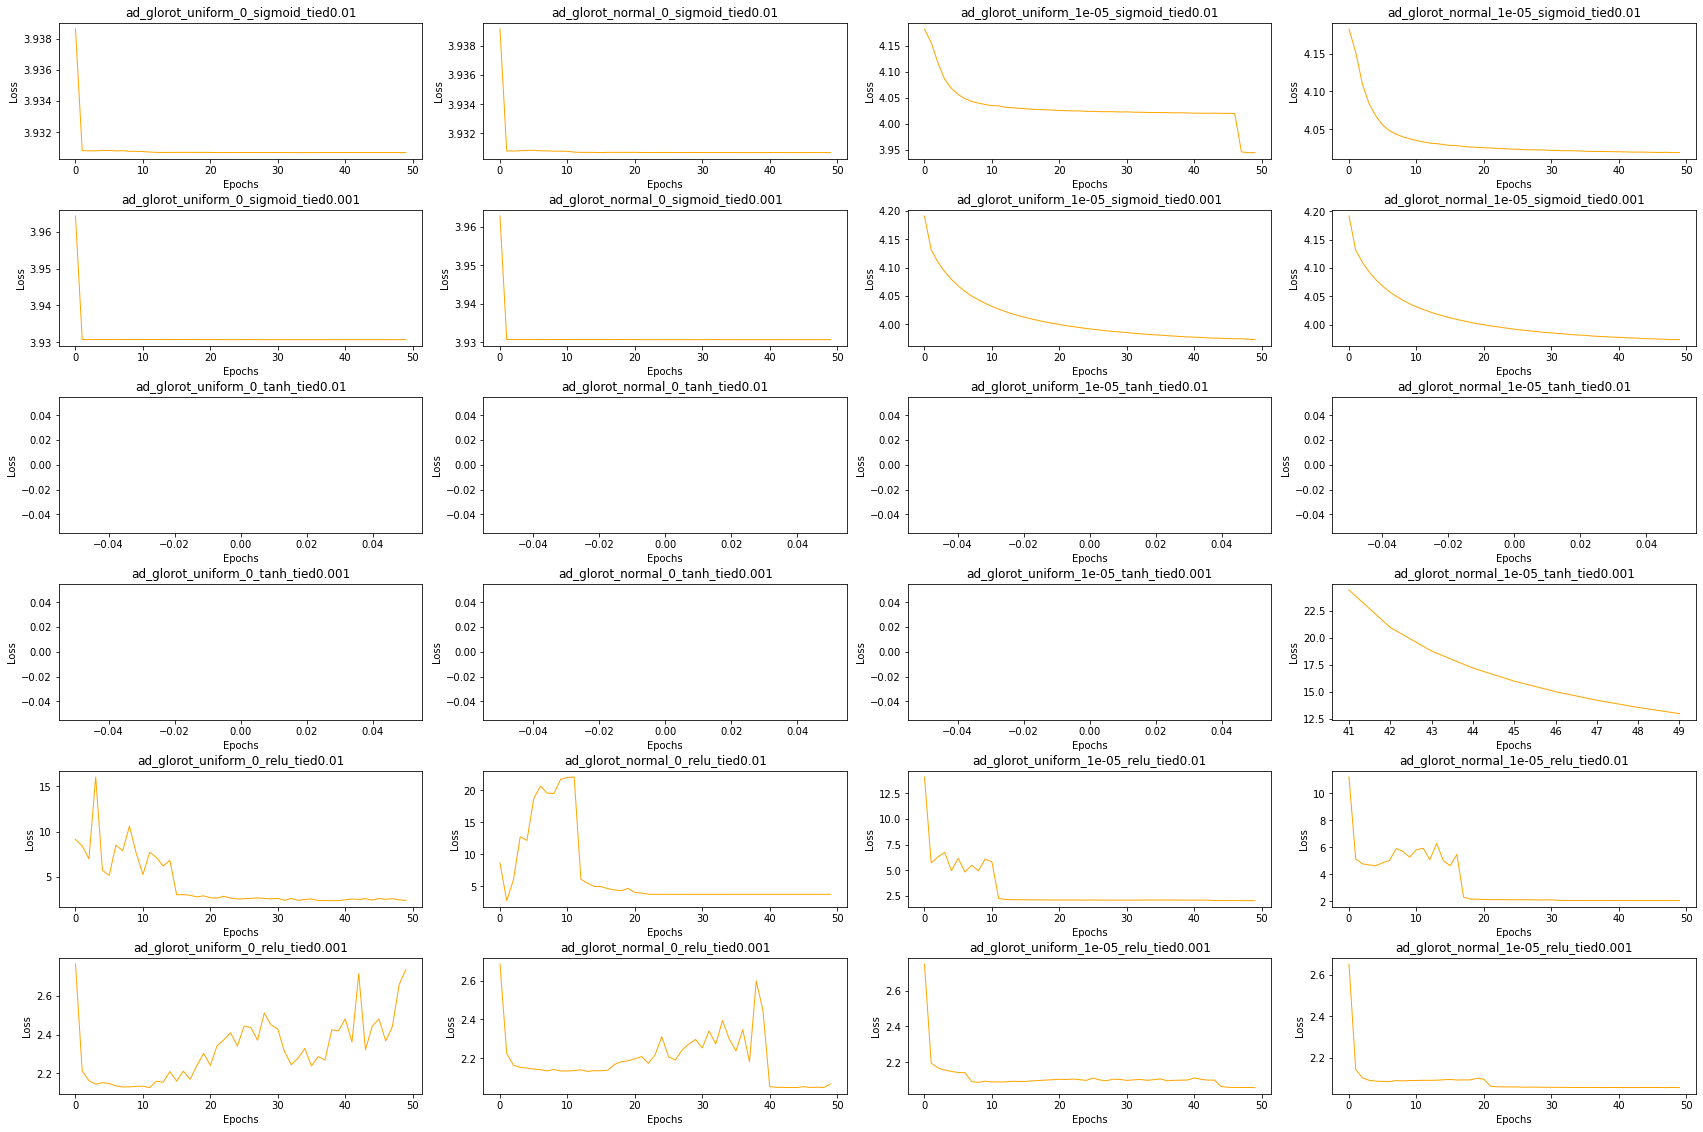

In [20]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(lr)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in lr:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) 
                #print(name)
                model_temp = model_dict_dca[name]
                ax[xi,yi].plot(list(range(0,50)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
                ax[xi,yi].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
                xi = xi+1
        yi=yi+1


    

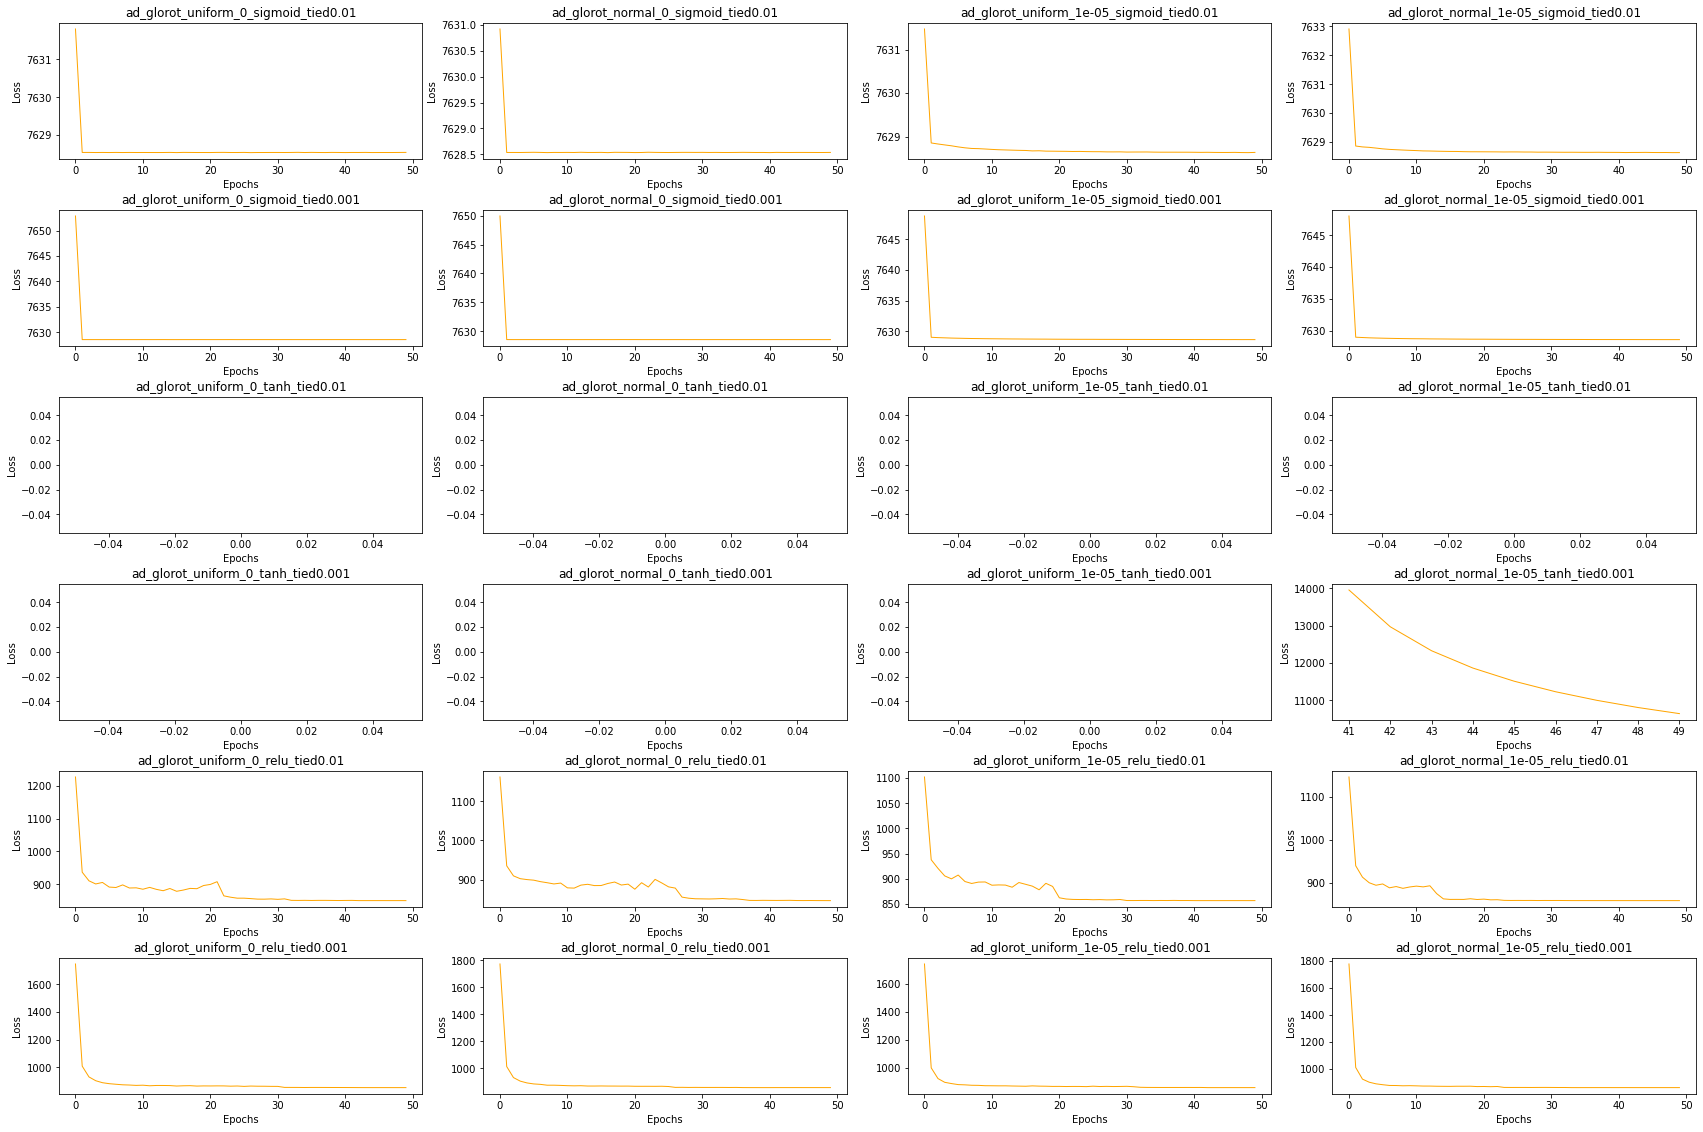

In [21]:
yd = len(inits) * len(L1_norm)
xd = len(act_fun) * len(lr)
fig, ax = plt.subplots(xd, yd,figsize=(xd*4 ,yd *4))
fig.tight_layout(pad=3.0)

xi = 0
yi = 0
for l in L1_norm:
    for i in inits:
        xi = 0
        for a in act_fun:
            for t in lr:
                name = 'ad_' + i + '_' + str(l) + '_' + a + '_tied' + str(t) 
                #print(name)
                model_temp = model_dict_da[name]
                ax[xi,yi].plot(list(range(0,50)), model_temp.loss, linewidth=1, markersize=2, color = 'orange')
                ax[xi,yi].set(title = name, xlabel = 'Epochs', ylabel = 'Loss')
                xi = xi+1
        yi=yi+1


    